In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as  plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense , TimeDistributed
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

user_id activity        timestamp    x_axis     y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.694638  12.680544  0.503953   
1             33  Jogging   49106062271000  5.012288  11.264028  0.953424   
2             33  Jogging   49106112167000  4.903325  10.882658 -0.081722   
3             33  Jogging   49106222305000 -0.612916  18.496431  3.023717   
4             33  Jogging   49106332290000 -1.184970  12.108489  7.205164   
...          ...      ...              ...       ...        ...       ...   
1098200       19  Sitting  131623331483000  9.000000  -1.570000  1.690000   
1098201       19  Sitting  131623371431000  9.040000  -1.460000  1.730000   
1098202       19  Sitting  131623411592000  9.080000  -1.380000  1.690000   
1098203       19  Sitting  131623491487000  9.000000  -1.460000  1.730000   
1098204       19  Sitting  131623531465000  8.880000  -1.330000  1.610000   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

<Axes: xlabel='activity', ylabel='count'>

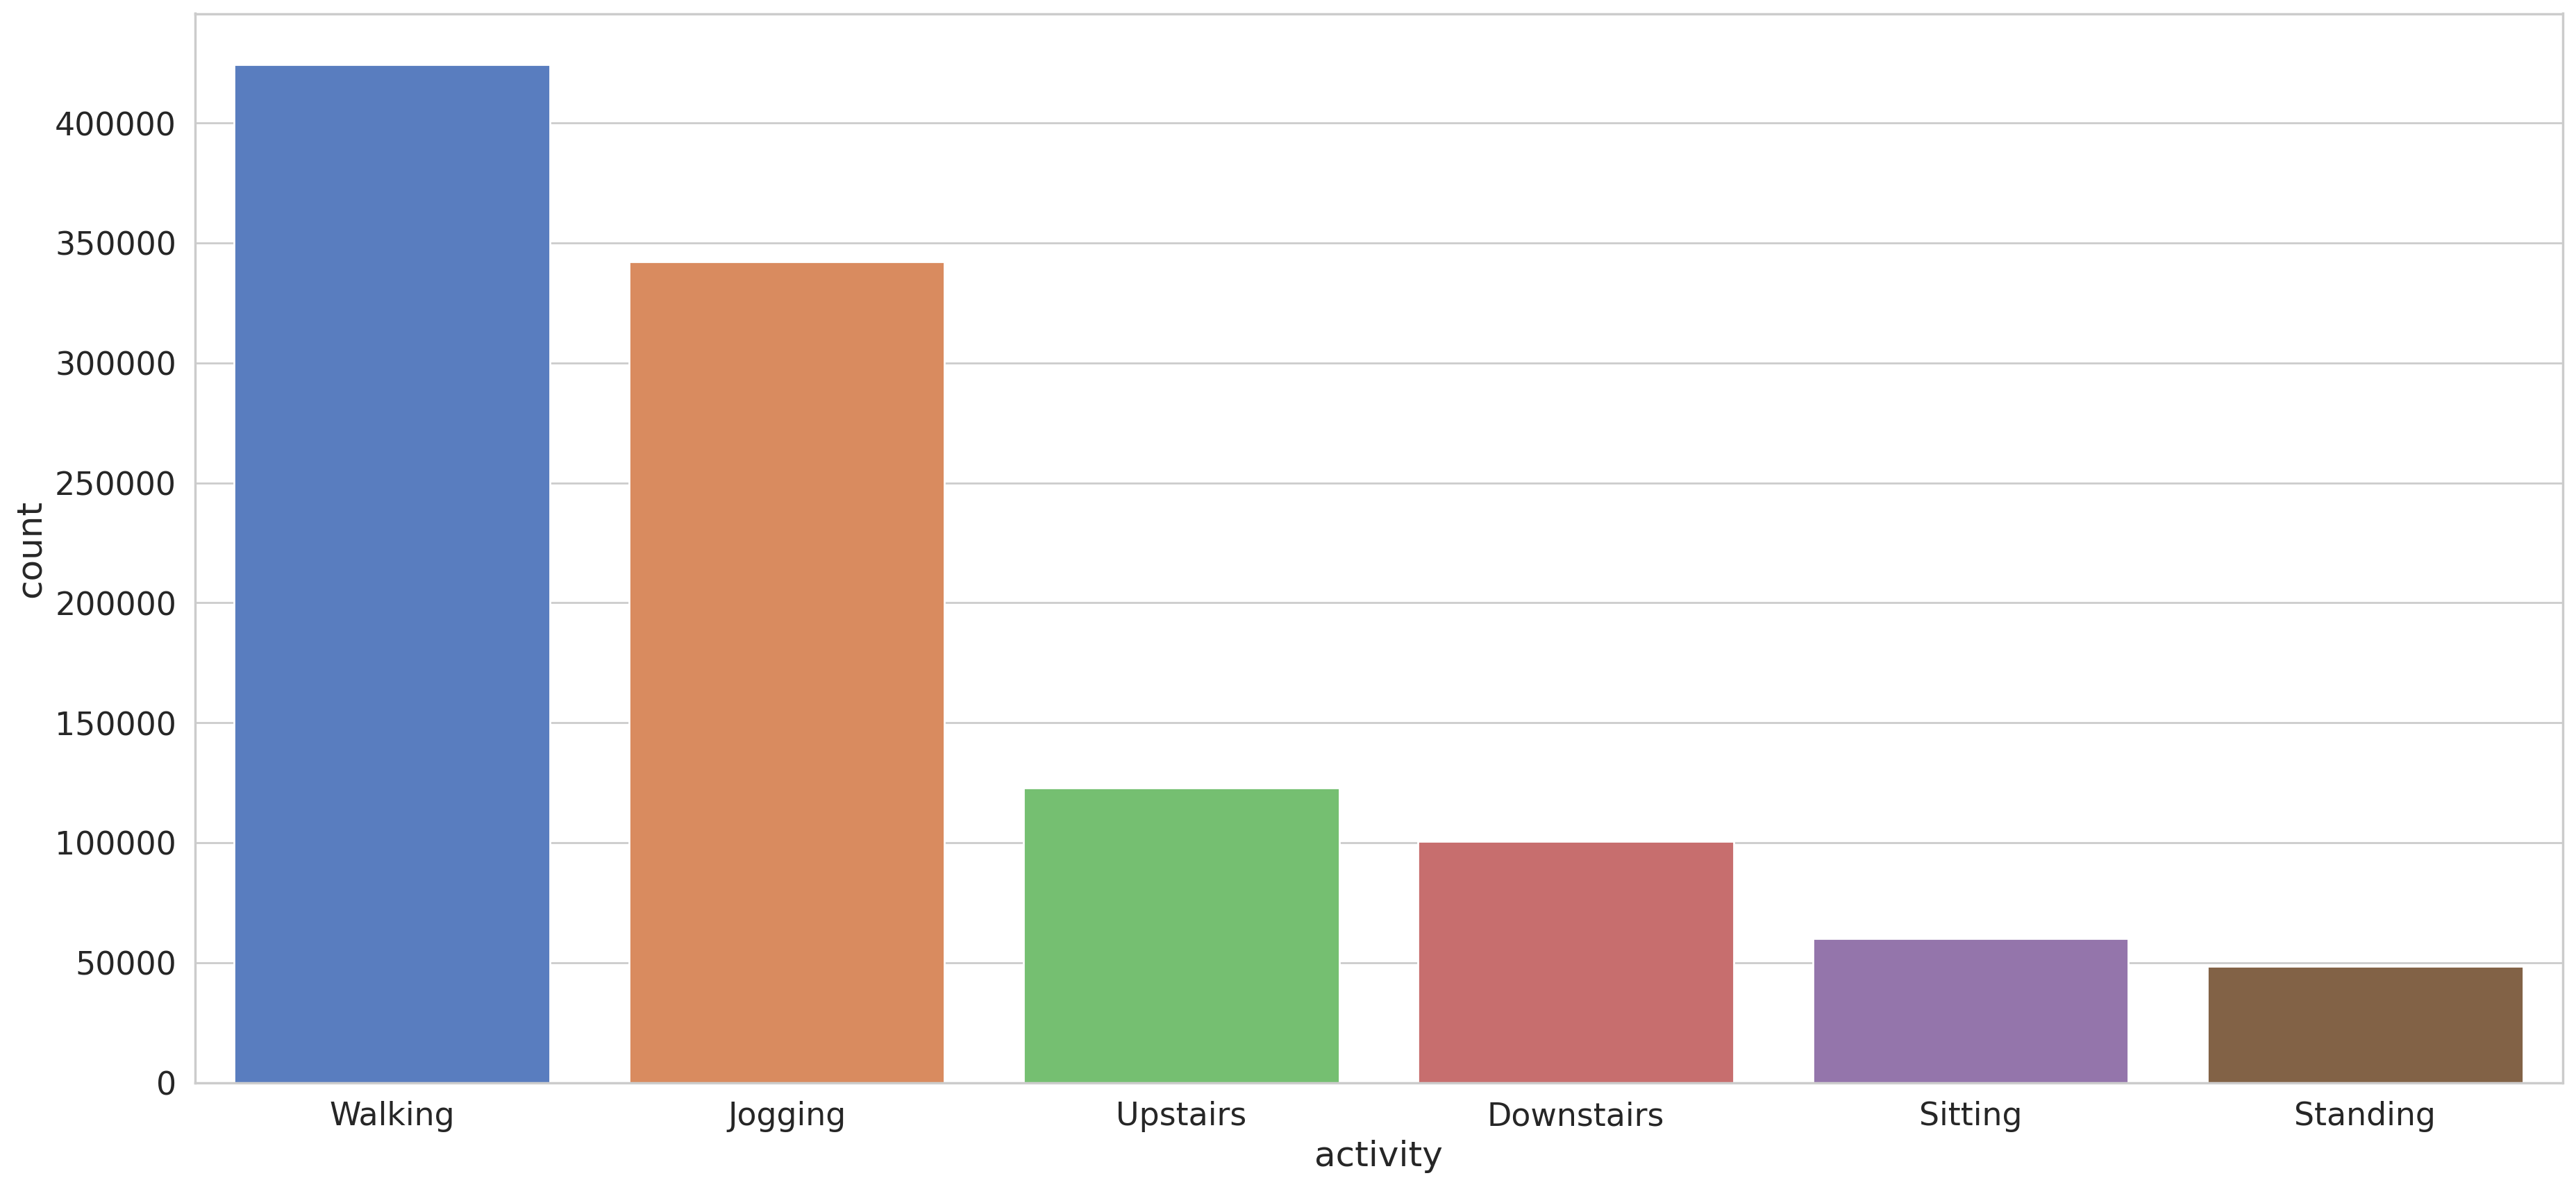

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

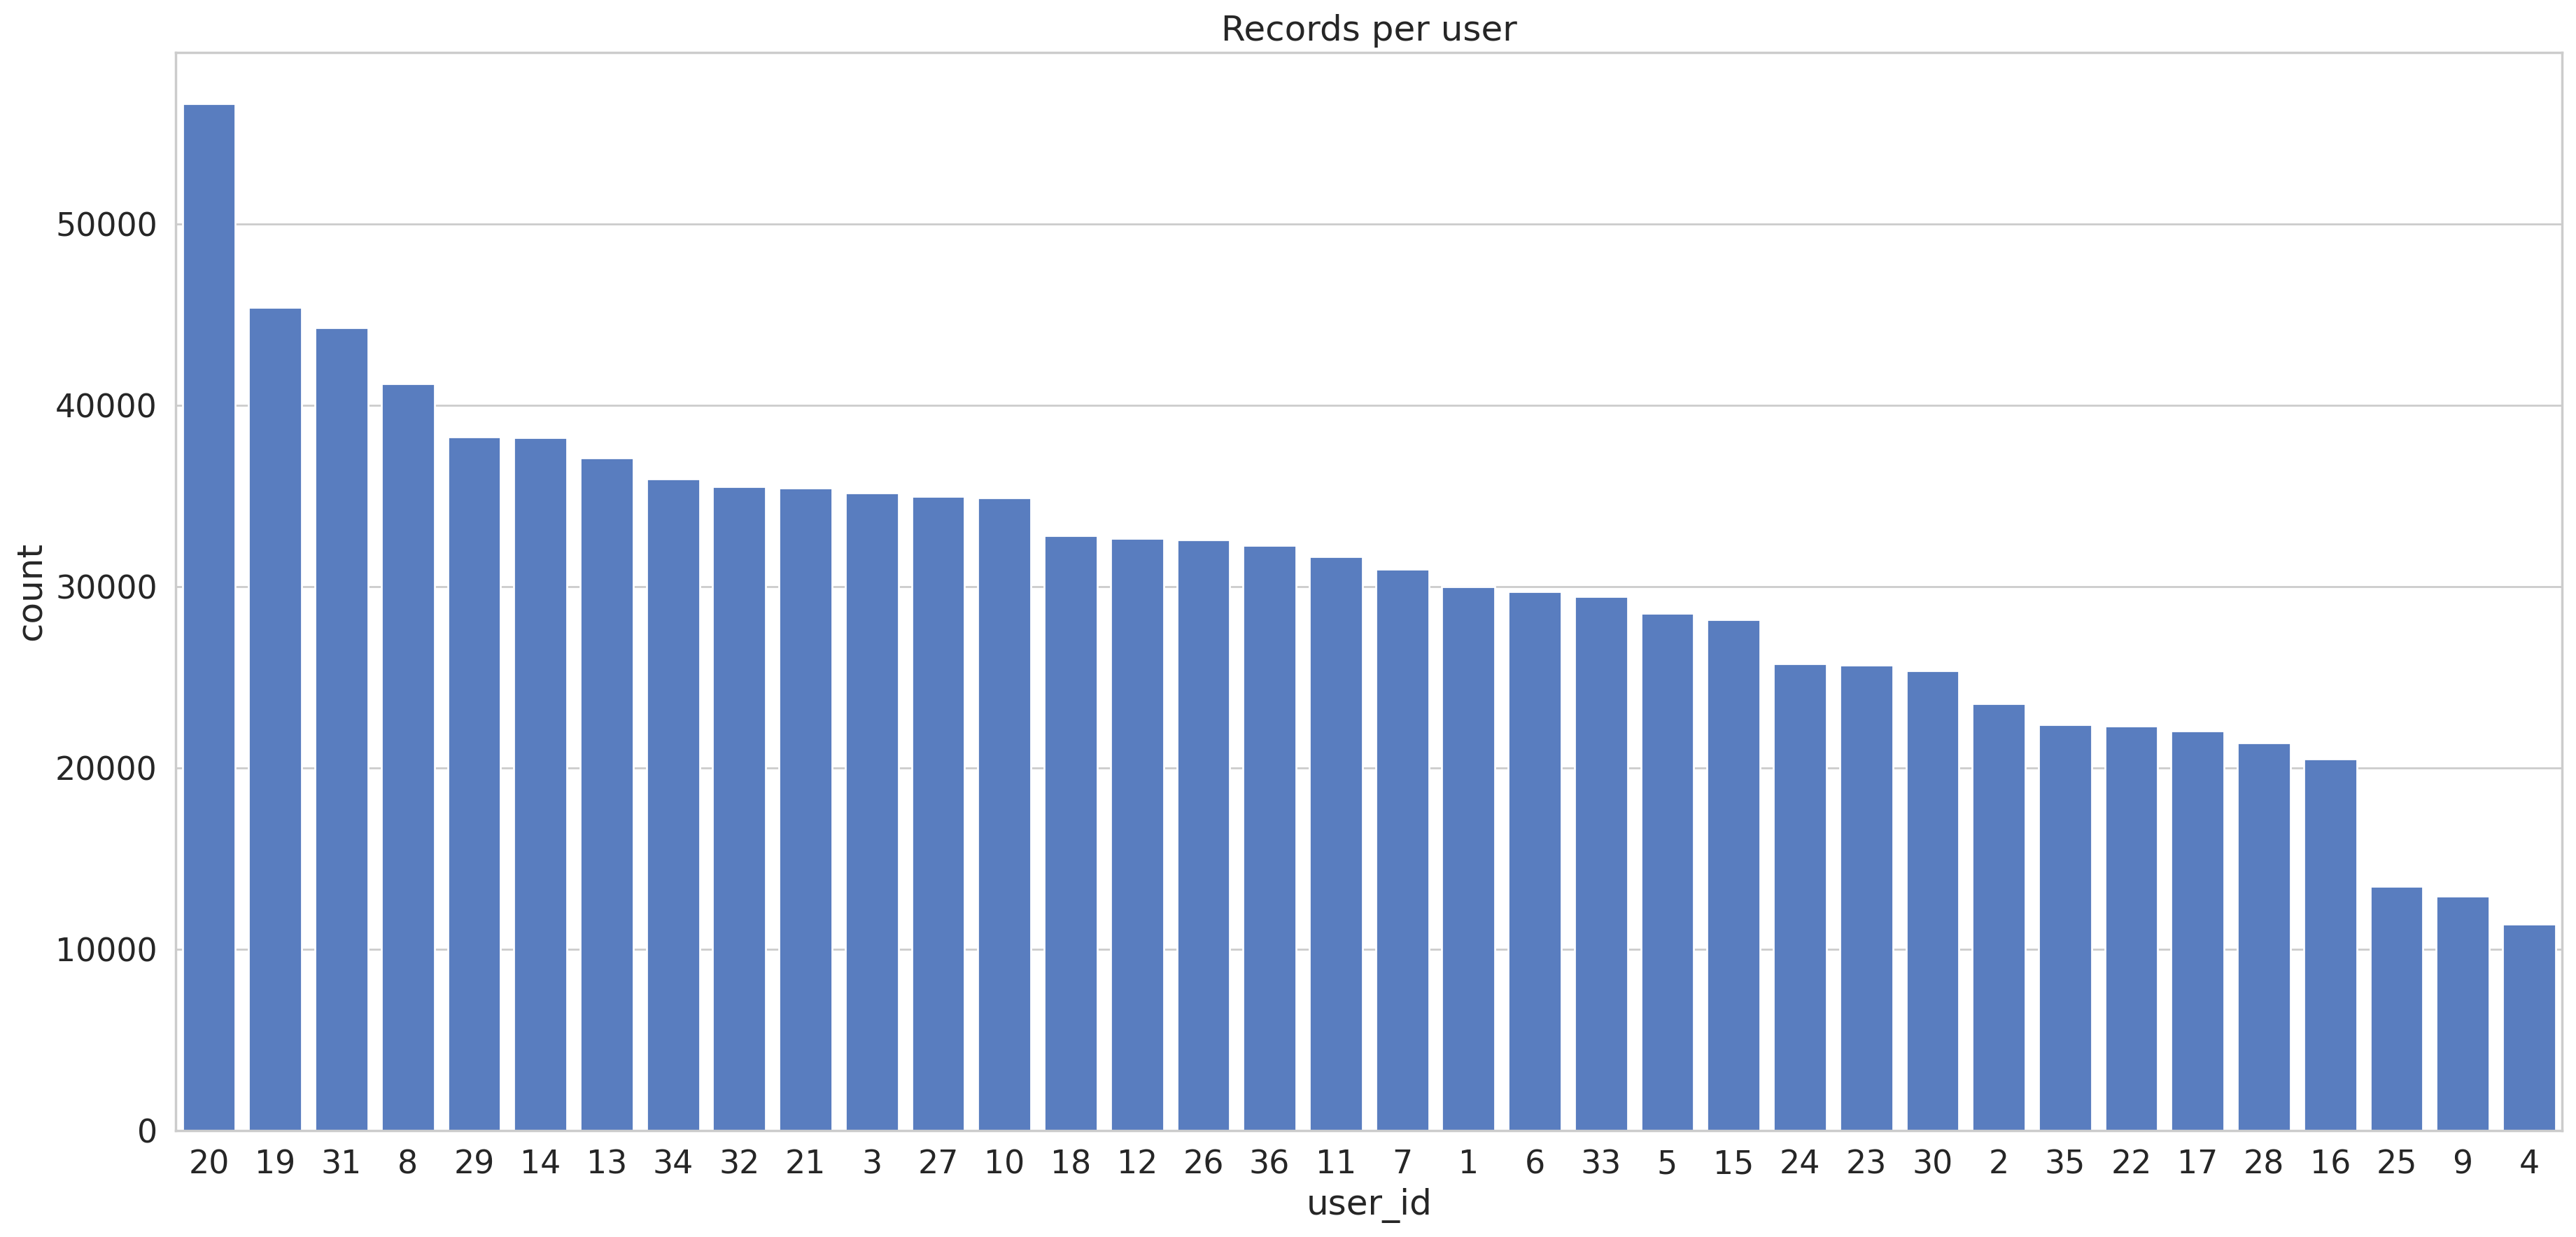

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


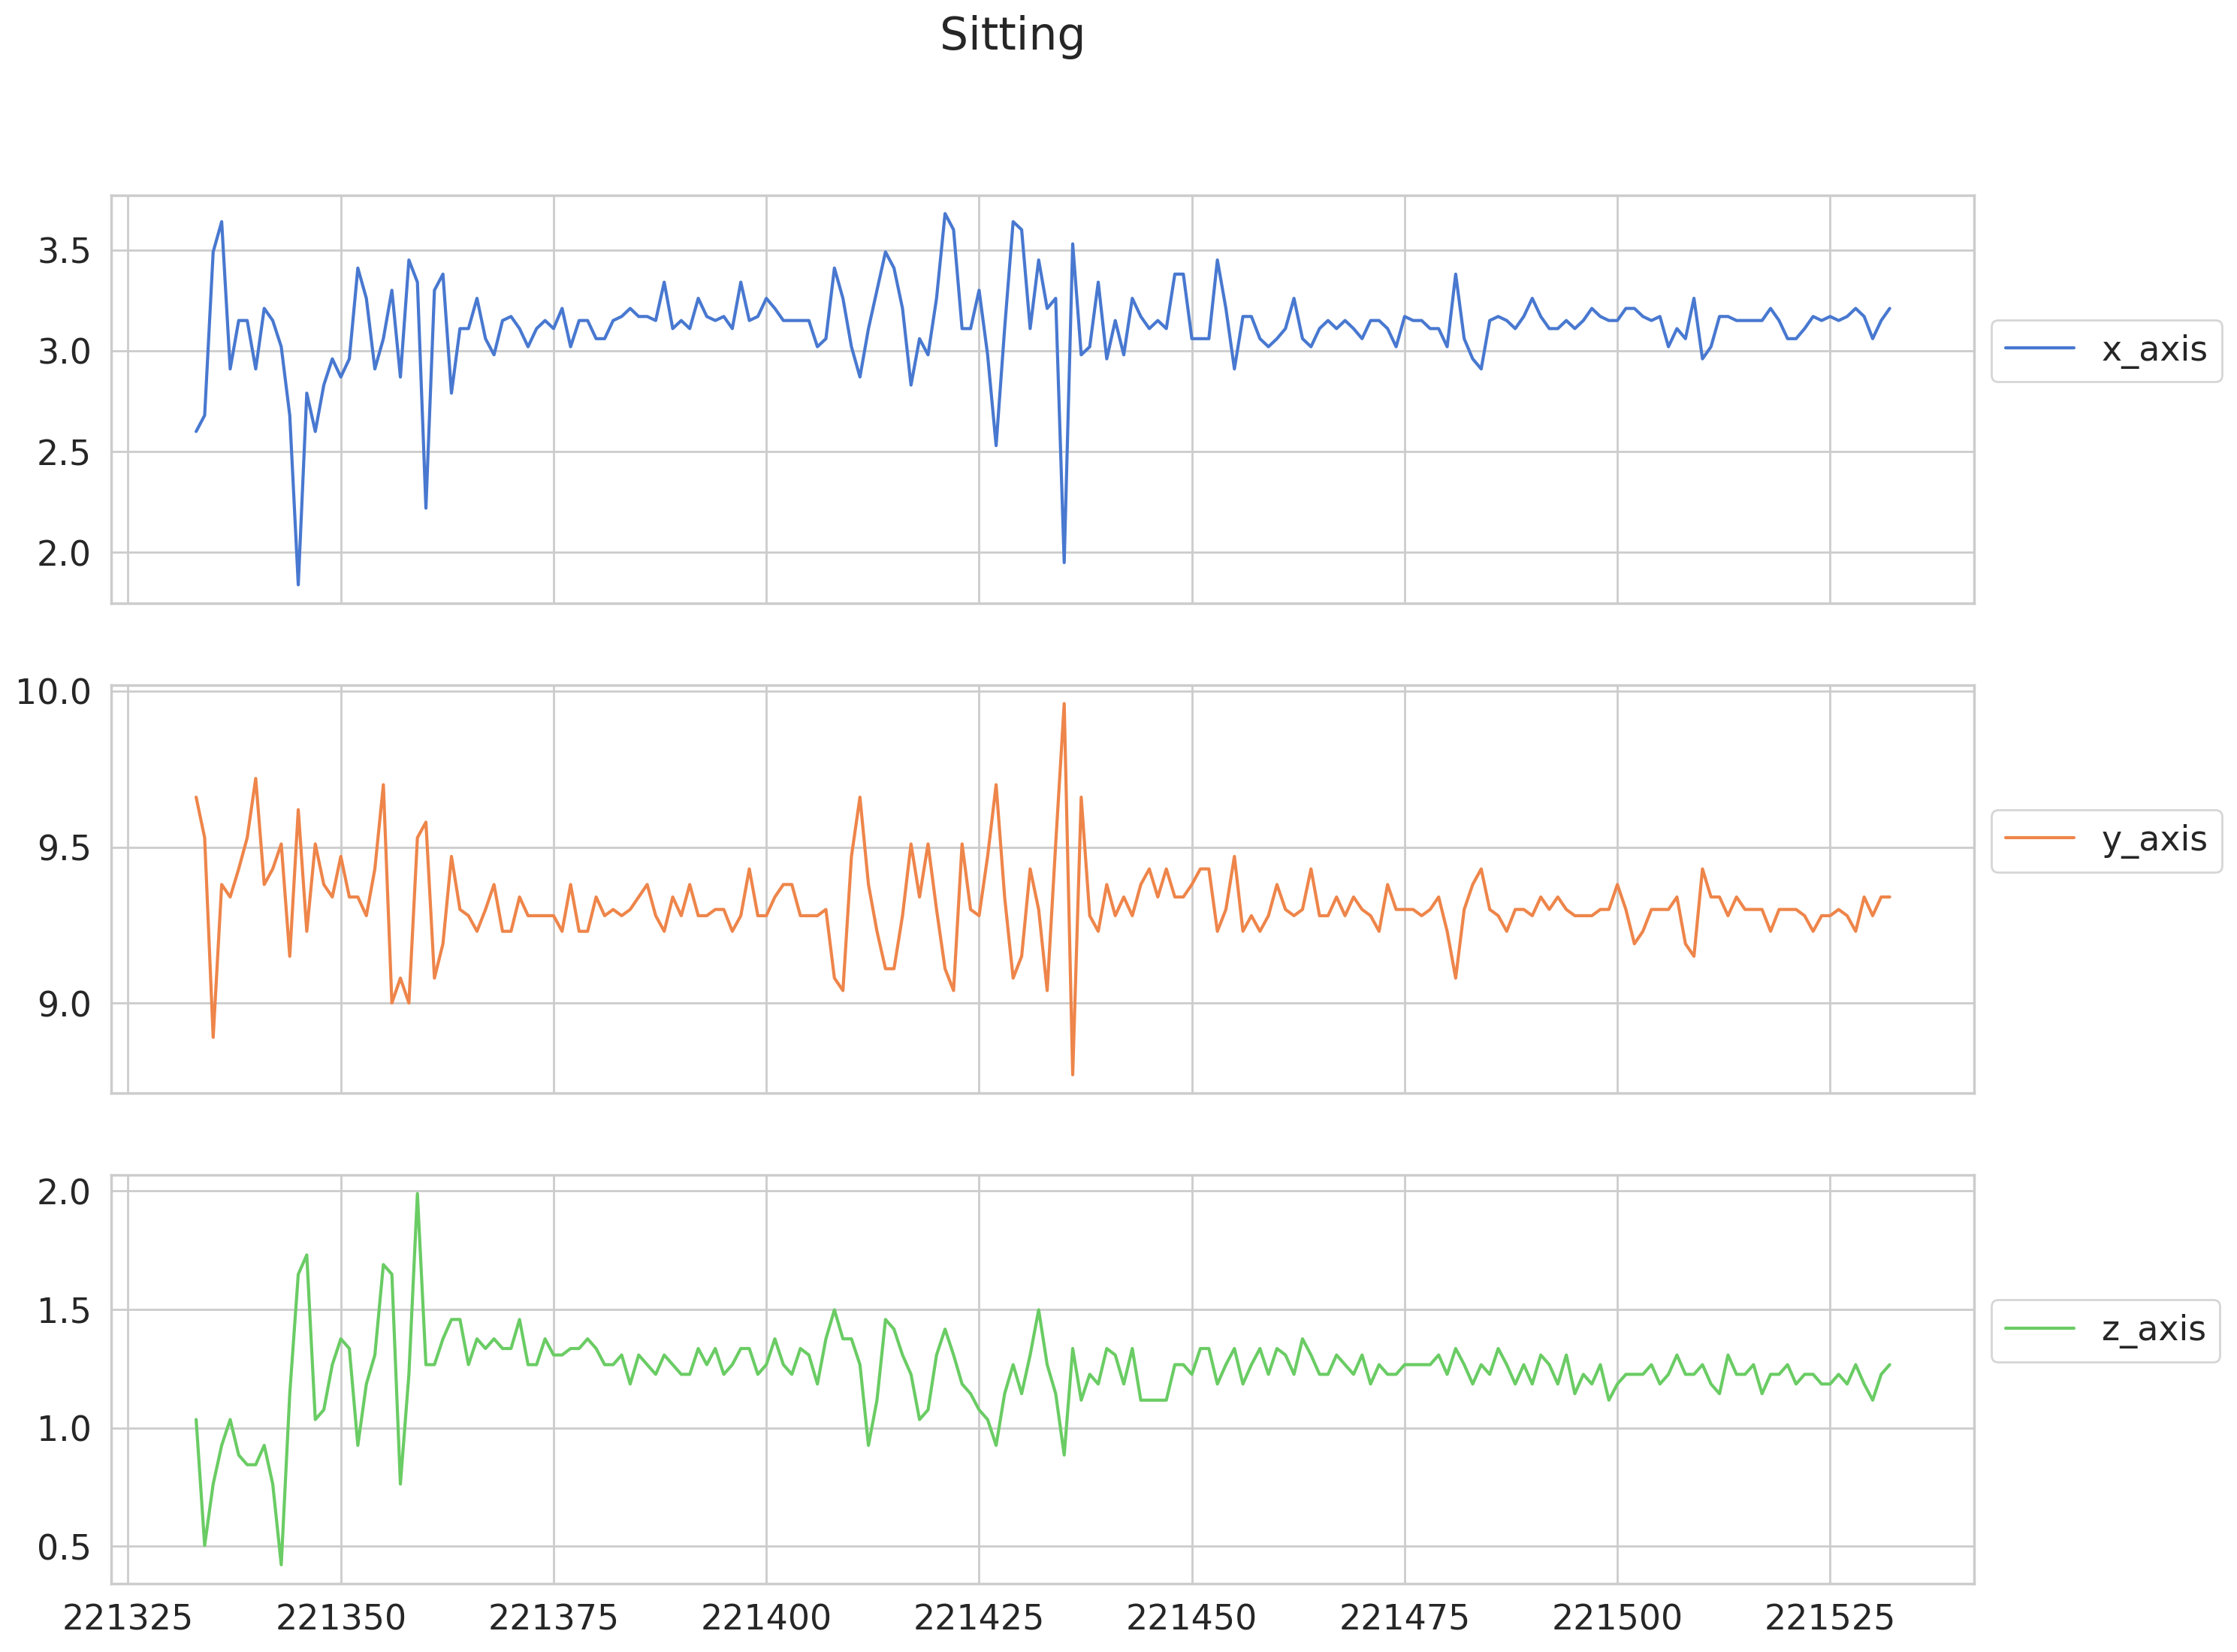

In [8]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [9]:
indexes = df[ (df['activity'] == 'Sitting') | (df['activity'] == 'Standing')].index
df.drop(indexes , inplace=True)

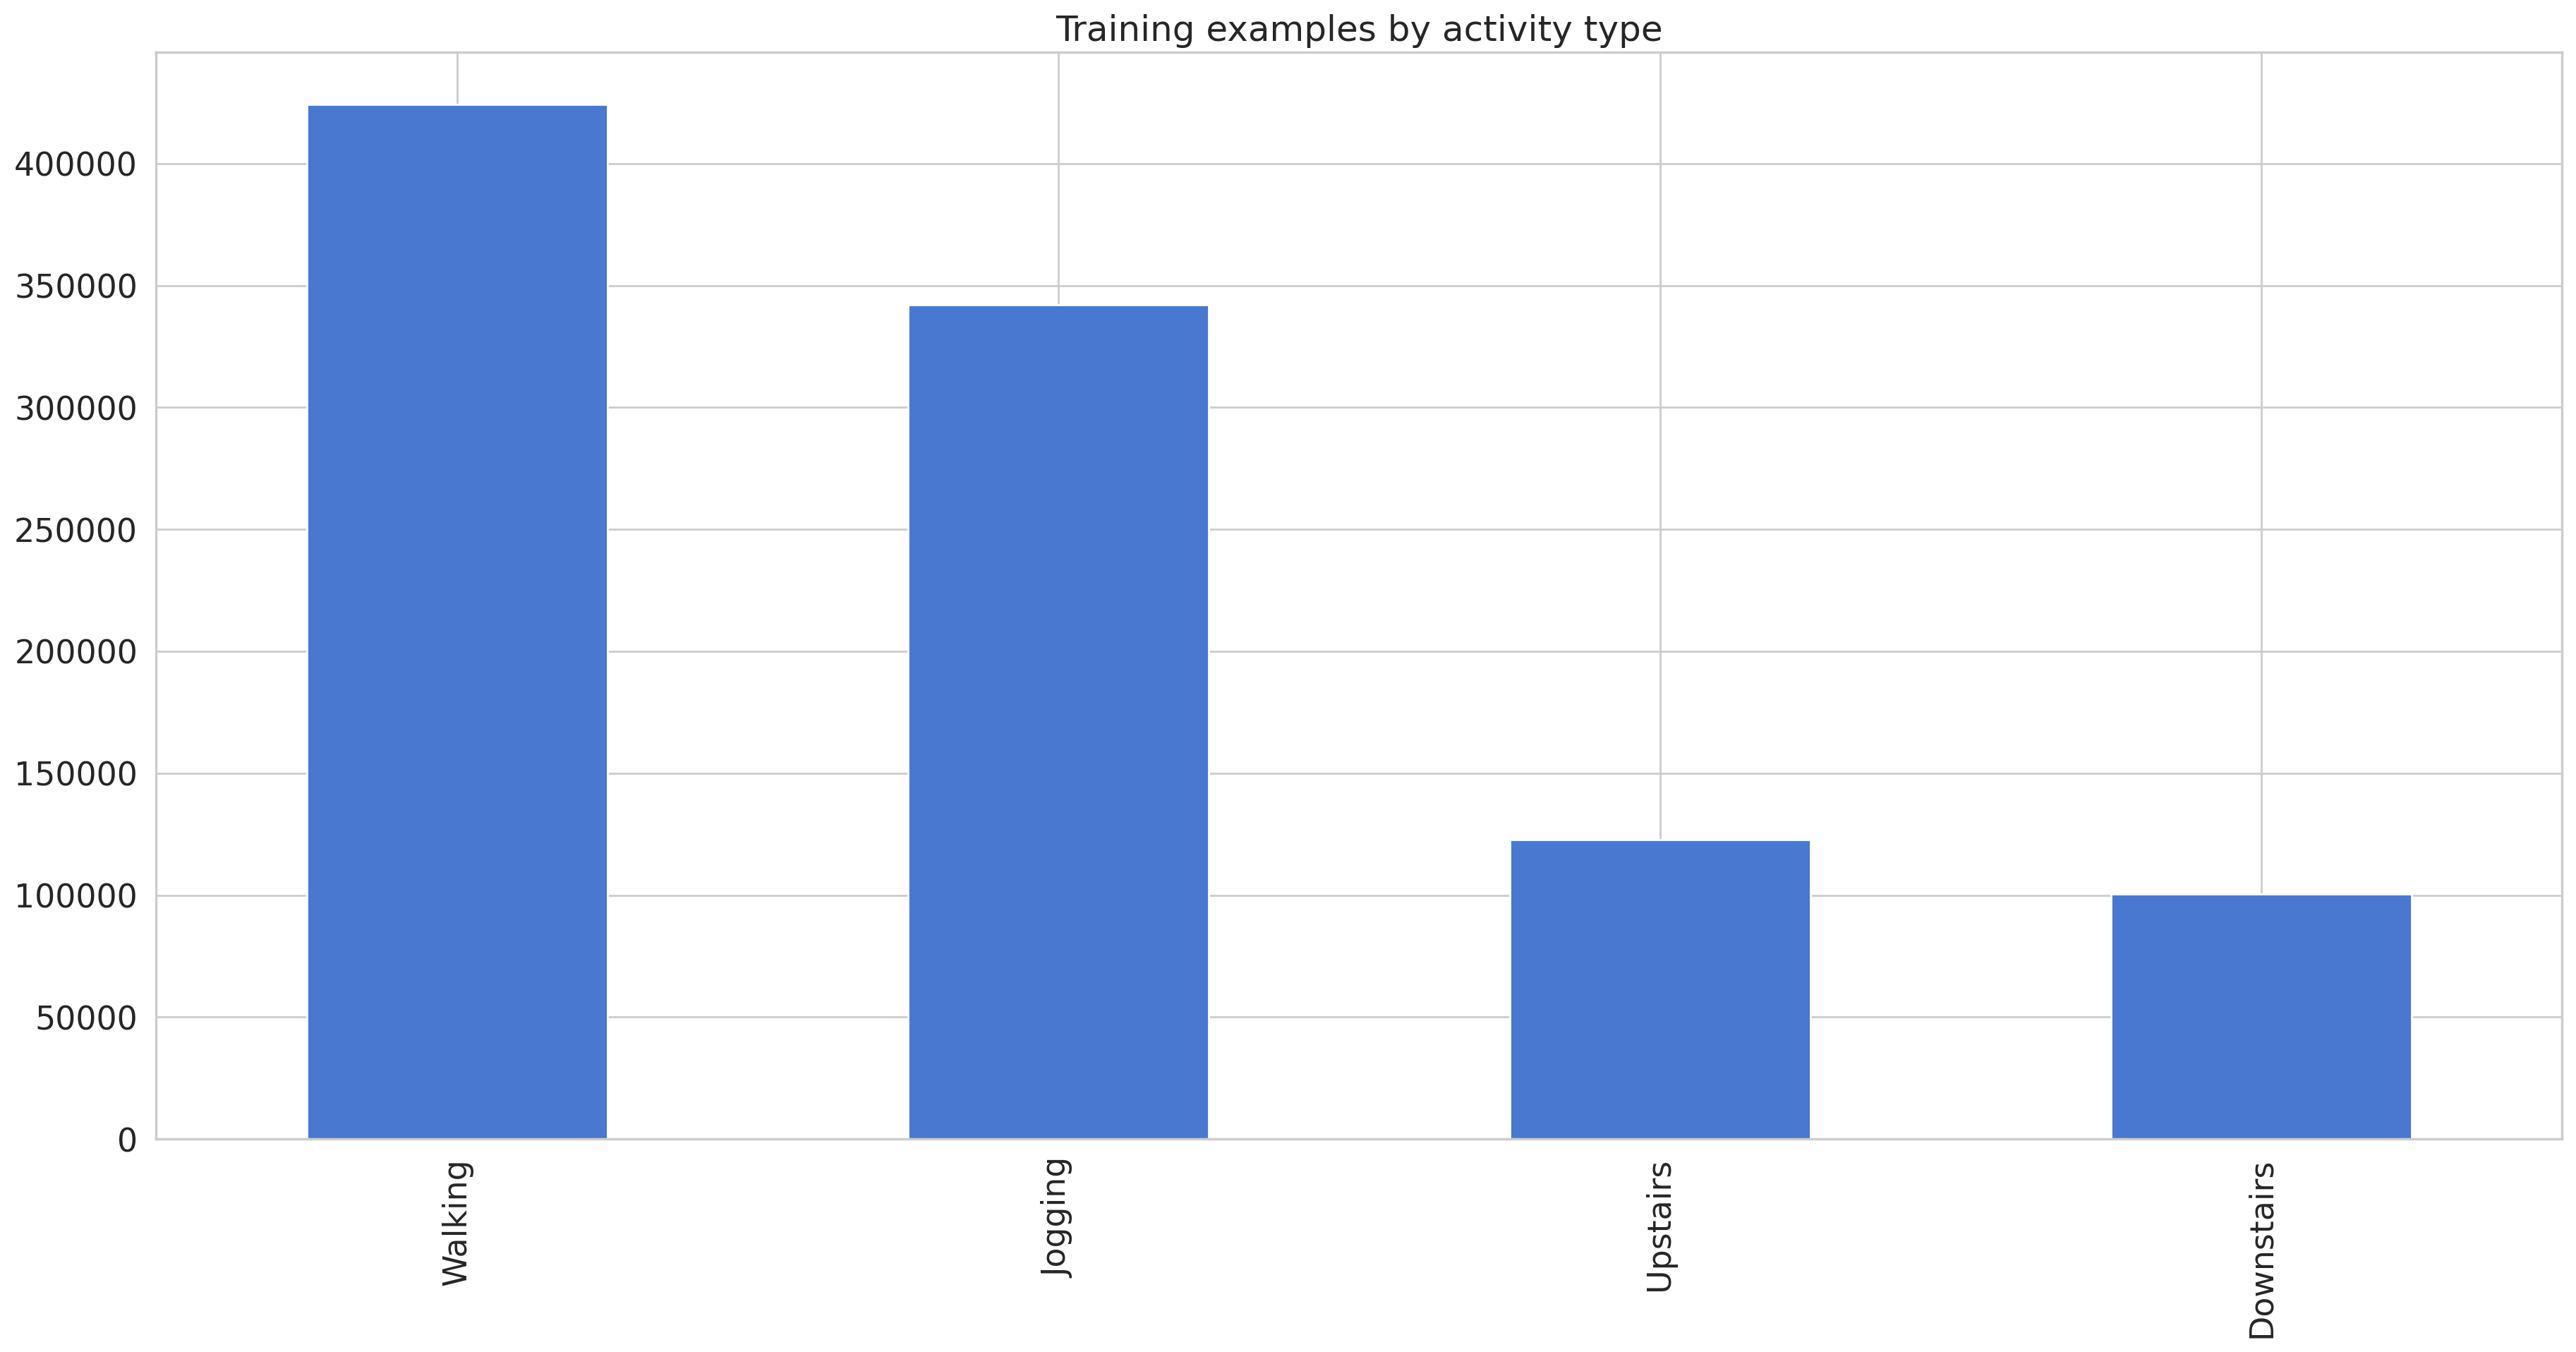

In [10]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [11]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


user_id    activity        timestamp    x_axis    y_axis    z_axis  \
0             33     Jogging   49105962326000 -0.139064  0.528798  0.162904   
1             33     Jogging   49106062271000  0.627996  0.365980  0.257510   
2             33     Jogging   49106112167000  0.613350  0.322145  0.039629   
3             33     Jogging   49106222305000 -0.128080  1.197291  0.693271   
4             33     Jogging   49106332290000 -0.204969  0.463045  1.573395   
...          ...         ...              ...       ...       ...       ...   
1093534       19  Downstairs  131357151521000 -0.602151 -0.017241  0.635659   
1093535       19  Downstairs  131357191438000 -0.987903  0.155172  0.248370   
1093536       19  Downstairs  131357231630000 -1.235215  0.718391  0.119975   
1093537       19  Downstairs  131357271516000 -1.065860  0.026437 -0.524103   
1093538       19  Downstairs  131357351686000 -0.977151 -0.510345 -0.103137   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1093534                3  
1093535                3  
1093536                3  
1093537                3  
1093538                3  

[989870 rows x 7 columns]

In [12]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)
X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )


n_steps = 4
n_features = X_train.shape[2]
n_length = 50

X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(15834, 4, 50, 3) (15834, 1)
(4949, 4, 50, 3) (4949, 1)


In [13]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(15834, 4, 50, 3) (15834, 4) (4949, 4, 50, 3) (4949, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
#Epoch 500

BATCH_SIZE = 32

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps, n_features, n_outputs = n_steps * n_length, X_train.shape[3], y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 4)

# layer 3

# CNN 1 - LSTM2

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 48, 64)      640       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 48, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 24, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, None, 1536)        0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, None, 100)         6

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 24s 148ms/step - loss: 0.6705 - accuracy: 0.7461 - val_loss: 0.4570 - val_accuracy: 0.8098
Epoch 2/10
124/124 [==============================] - 17s 140ms/step - loss: 0.4051 - accuracy: 0.8393 - val_loss: 0.3292 - val_accuracy: 0.8664
Epoch 3/10
124/124 [==============================] - 18s 142ms/step - loss: 0.3029 - accuracy: 0.8719 - val_loss: 0.2601 - val_accuracy: 0.8914
Epoch 4/10
124/124 [==============================] - 18s 147ms/step - loss: 0.2421 - accuracy: 0.9026 - val_loss: 0.2209 - val_accuracy: 0.9134
Epoch 5/10
124/124 [==============================] - 18s 143ms/step - loss: 0.1959 - accuracy: 0.9248 - val_loss: 0.1653 - val_accuracy: 0.9406
Epoch 6/10
124/124 [==============================] - 19s 153ms/step - loss: 0.1550 - accuracy: 0.9445 - val_loss: 0.1598 - val_accuracy: 0.9409
Epoch 7/10
124/124 [==============================] - 17s 140ms/step - loss: 0.1332 - accuracy: 0.9535 - val_loss: 0.1491 - val_ac

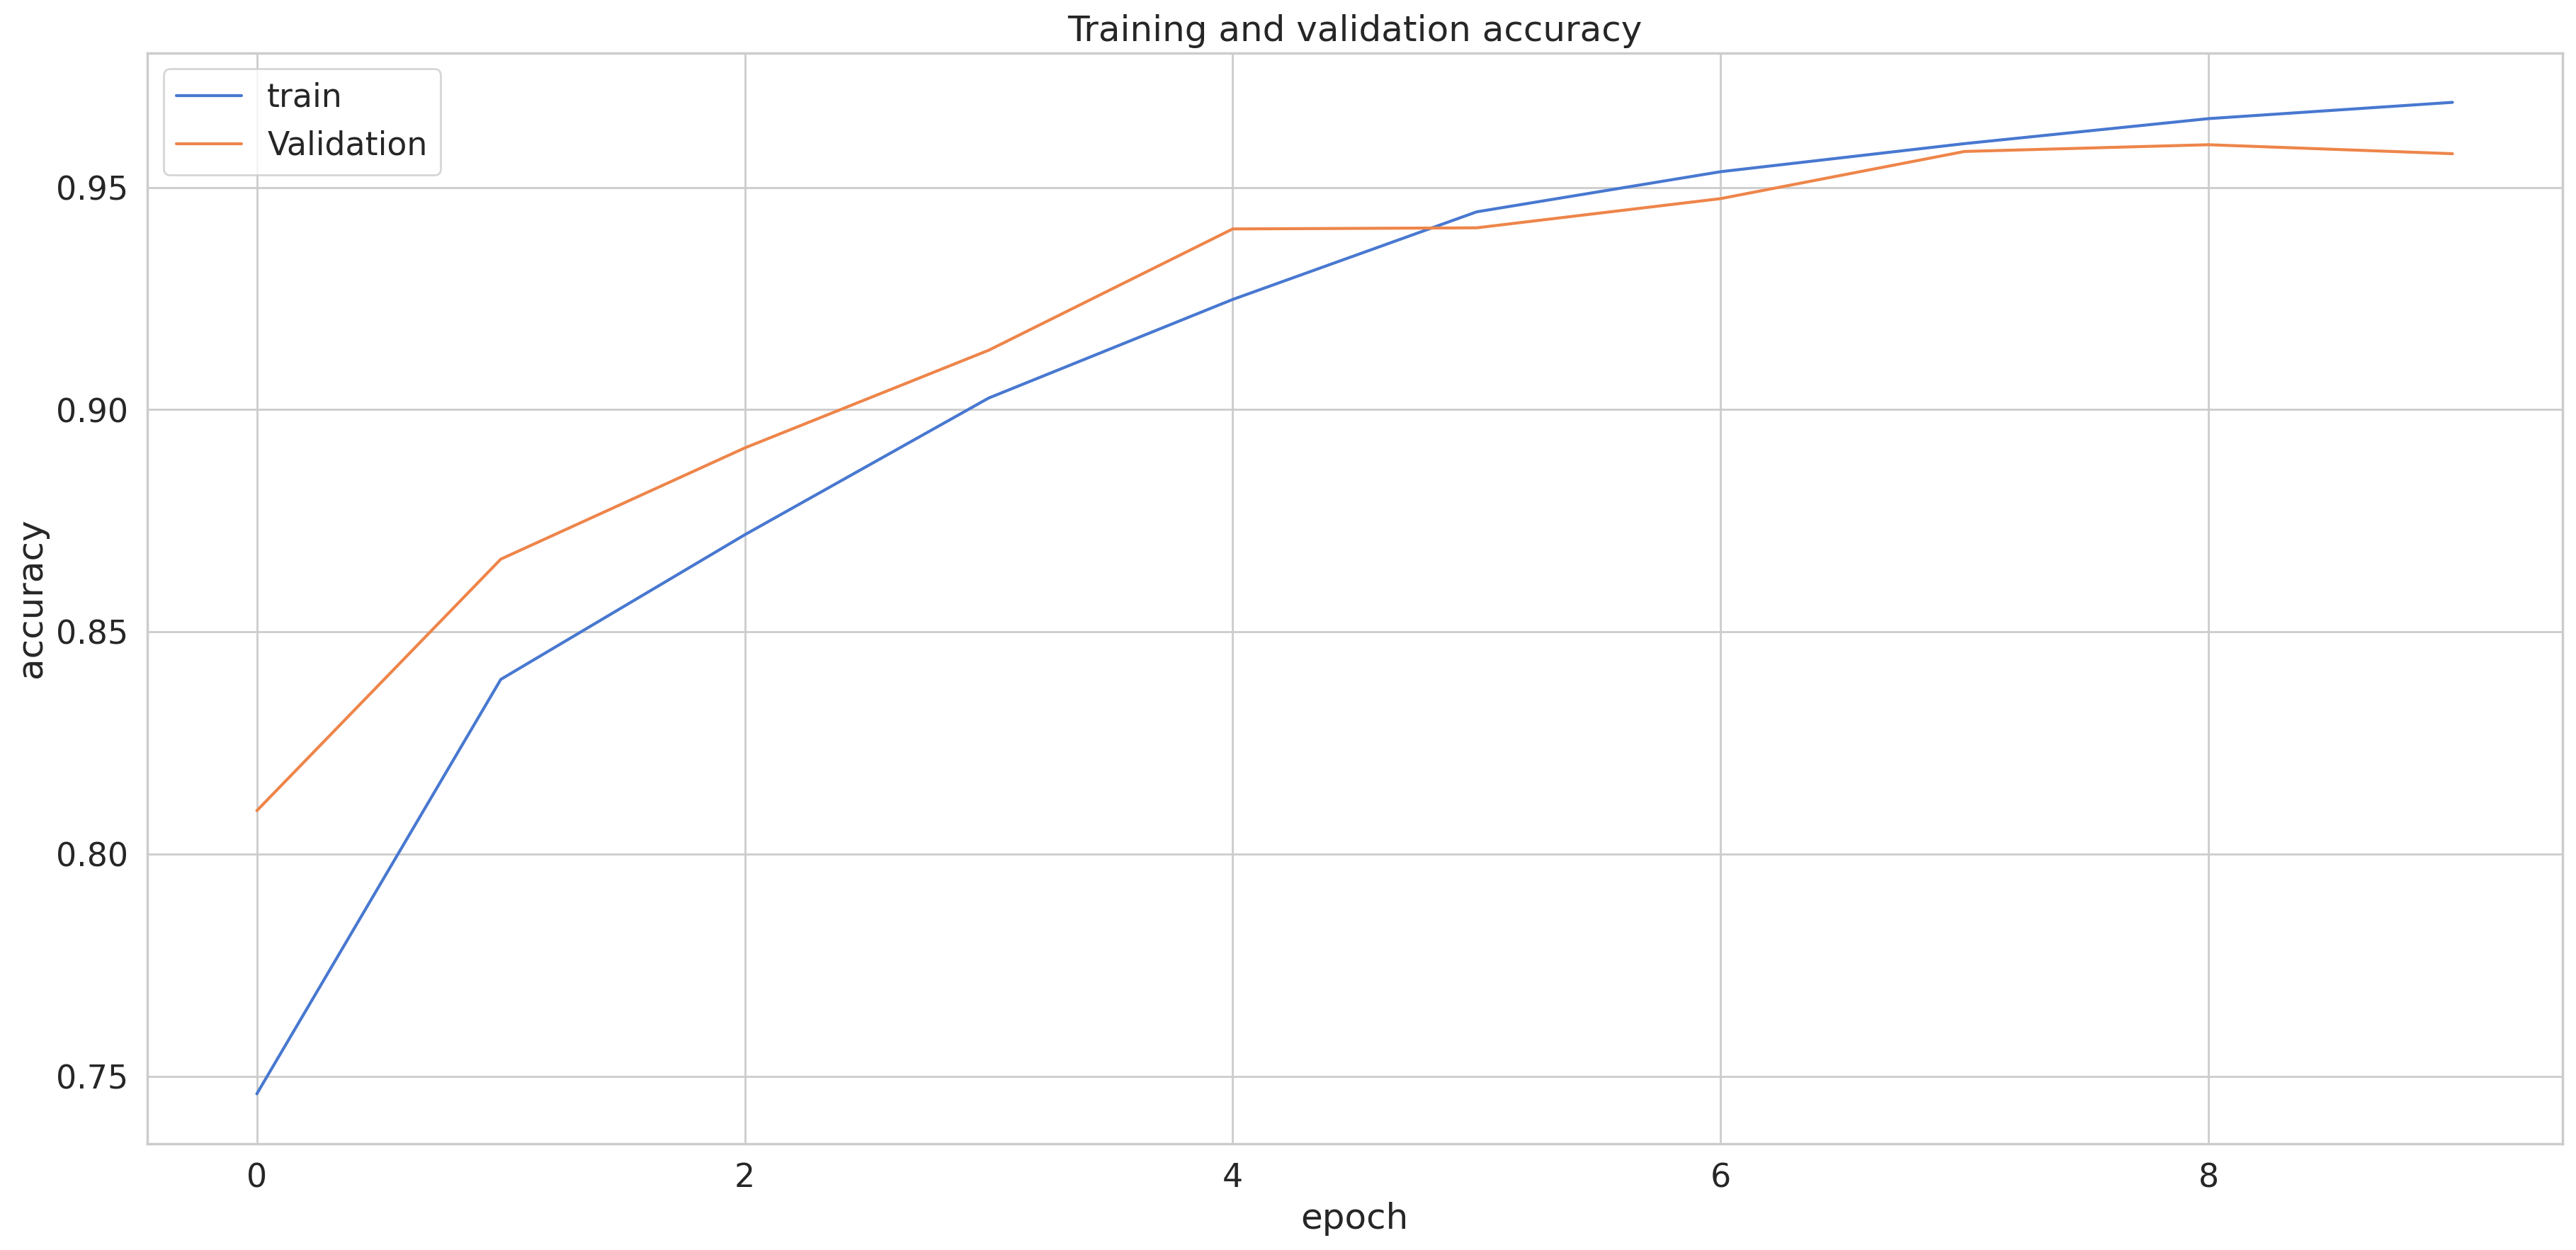

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

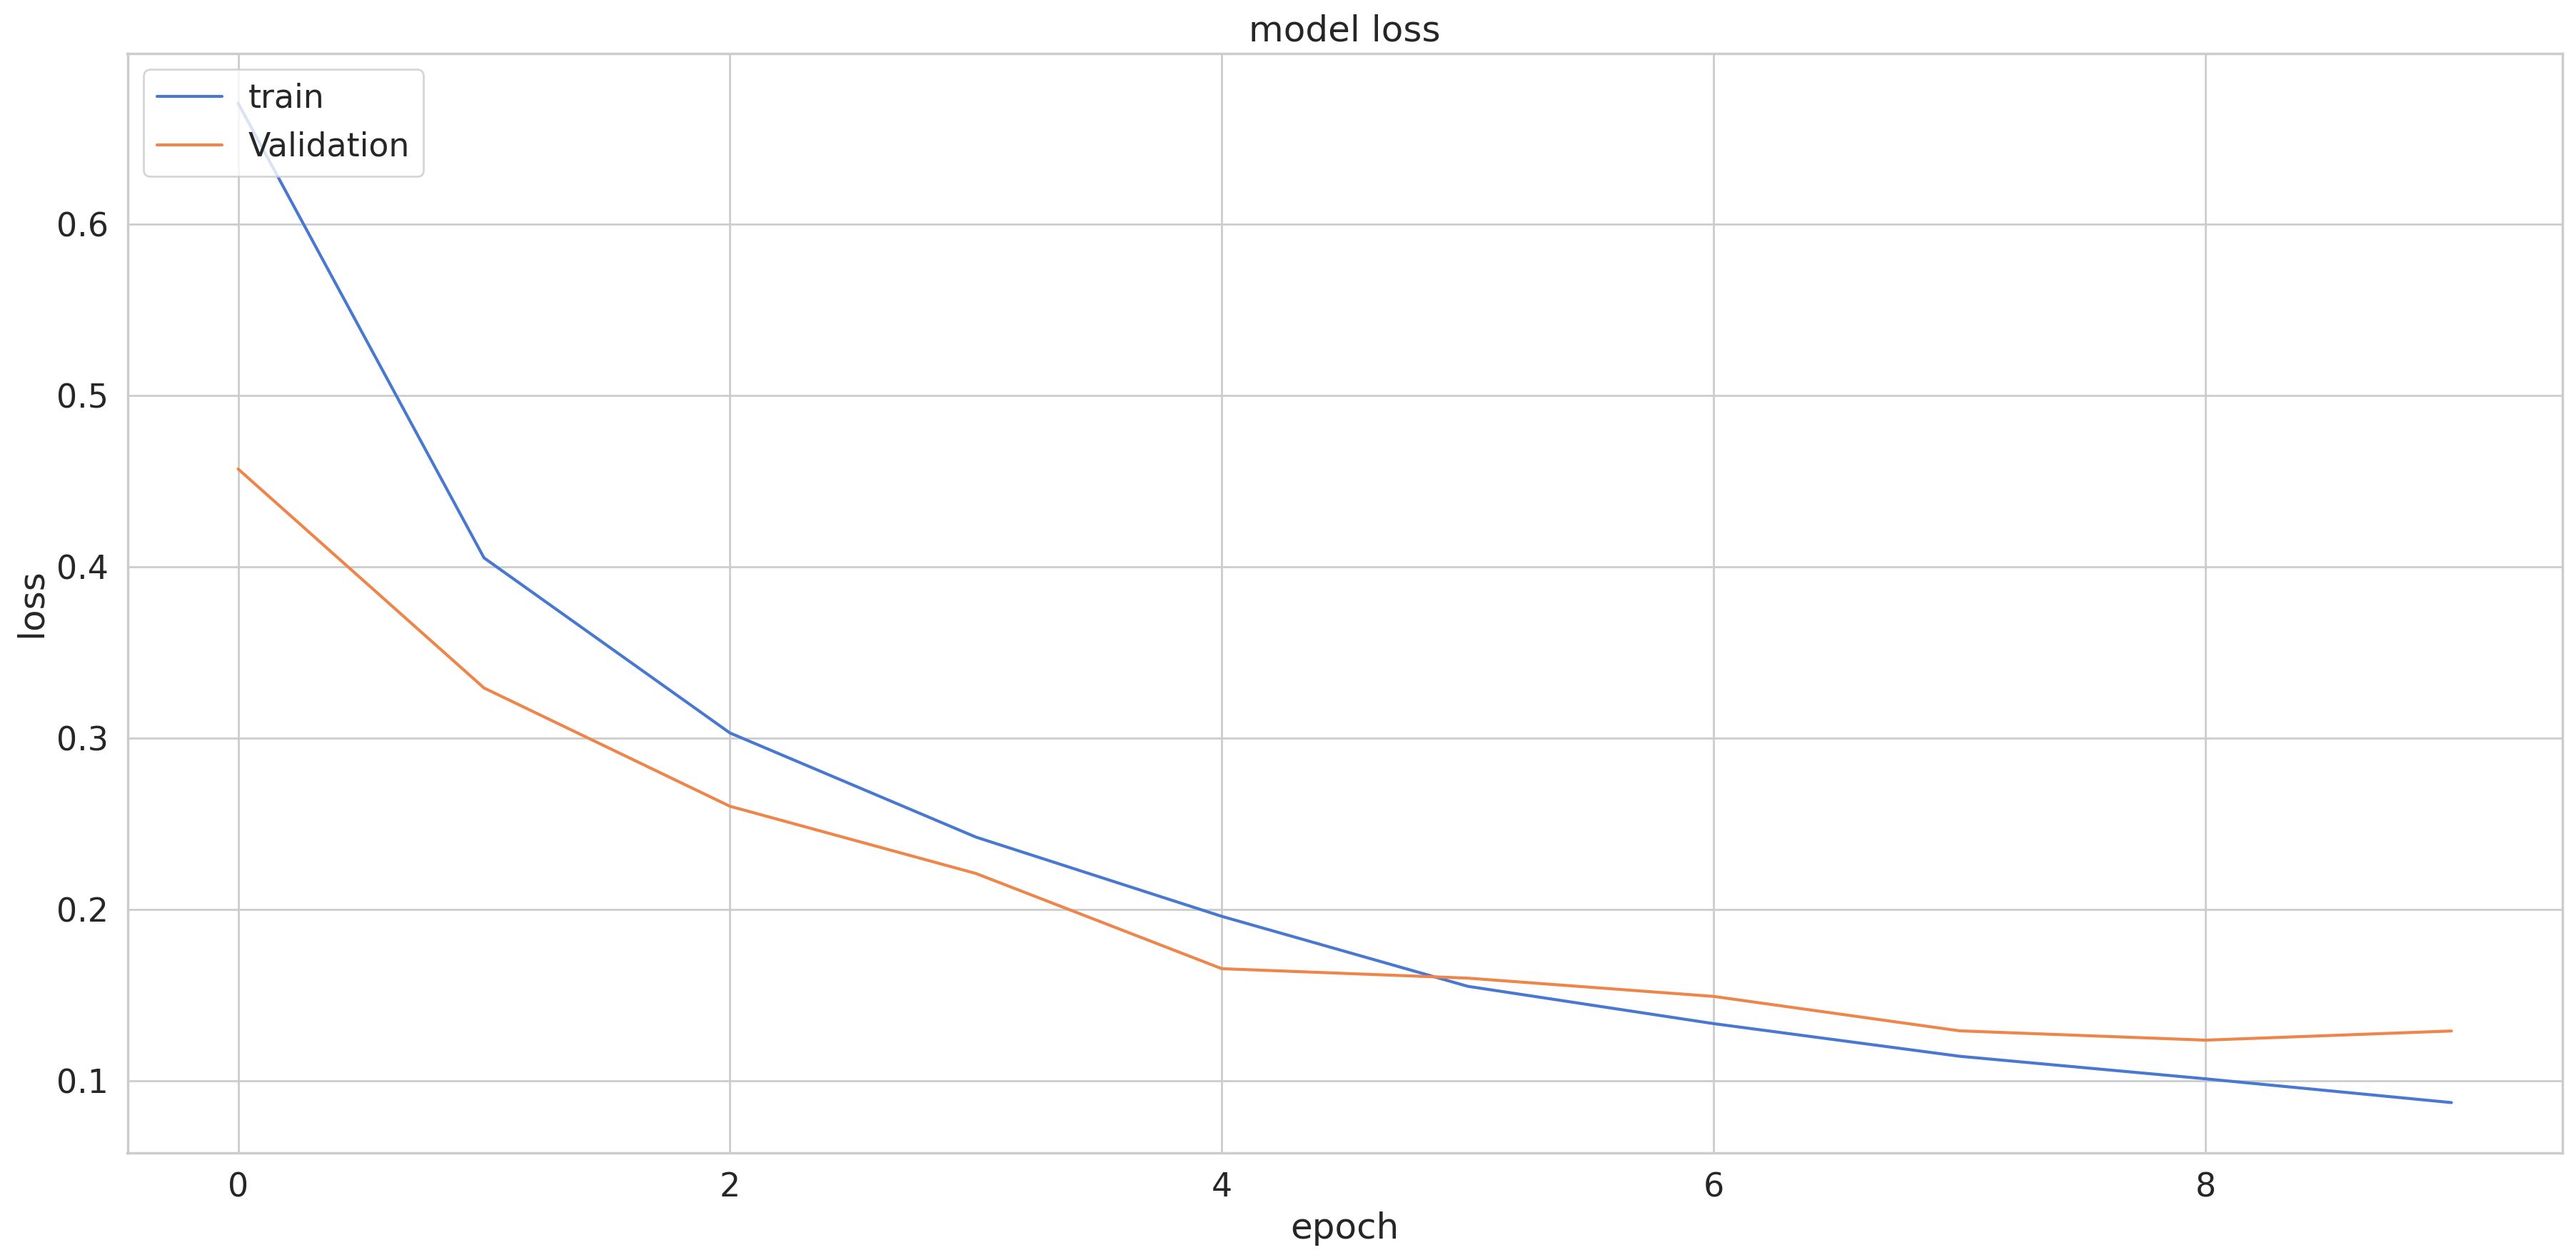

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 4s 18ms/step
f1_score =  0.9589150797491469
0.9587795514245302
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2123
           1       0.97      0.99      0.98      1710
           2       0.86      0.88      0.87       615
           3       0.88      0.88      0.88       501

    accuracy                           0.96      4949
   macro avg       0.93      0.93      0.93      4949
weighted avg       0.96      0.96      0.96      4949



<Axes: >

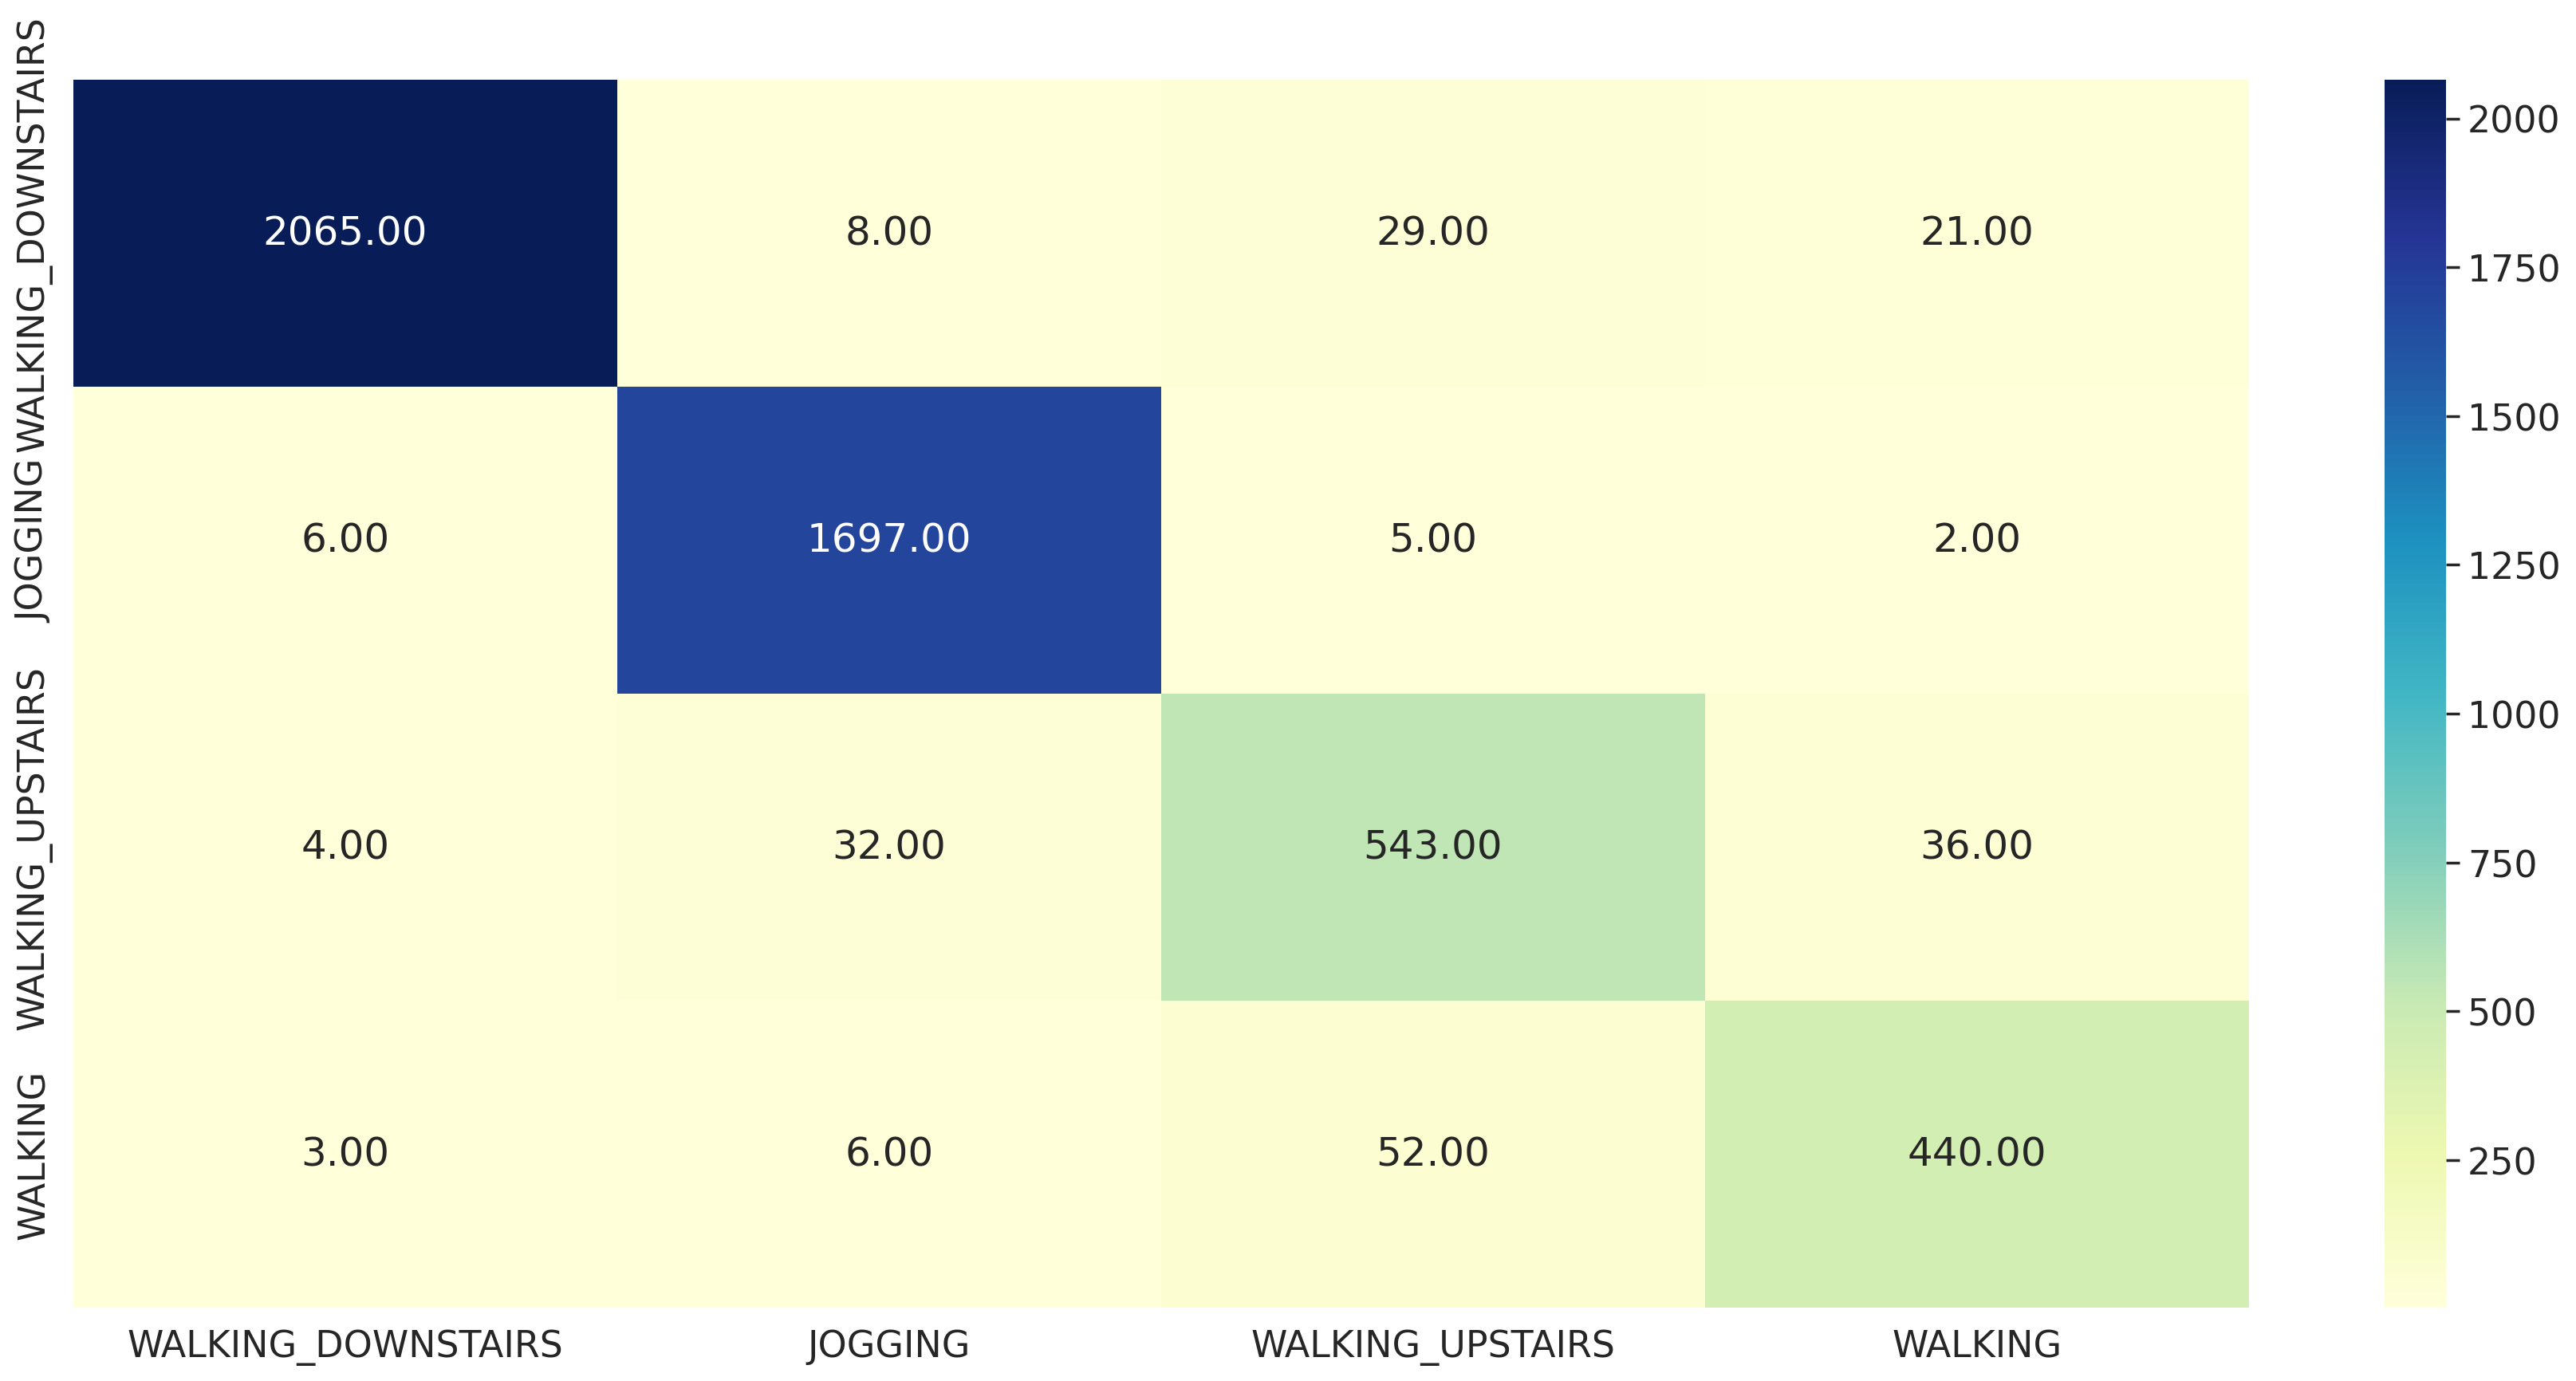

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, None, 48, 64)      640       
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, None, 46, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, None, 46, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, None, 23, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_8 (TimeDi  (None, None, 1472)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 25s 174ms/step - loss: 0.6524 - accuracy: 0.7515 - val_loss: 0.3691 - val_accuracy: 0.8669
Epoch 2/10
124/124 [==============================] - 23s 183ms/step - loss: 0.3133 - accuracy: 0.8731 - val_loss: 0.3023 - val_accuracy: 0.8853
Epoch 3/10
124/124 [==============================] - 23s 184ms/step - loss: 0.2111 - accuracy: 0.9161 - val_loss: 0.1606 - val_accuracy: 0.9477
Epoch 4/10
124/124 [==============================] - 21s 169ms/step - loss: 0.1555 - accuracy: 0.9413 - val_loss: 0.1311 - val_accuracy: 0.9535
Epoch 5/10
124/124 [==============================] - 21s 167ms/step - loss: 0.1225 - accuracy: 0.9559 - val_loss: 0.1227 - val_accuracy: 0.9593
Epoch 6/10
124/124 [==============================] - 21s 169ms/step - loss: 0.1008 - accuracy: 0.9643 - val_loss: 0.1159 - val_accuracy: 0.9611
Epoch 7/10
124/124 [==============================] - 22s 180ms/step - loss: 0.0861 - accuracy: 0.9697 - val_loss: 0.0951 - val_ac

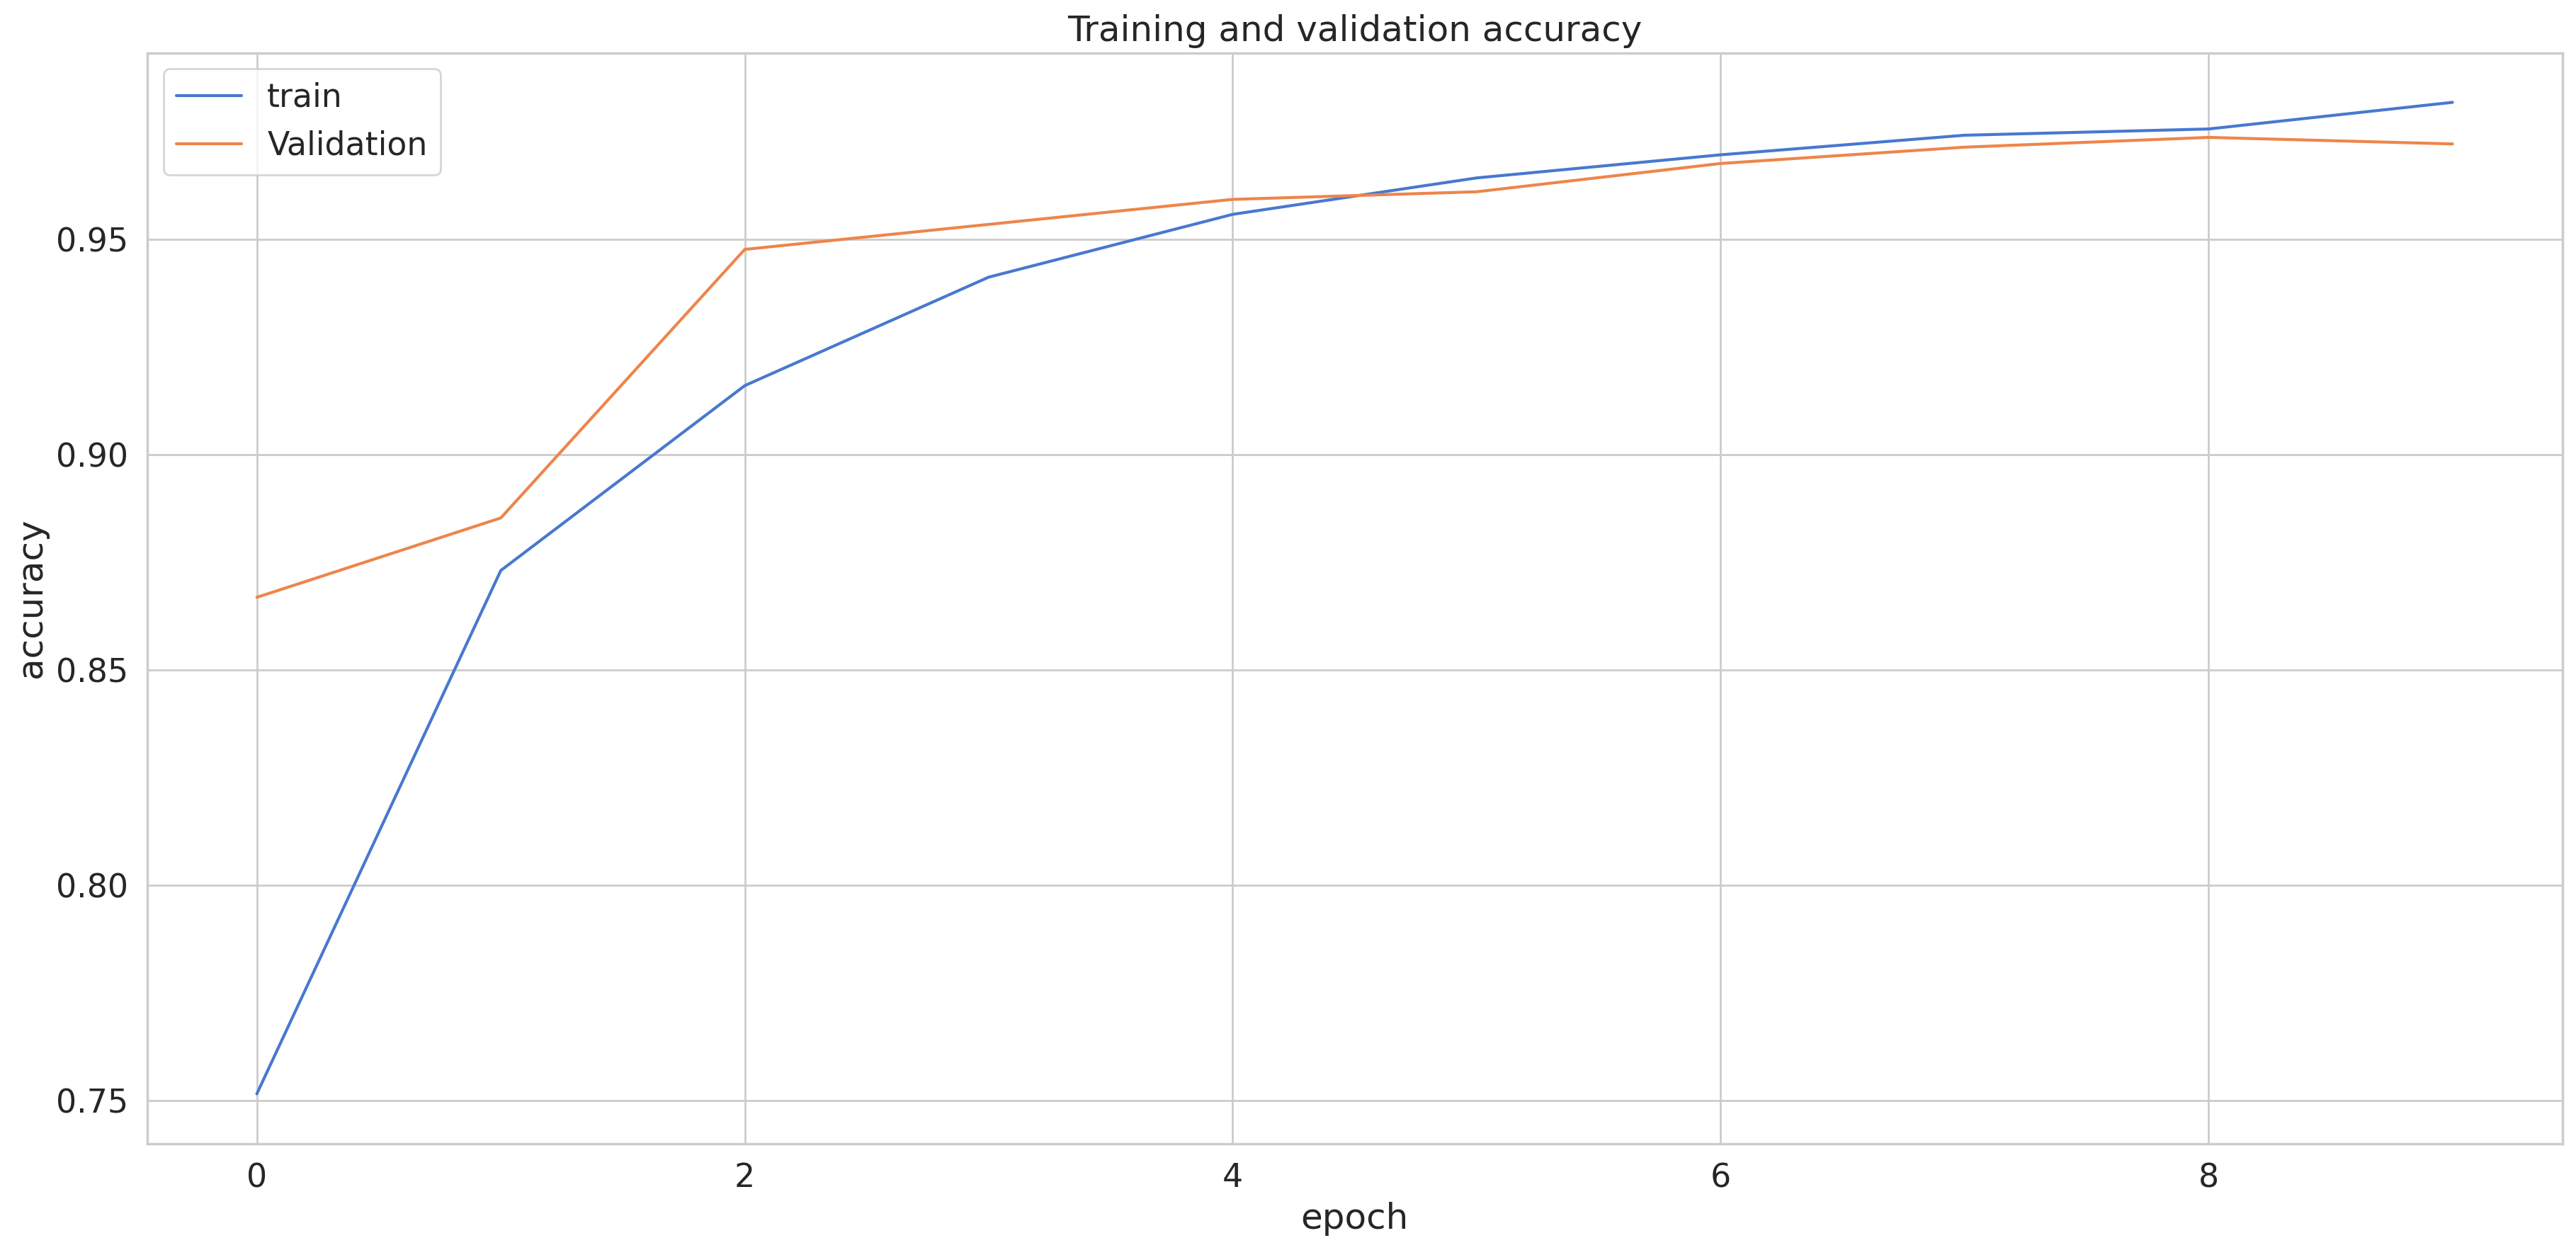

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

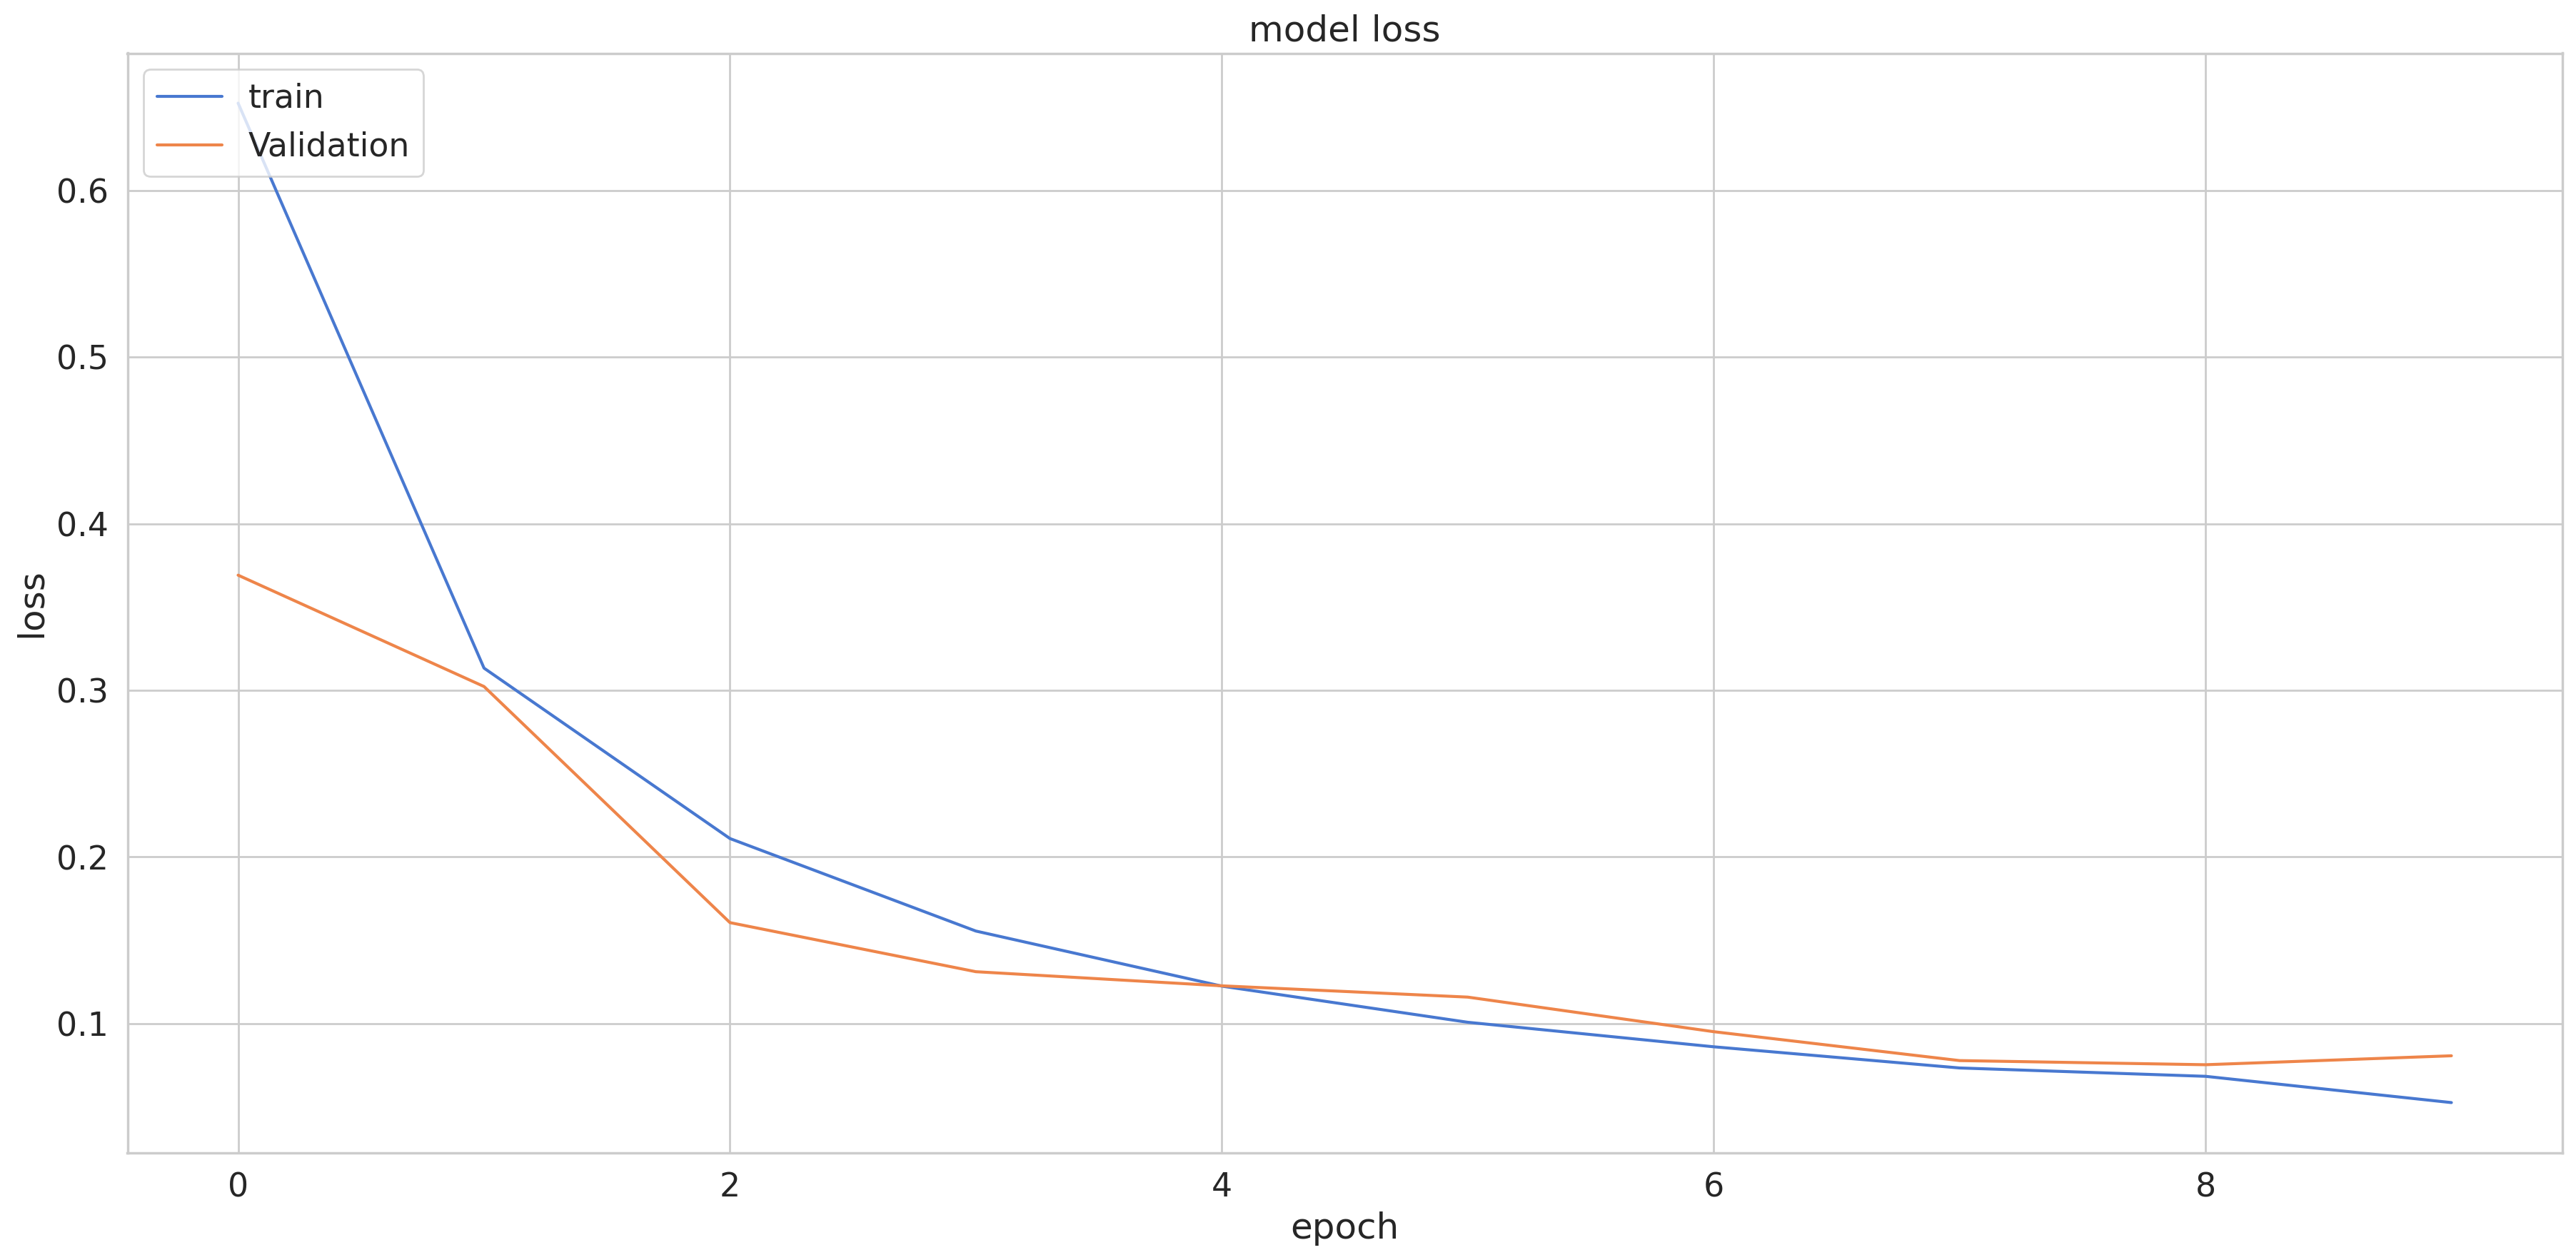

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 3s 15ms/step
f1_score =  0.9701480392555271
0.9704990907253991
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2123
           1       0.99      0.99      0.99      1710
           2       0.96      0.85      0.90       615
           3       0.88      0.96      0.92       501

    accuracy                           0.97      4949
   macro avg       0.95      0.95      0.95      4949
weighted avg       0.97      0.97      0.97      4949



<Axes: >

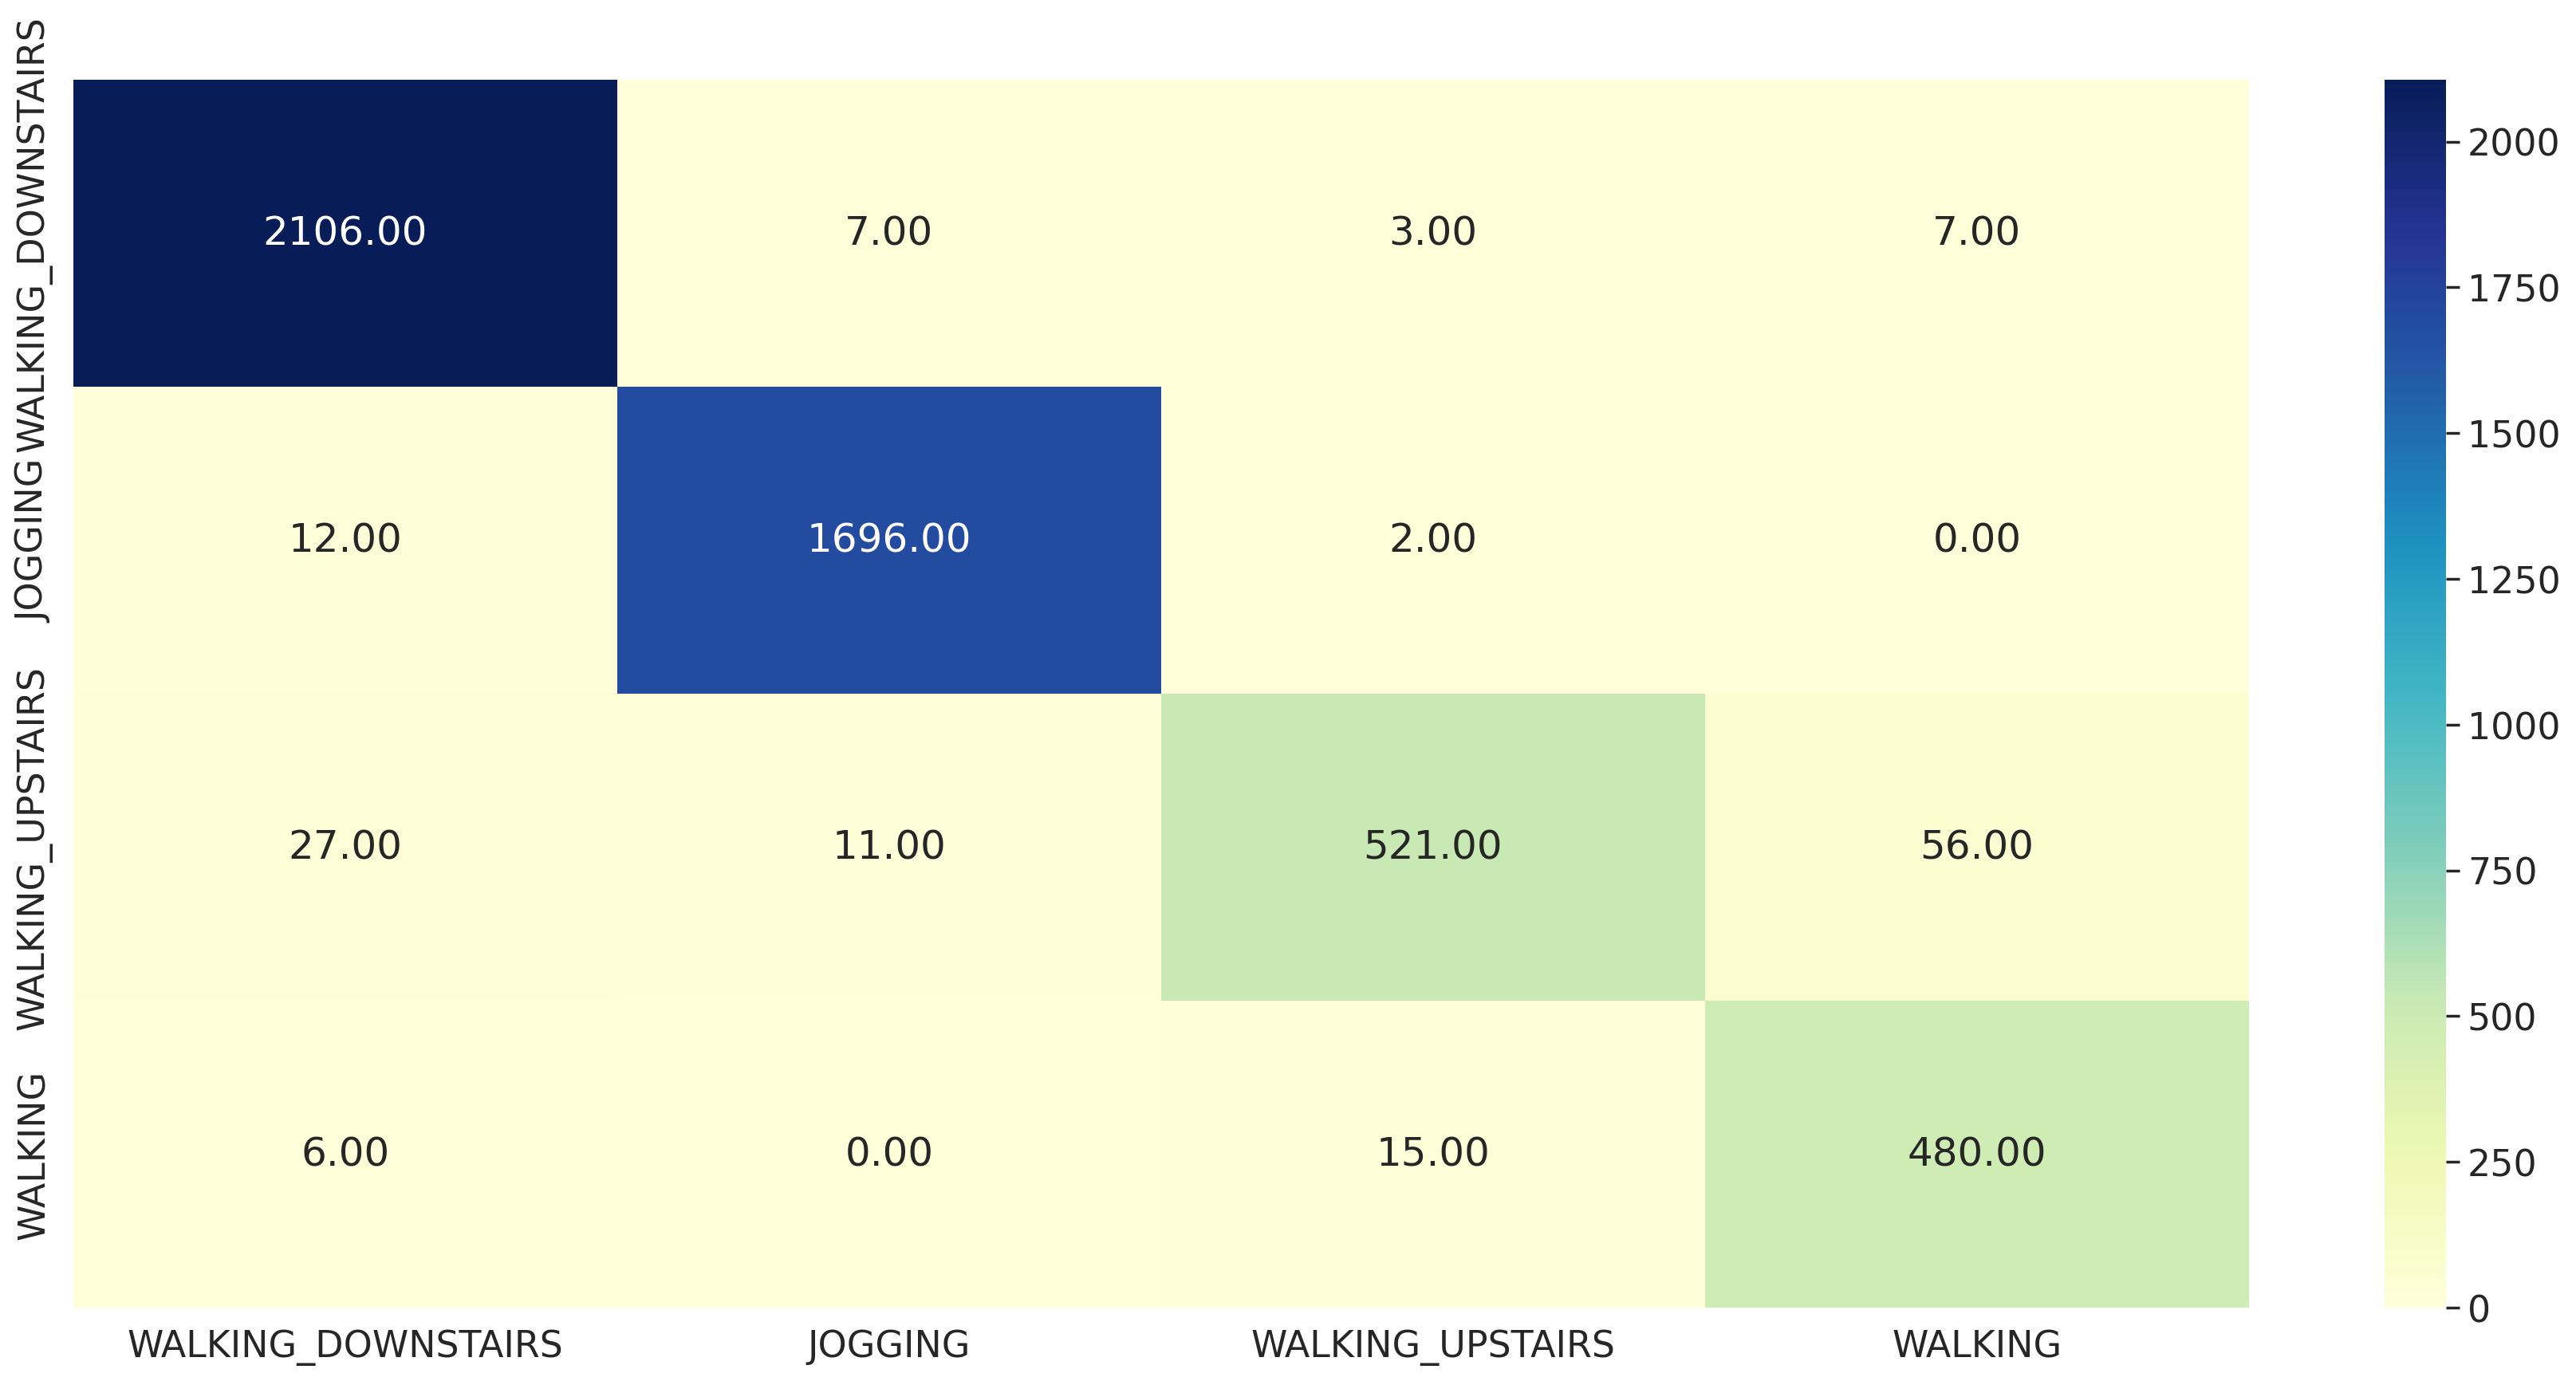

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# layer 4

# CNN1 - LSTM3

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDi  (None, None, 48, 64)      640       
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 48, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 24, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, None, 1536)        0         
 istributed)                                                     
                                                                 
 lstm_3 (LSTM)               (None, None, 100)        

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 28s 165ms/step - loss: 0.7398 - accuracy: 0.7191 - val_loss: 0.4682 - val_accuracy: 0.8133
Epoch 2/10
124/124 [==============================] - 19s 154ms/step - loss: 0.4127 - accuracy: 0.8395 - val_loss: 0.3029 - val_accuracy: 0.8740
Epoch 3/10
124/124 [==============================] - 19s 152ms/step - loss: 0.3133 - accuracy: 0.8655 - val_loss: 0.2696 - val_accuracy: 0.9005
Epoch 4/10
124/124 [==============================] - 19s 153ms/step - loss: 0.2517 - accuracy: 0.8971 - val_loss: 0.2107 - val_accuracy: 0.9230
Epoch 5/10
124/124 [==============================] - 18s 149ms/step - loss: 0.2137 - accuracy: 0.9174 - val_loss: 0.2086 - val_accuracy: 0.9257
Epoch 6/10
124/124 [==============================] - 18s 148ms/step - loss: 0.1701 - accuracy: 0.9403 - val_loss: 0.1733 - val_accuracy: 0.9409
Epoch 7/10
124/124 [==============================] - 18s 147ms/step - loss: 0.1424 - accuracy: 0.9502 - val_loss: 0.1427 - val_ac

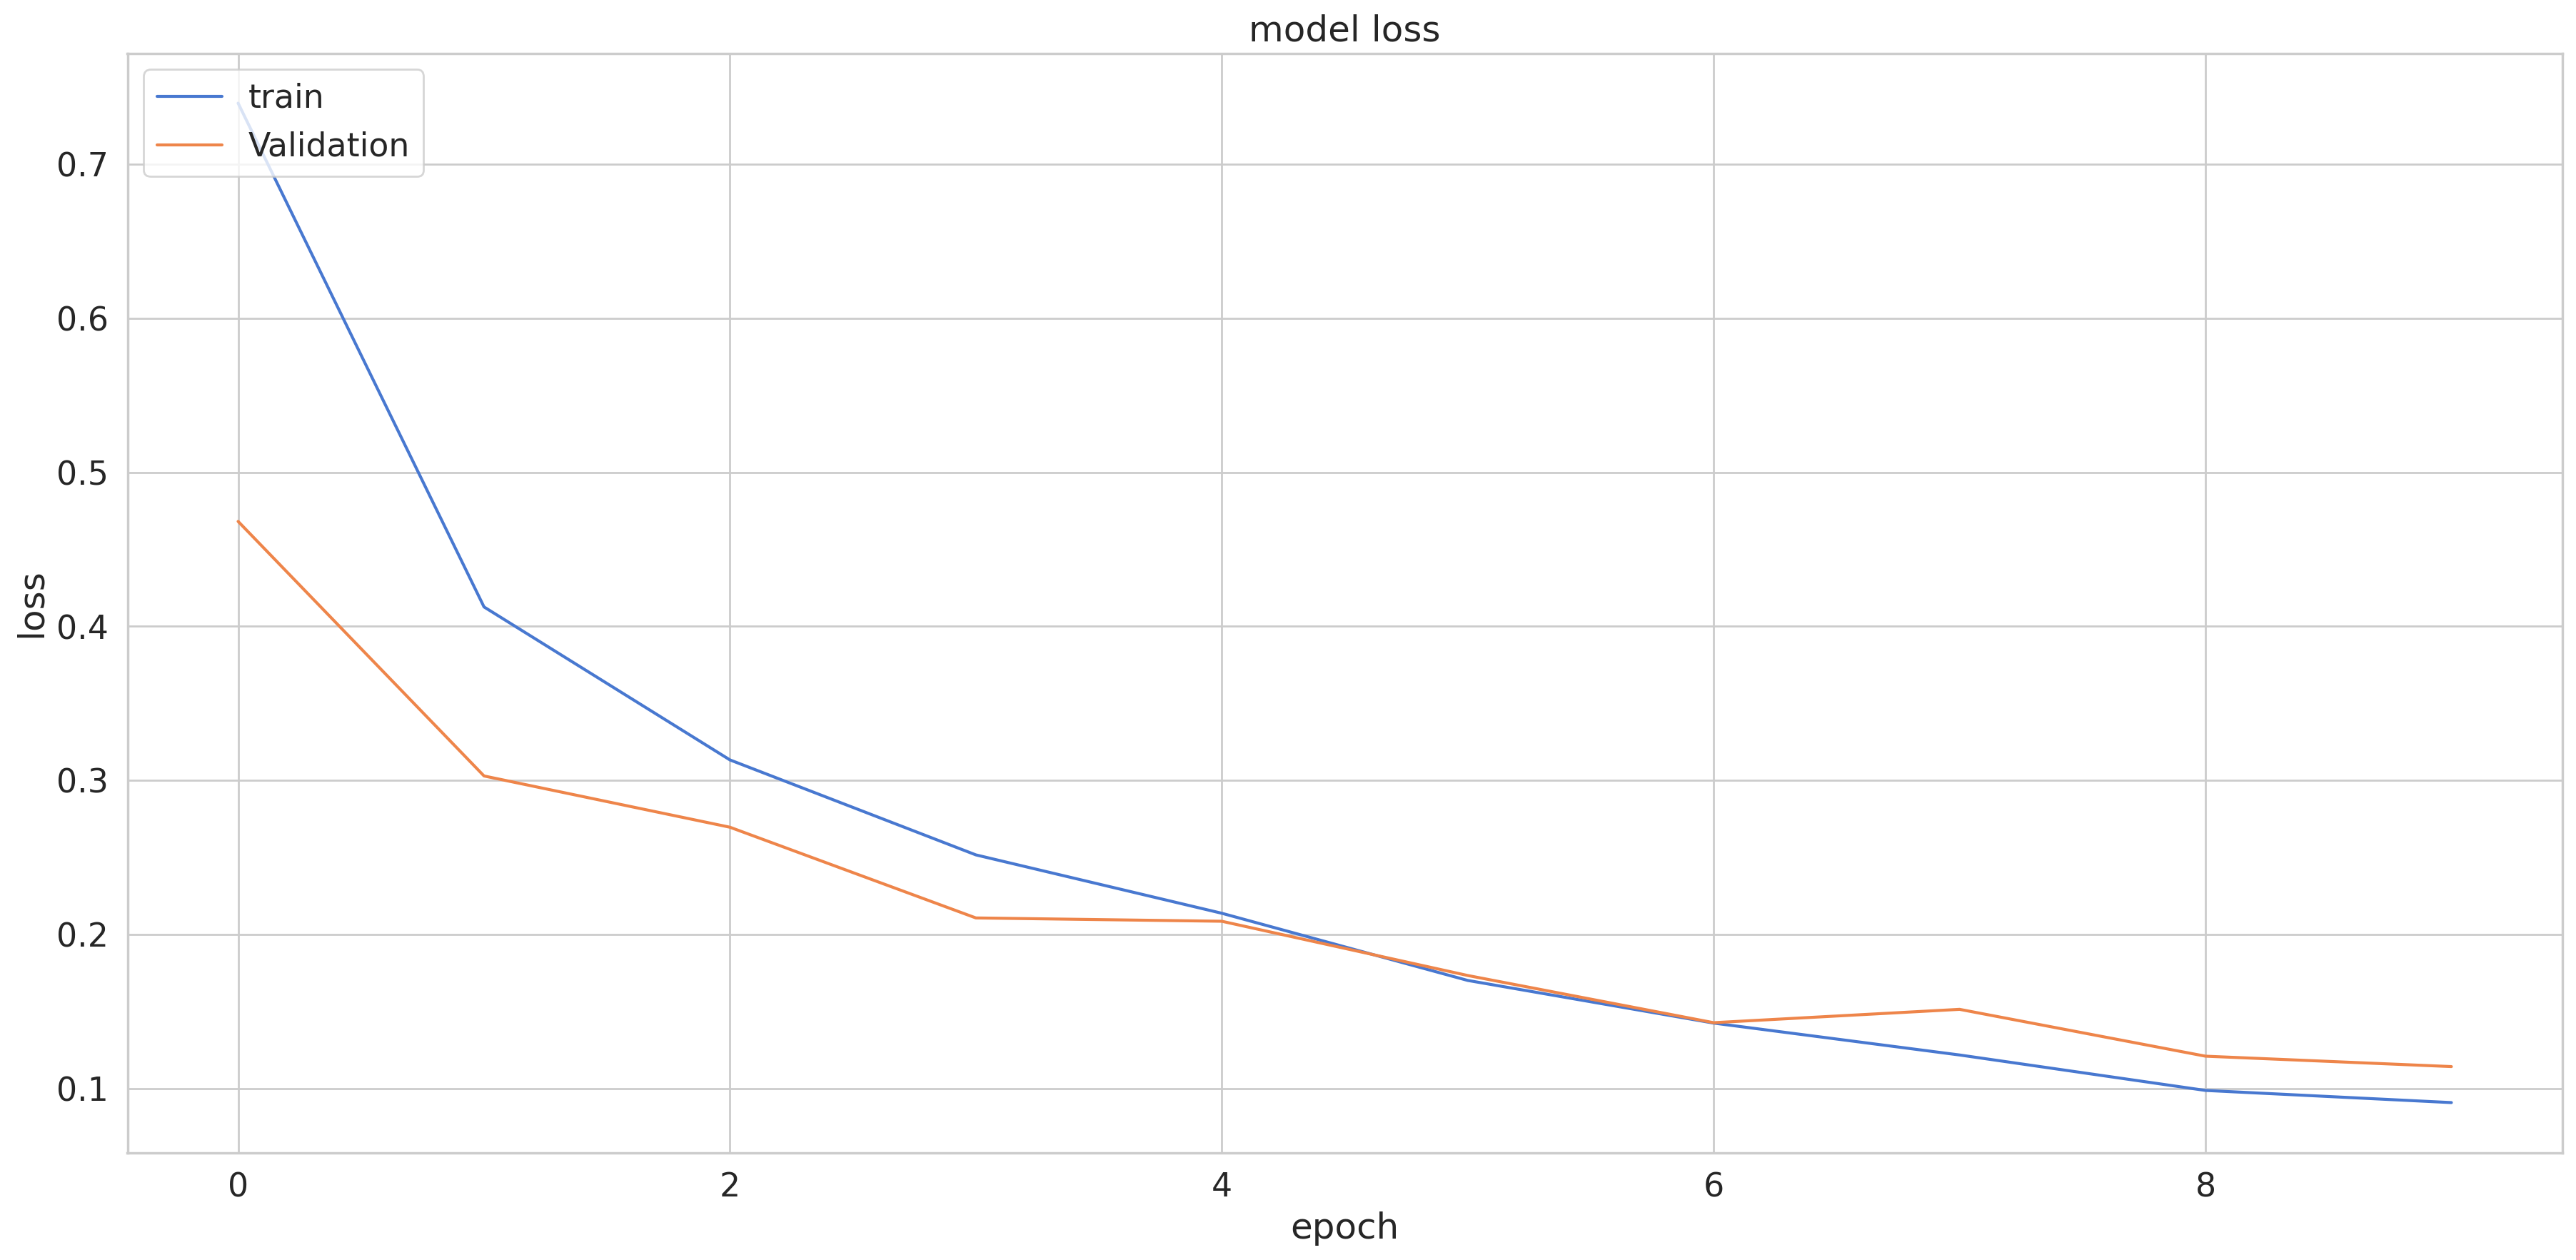

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

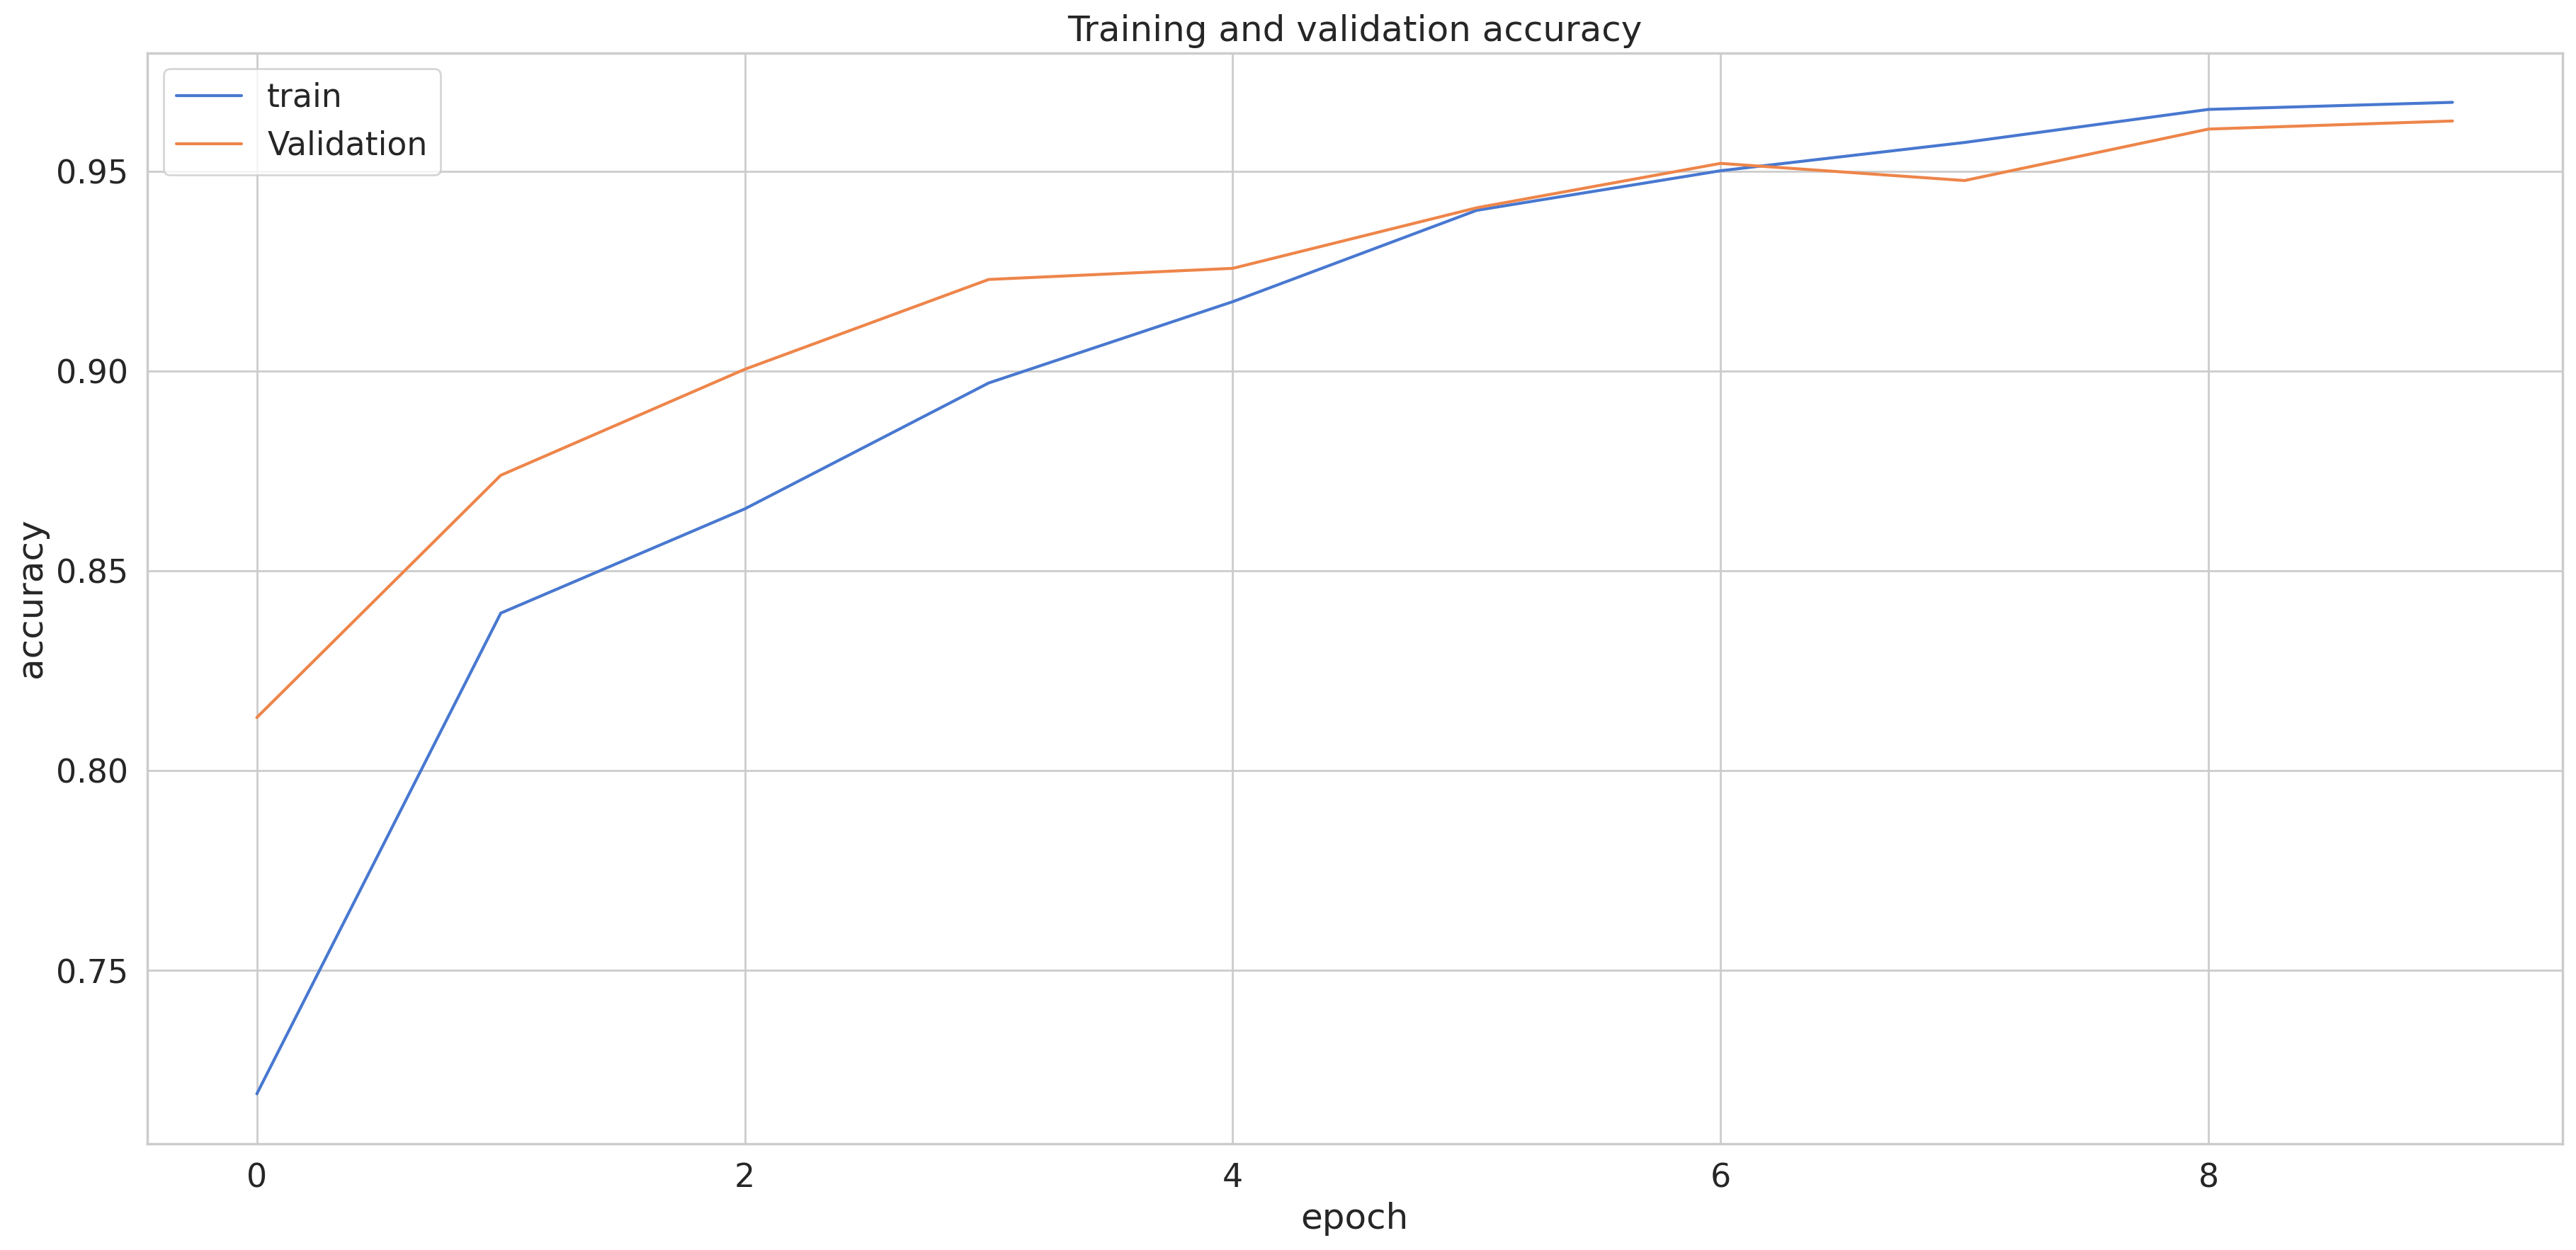

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 4s 15ms/step
f1_score =  0.958296464949455
0.9583754293796727
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2123
           1       0.98      0.99      0.98      1710
           2       0.88      0.84      0.86       615
           3       0.85      0.90      0.87       501

    accuracy                           0.96      4949
   macro avg       0.93      0.93      0.93      4949
weighted avg       0.96      0.96      0.96      4949



<Axes: >

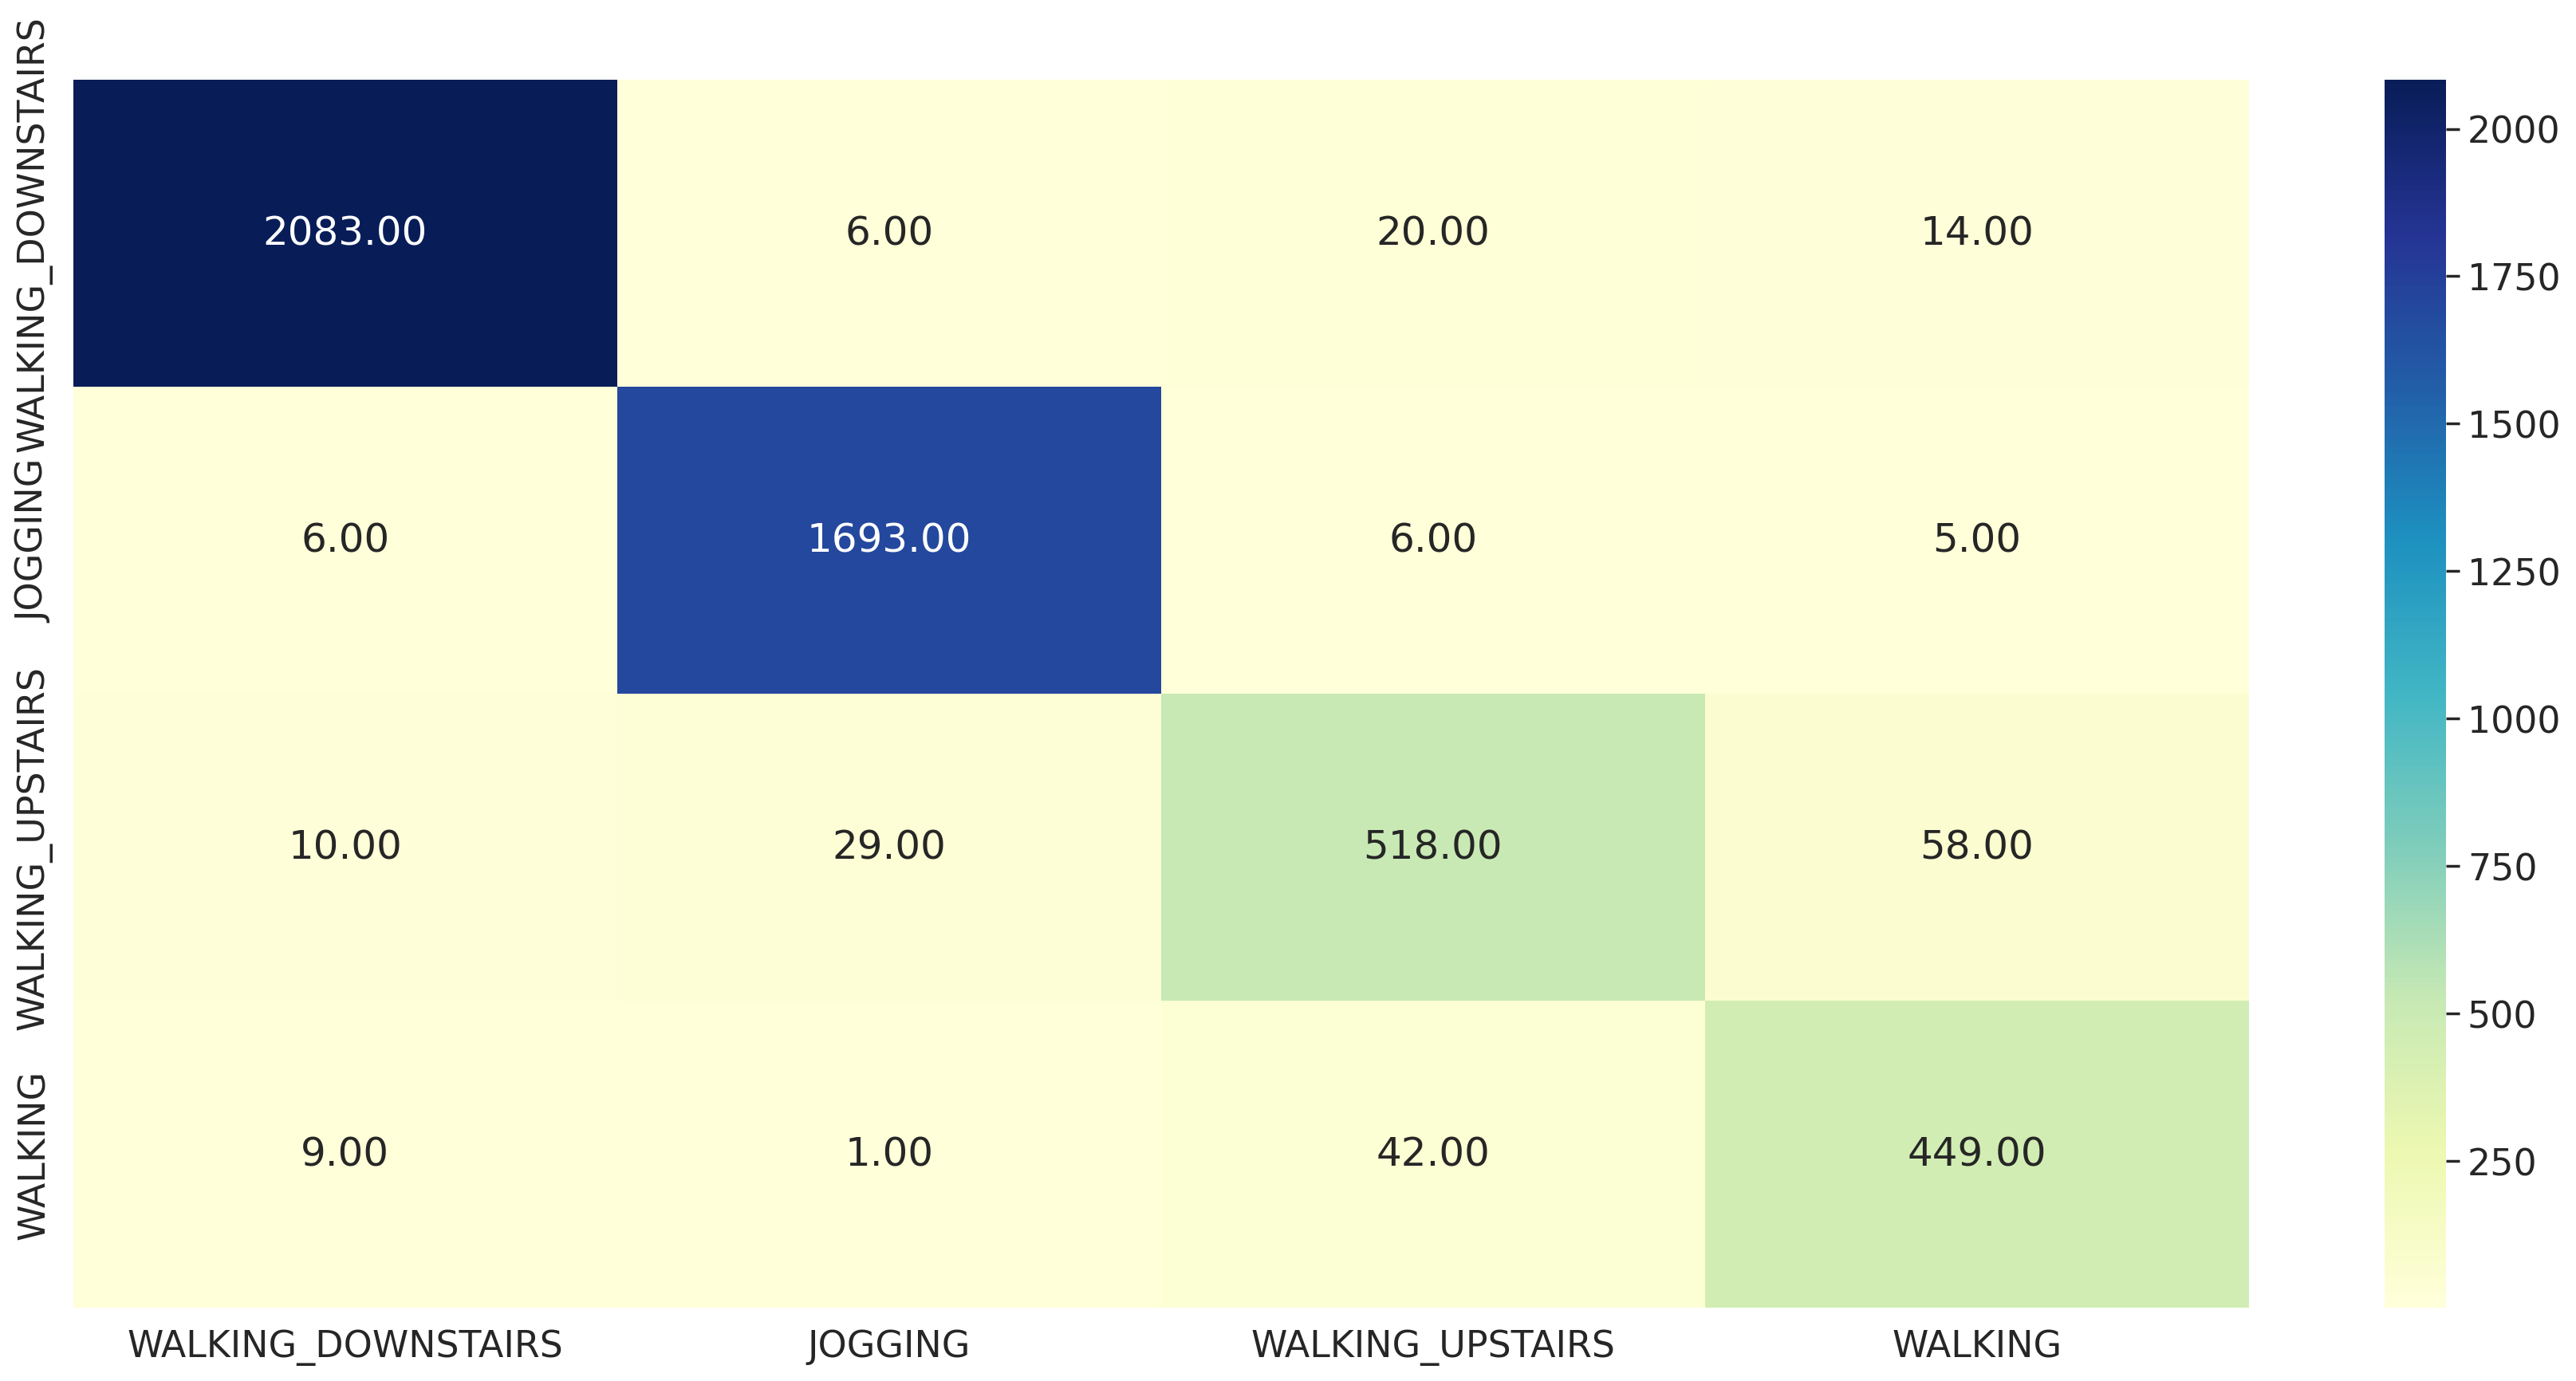

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 -LSTM2

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, None, 48, 64)      640       
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, None, 46, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, None, 46, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, None, 23, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, None, 1472)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 33s 217ms/step - loss: 0.6279 - accuracy: 0.7552 - val_loss: 0.3629 - val_accuracy: 0.8646
Epoch 2/10
124/124 [==============================] - 23s 182ms/step - loss: 0.3113 - accuracy: 0.8676 - val_loss: 0.2485 - val_accuracy: 0.8914
Epoch 3/10
124/124 [==============================] - 22s 180ms/step - loss: 0.2443 - accuracy: 0.8974 - val_loss: 0.2028 - val_accuracy: 0.9308
Epoch 4/10
124/124 [==============================] - 25s 201ms/step - loss: 0.1860 - accuracy: 0.9274 - val_loss: 0.1871 - val_accuracy: 0.9247
Epoch 5/10
124/124 [==============================] - 23s 187ms/step - loss: 0.1444 - accuracy: 0.9471 - val_loss: 0.1187 - val_accuracy: 0.9601
Epoch 6/10
124/124 [==============================] - 22s 178ms/step - loss: 0.1242 - accuracy: 0.9549 - val_loss: 0.1129 - val_accuracy: 0.9616
Epoch 7/10
124/124 [==============================] - 24s 190ms/step - loss: 0.1029 - accuracy: 0.9619 - val_loss: 0.0885 - val_ac

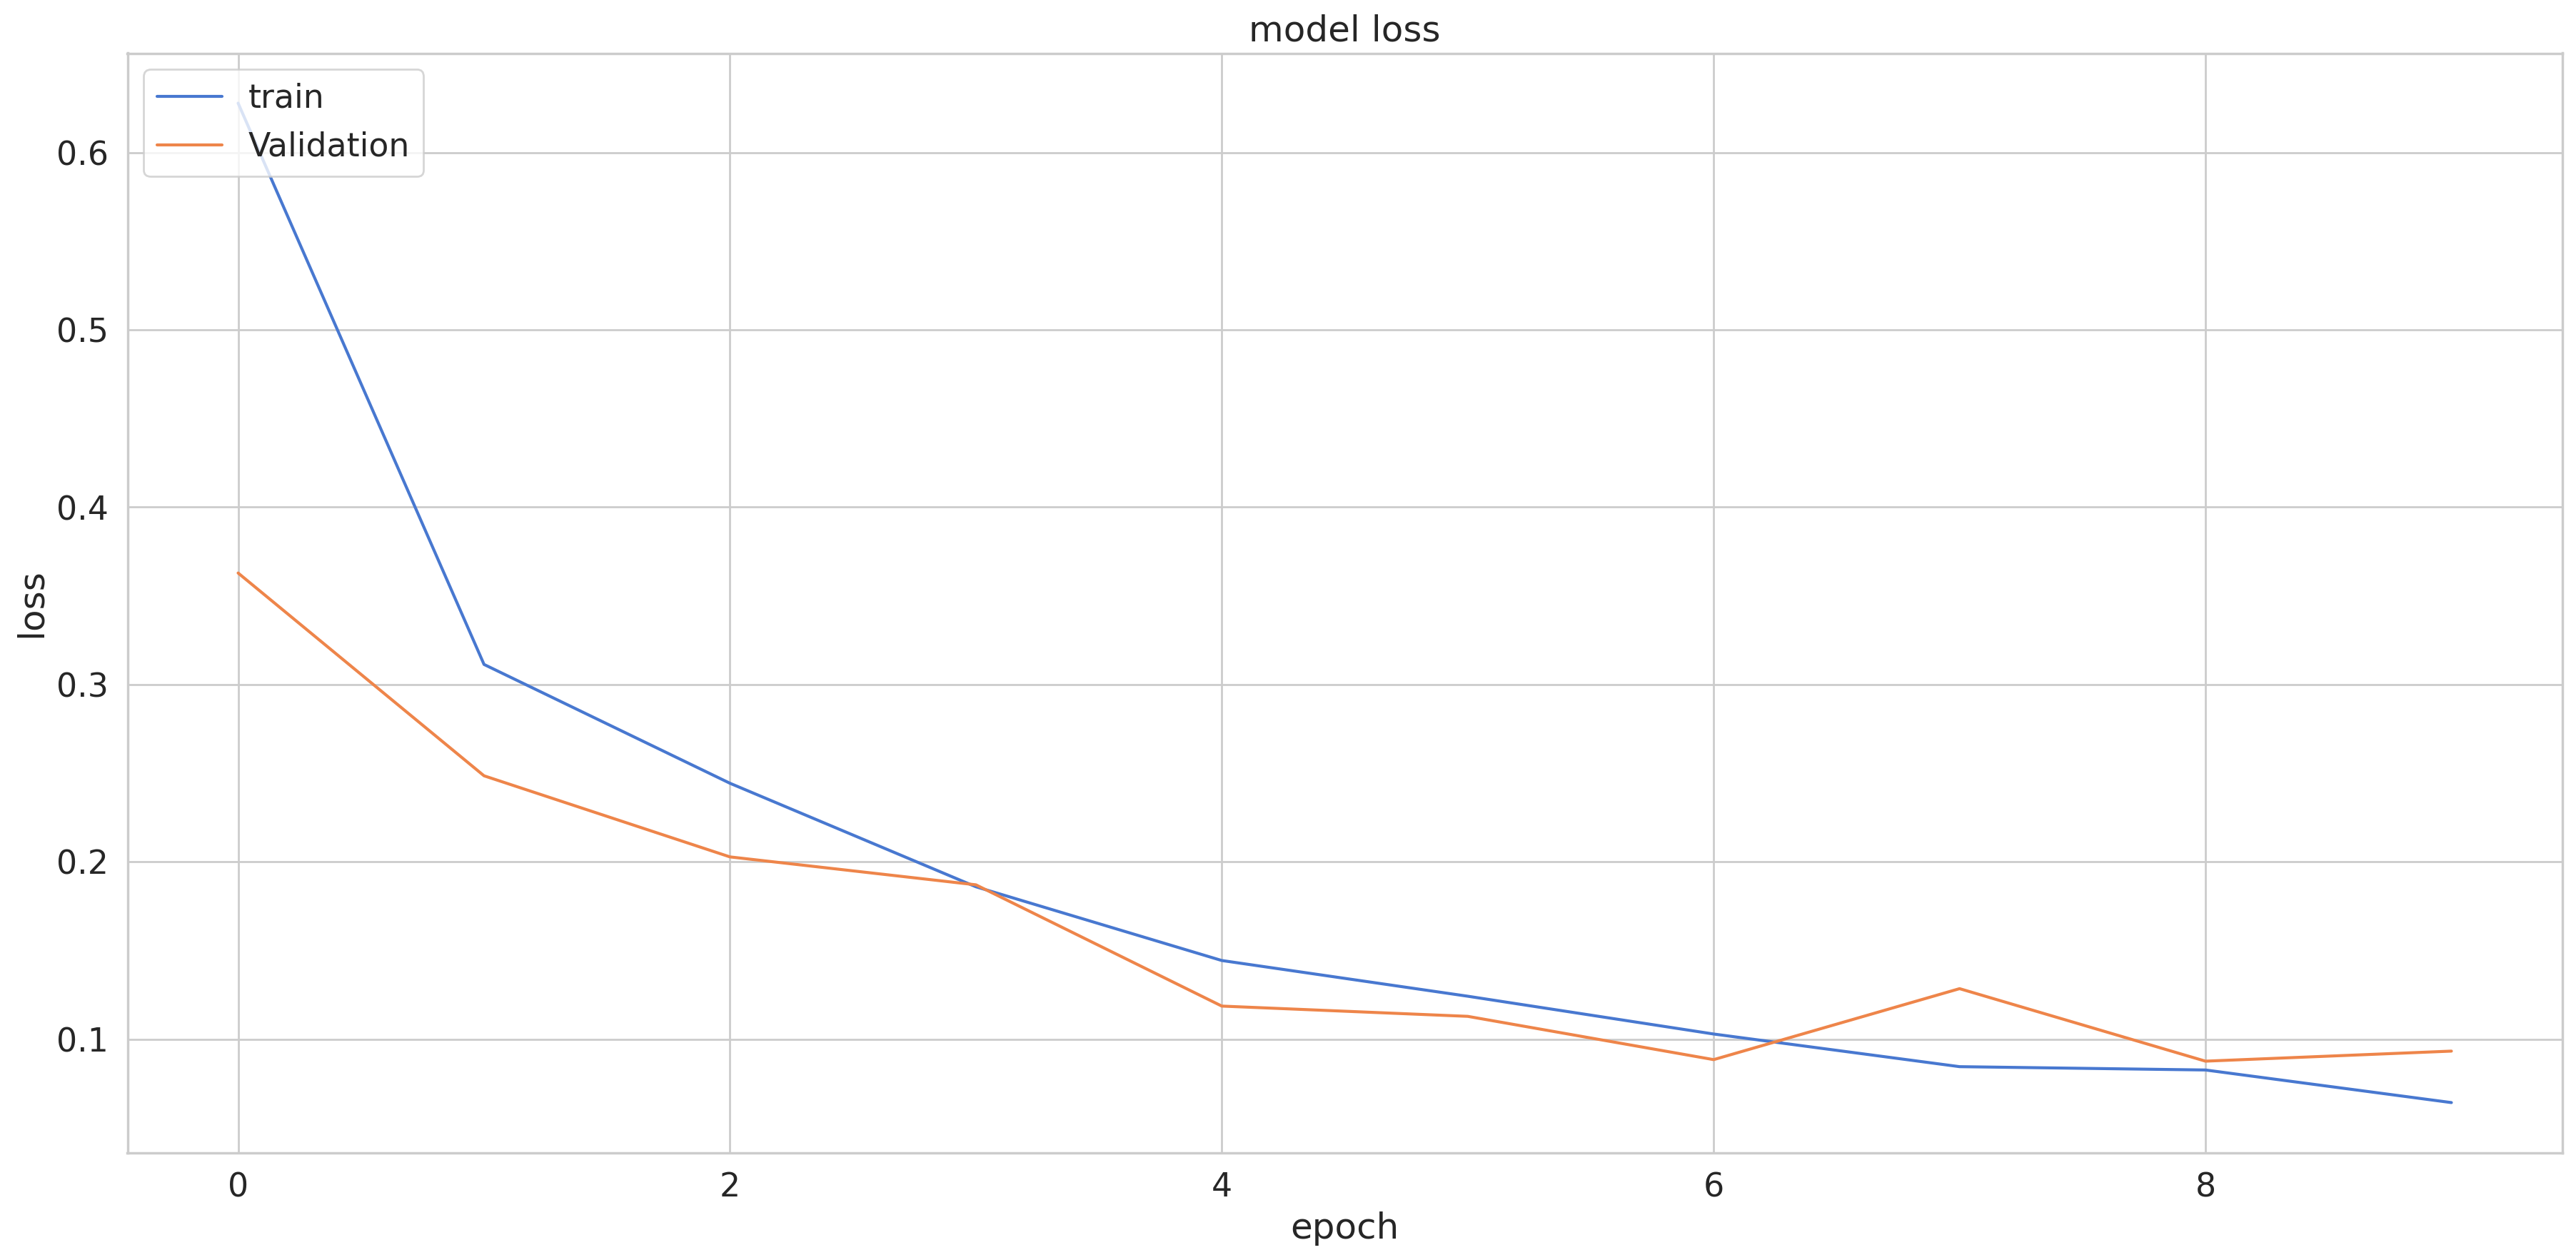

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

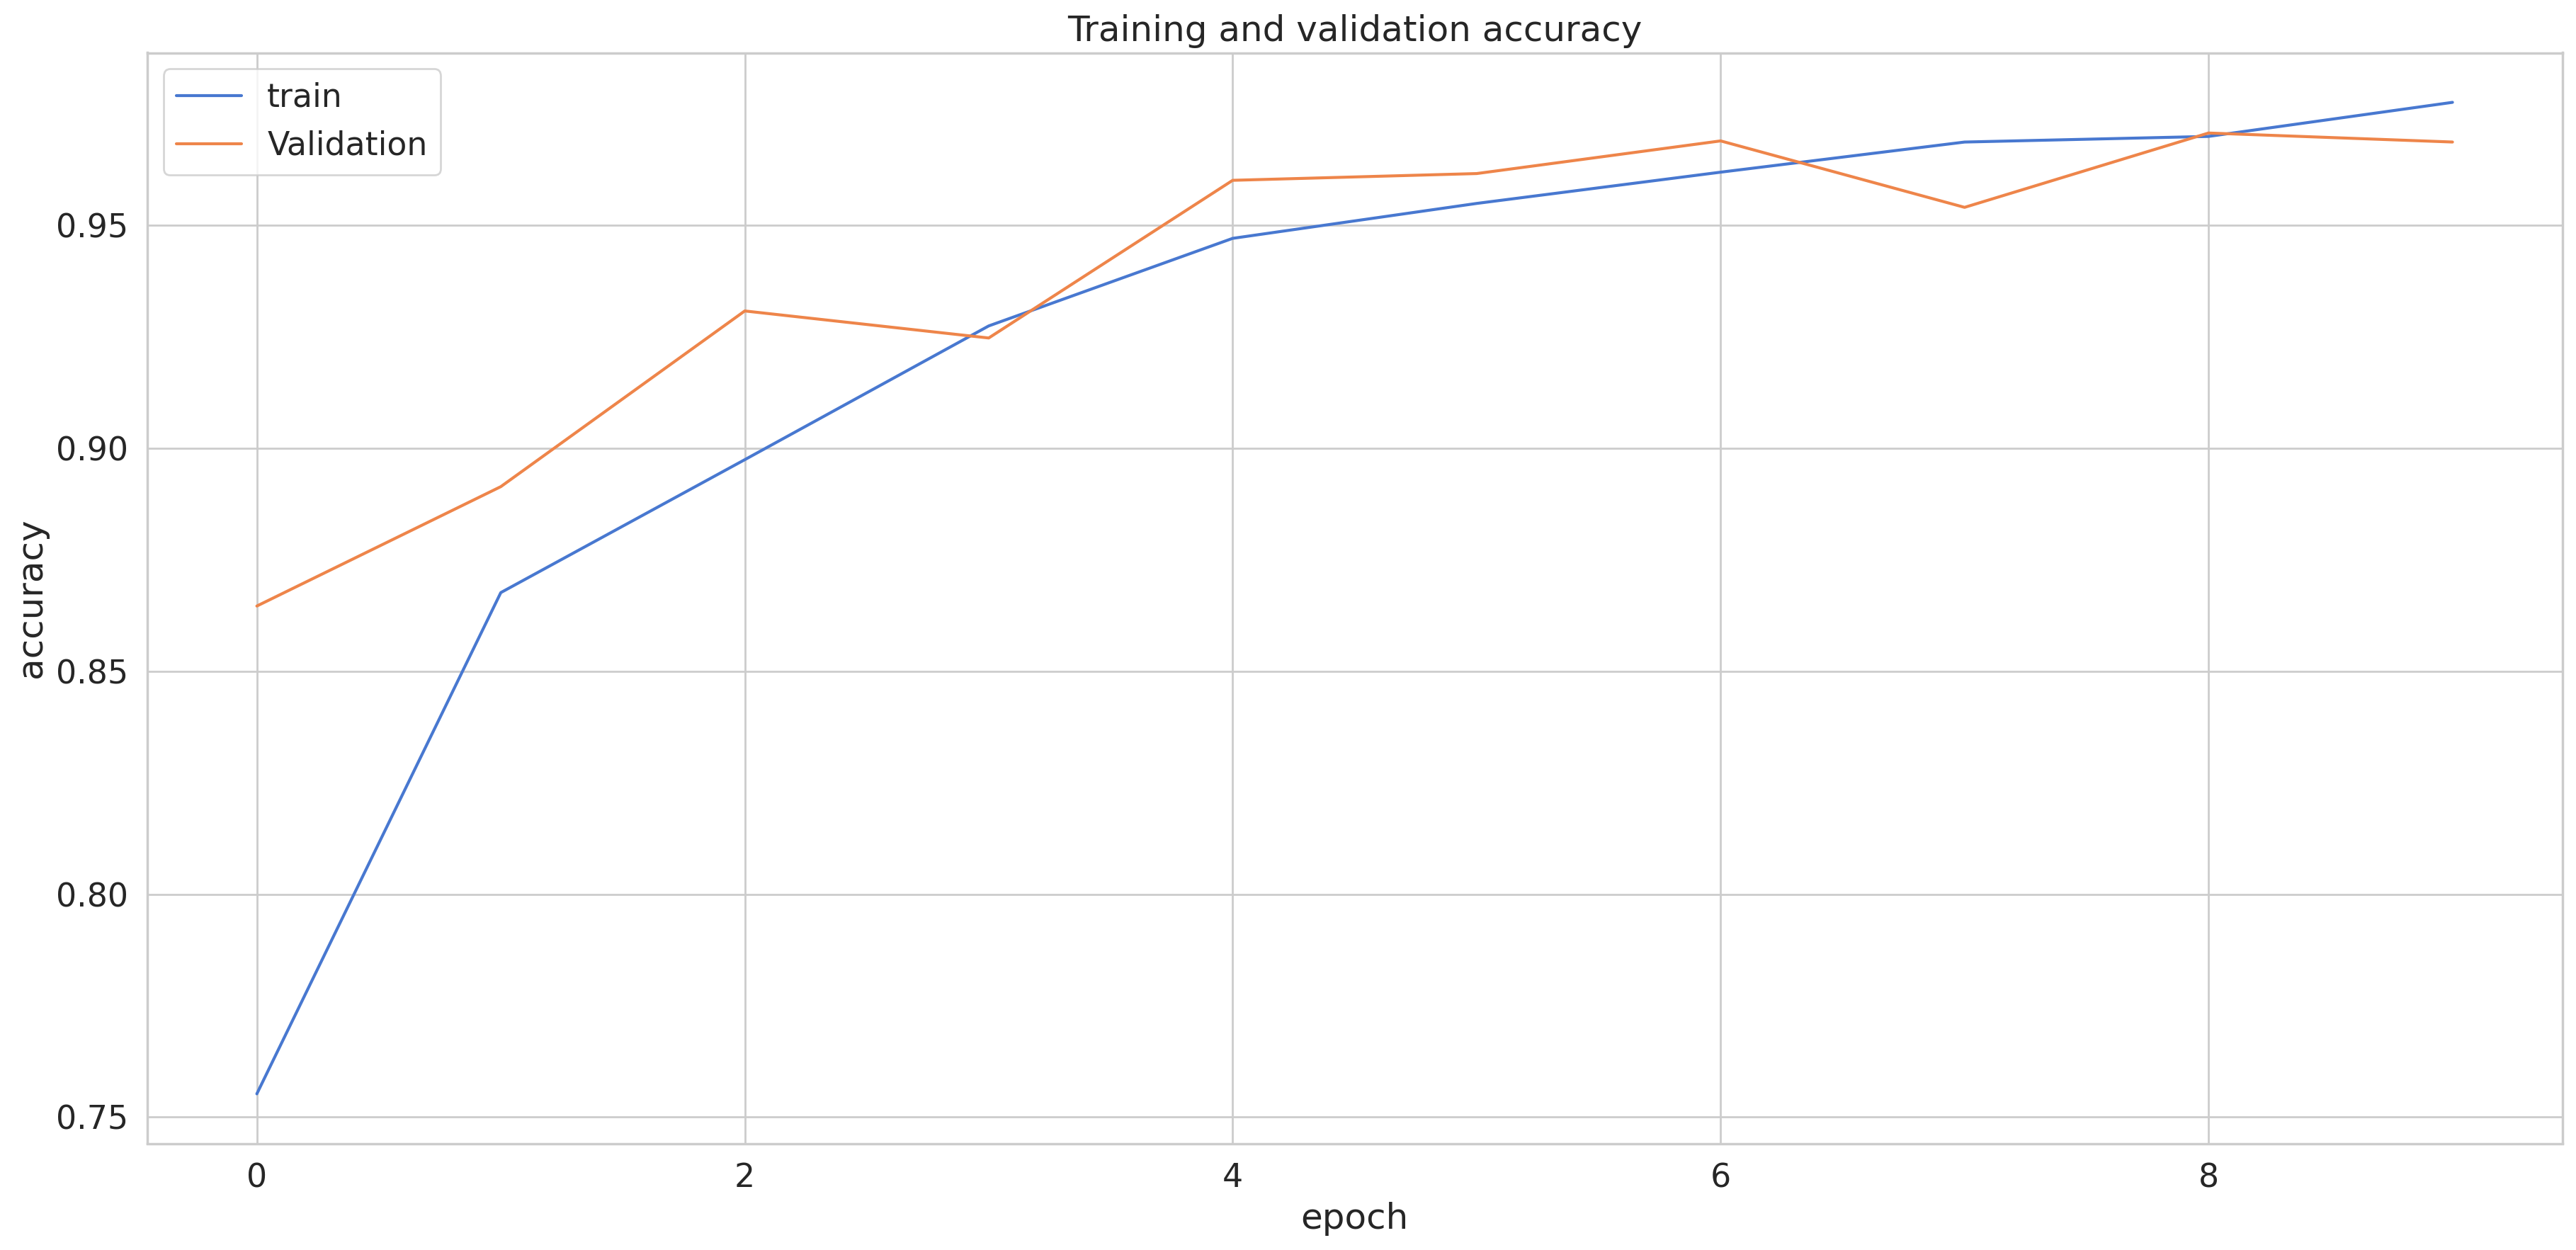

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 4s 22ms/step
f1_score =  0.9665048016664934
0.9666599312992524
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2123
           1       0.99      0.99      0.99      1710
           2       0.95      0.83      0.89       615
           3       0.84      0.96      0.90       501

    accuracy                           0.97      4949
   macro avg       0.94      0.94      0.94      4949
weighted avg       0.97      0.97      0.97      4949



<Axes: >

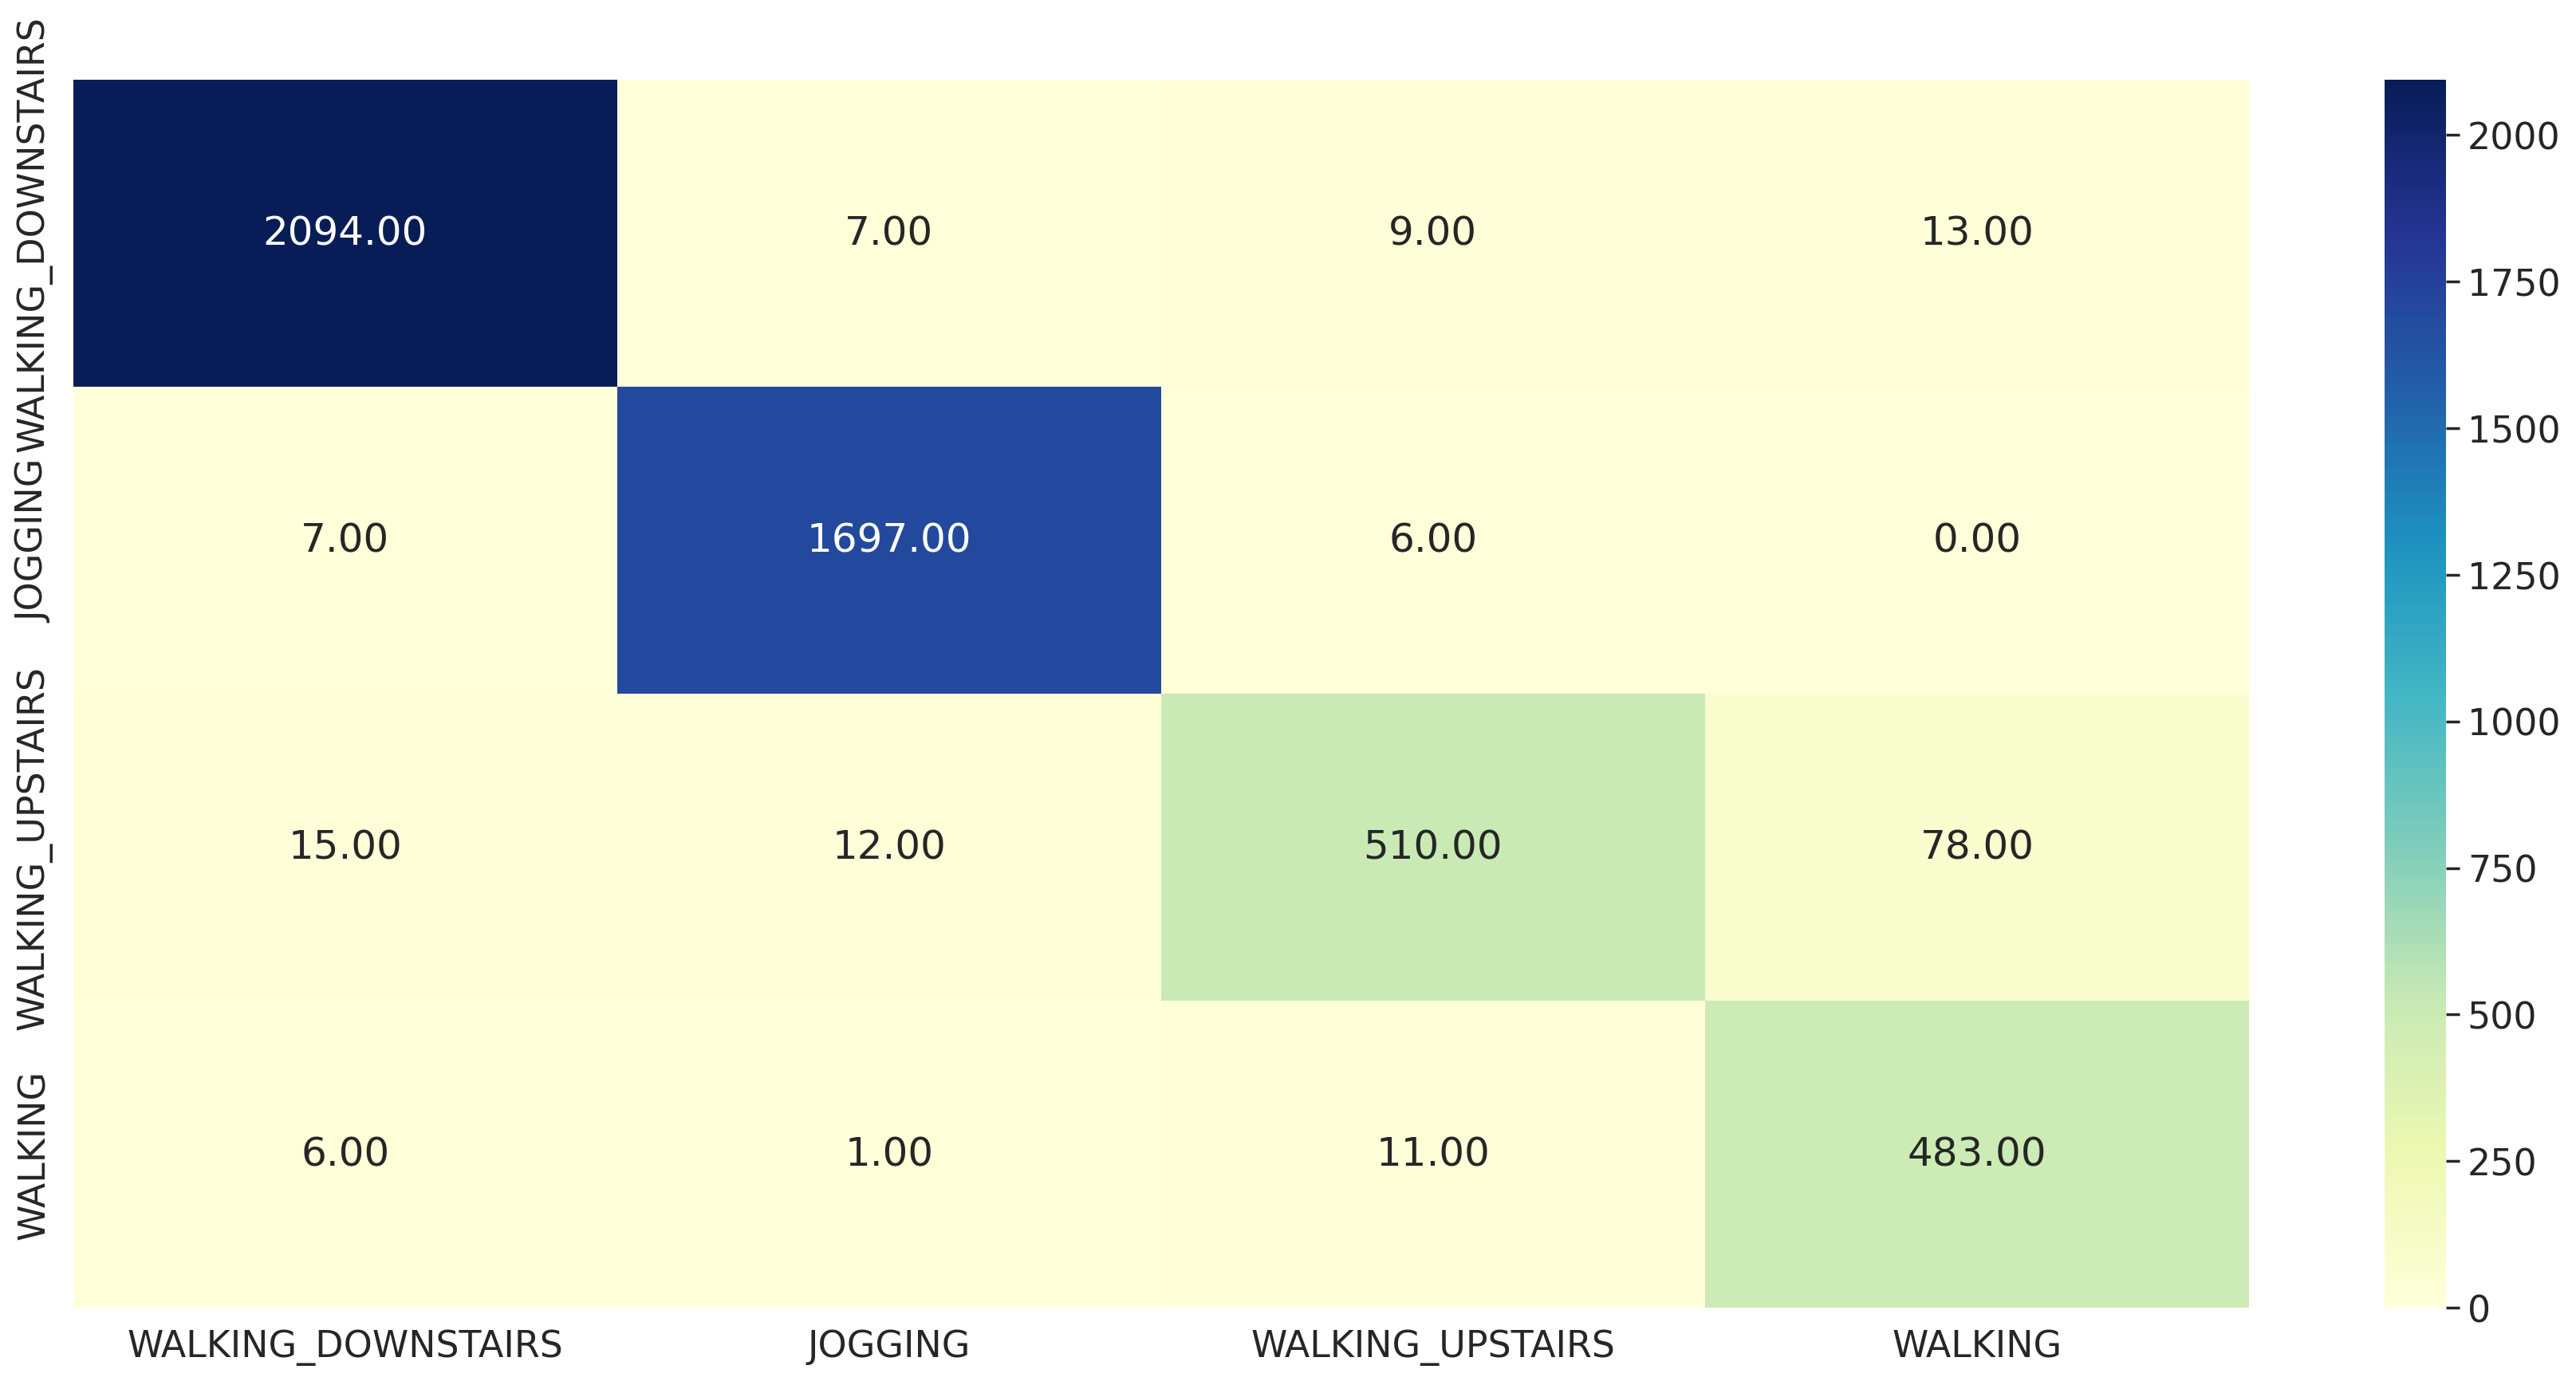

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN3 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 48, 64)      640       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 46, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 46, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, None, 23, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, None, 21, 64)      1

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 36s 197ms/step - loss: 0.6584 - accuracy: 0.7467 - val_loss: 0.4165 - val_accuracy: 0.8606
Epoch 2/10
124/124 [==============================] - 23s 182ms/step - loss: 0.3189 - accuracy: 0.8703 - val_loss: 0.3035 - val_accuracy: 0.8879
Epoch 3/10
124/124 [==============================] - 21s 170ms/step - loss: 0.2284 - accuracy: 0.9096 - val_loss: 0.5033 - val_accuracy: 0.8250
Epoch 4/10
124/124 [==============================] - 21s 166ms/step - loss: 0.1683 - accuracy: 0.9384 - val_loss: 0.3391 - val_accuracy: 0.8729
Epoch 5/10
124/124 [==============================] - 21s 170ms/step - loss: 0.1329 - accuracy: 0.9526 - val_loss: 0.2064 - val_accuracy: 0.9212
Epoch 6/10
124/124 [==============================] - 26s 208ms/step - loss: 0.1037 - accuracy: 0.9636 - val_loss: 0.2831 - val_accuracy: 0.8942
Epoch 7/10
124/124 [==============================] - 21s 170ms/step - loss: 0.0946 - accuracy: 0.9667 - val_loss: 0.3308 - val_ac

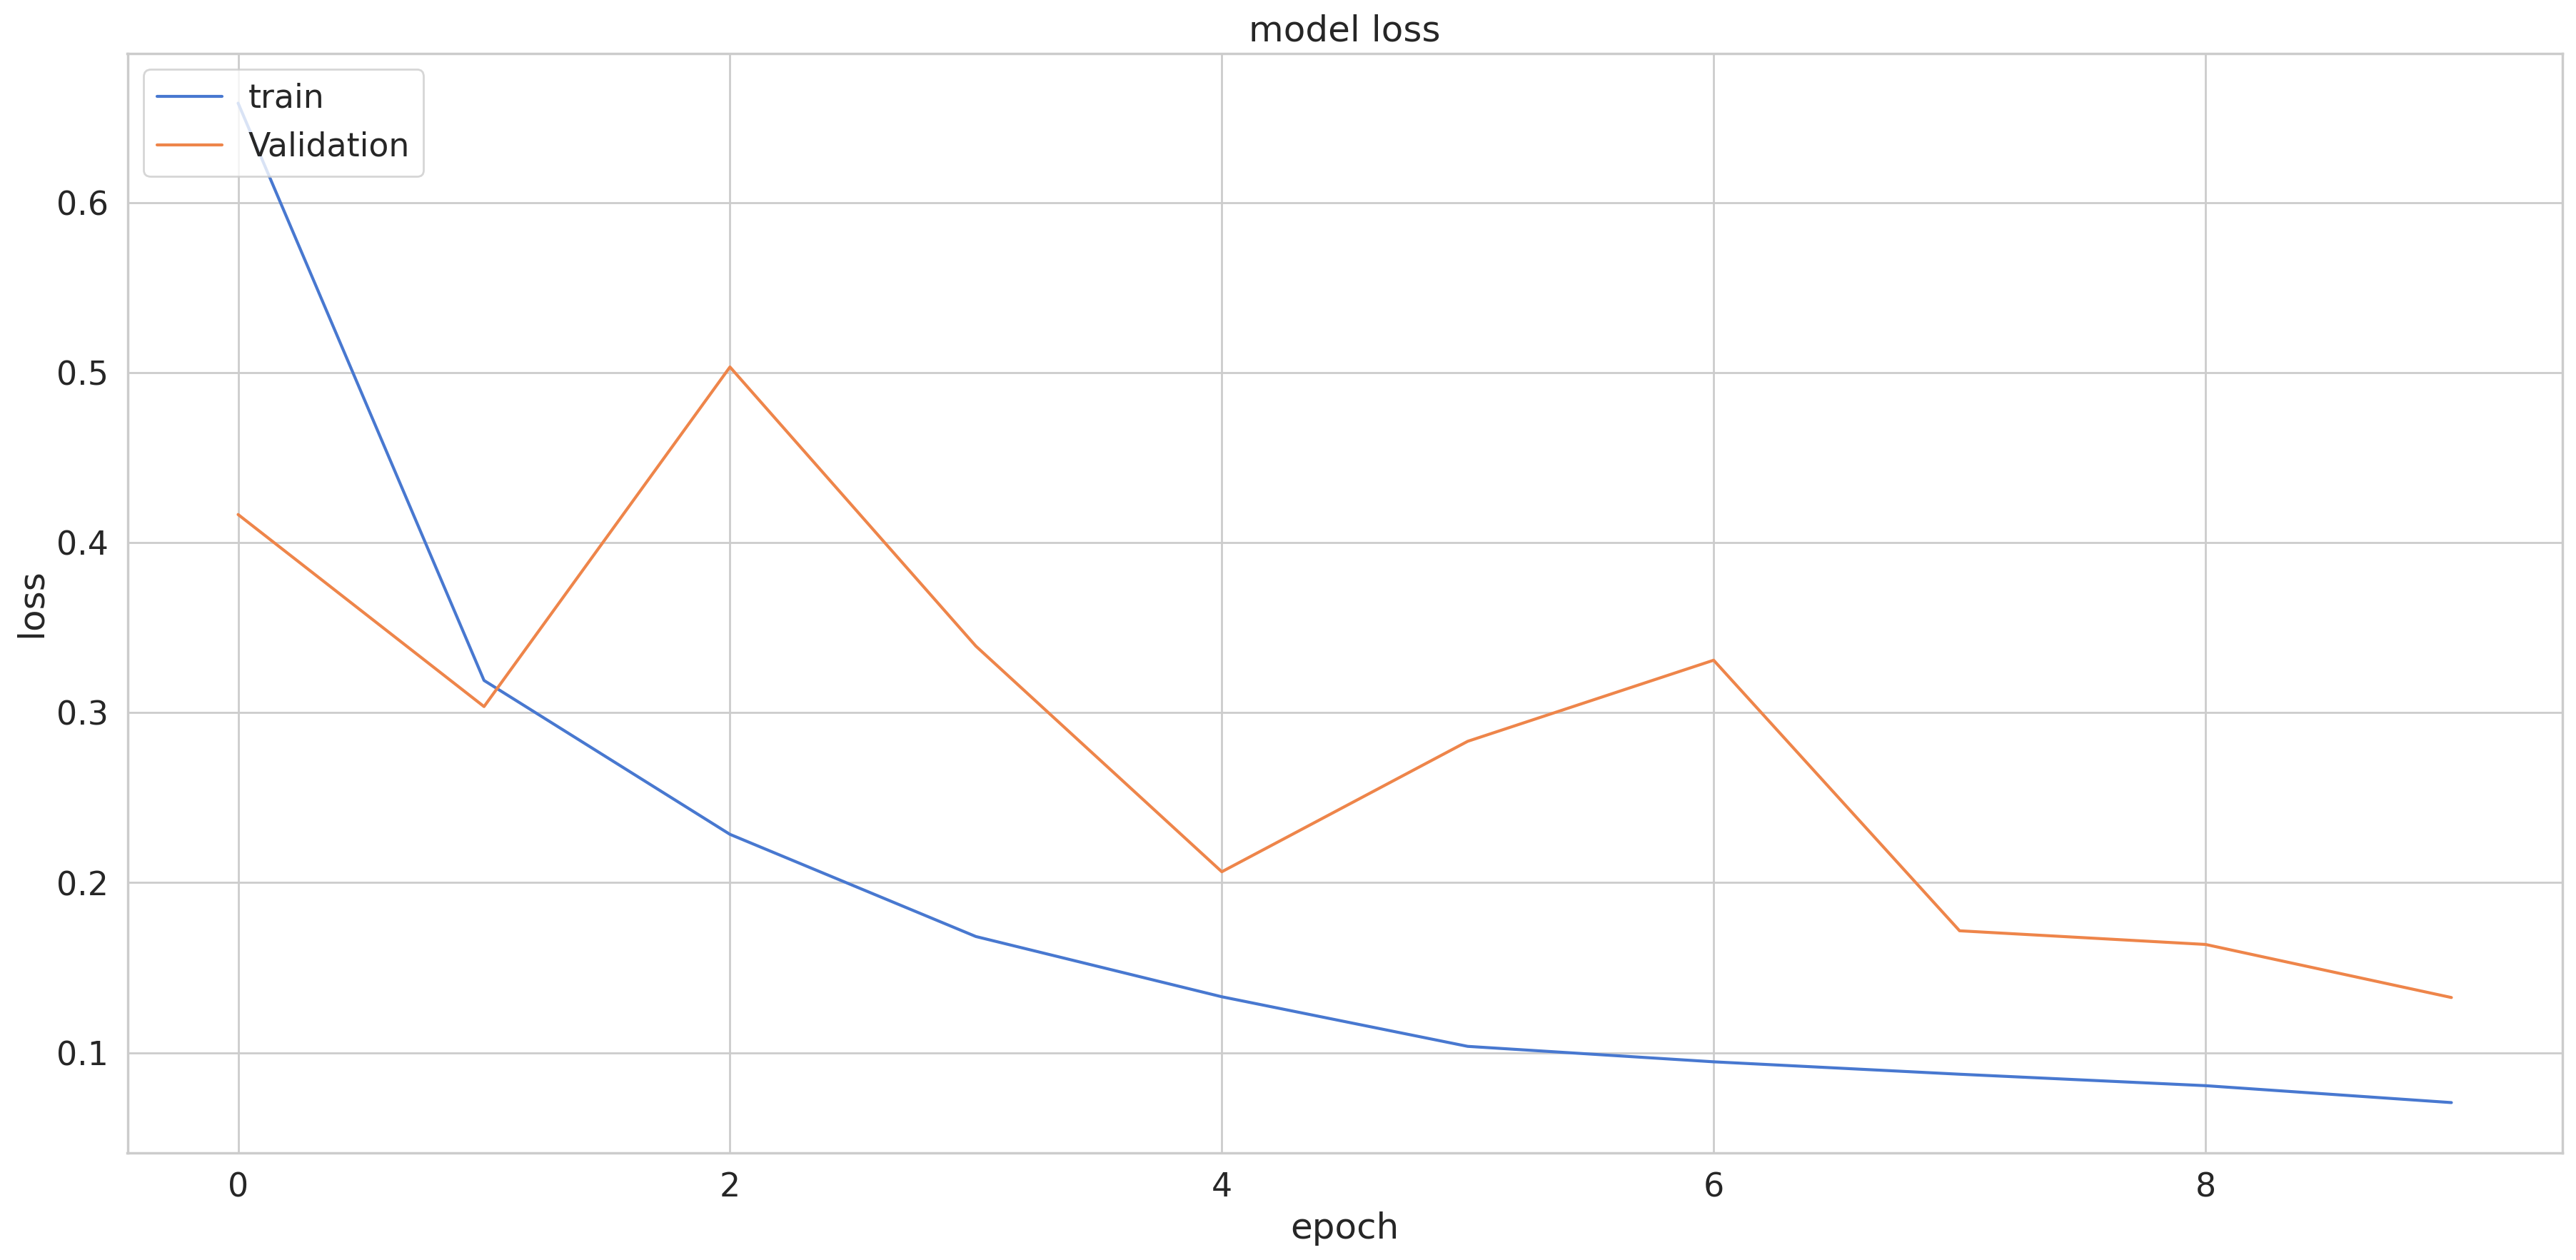

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

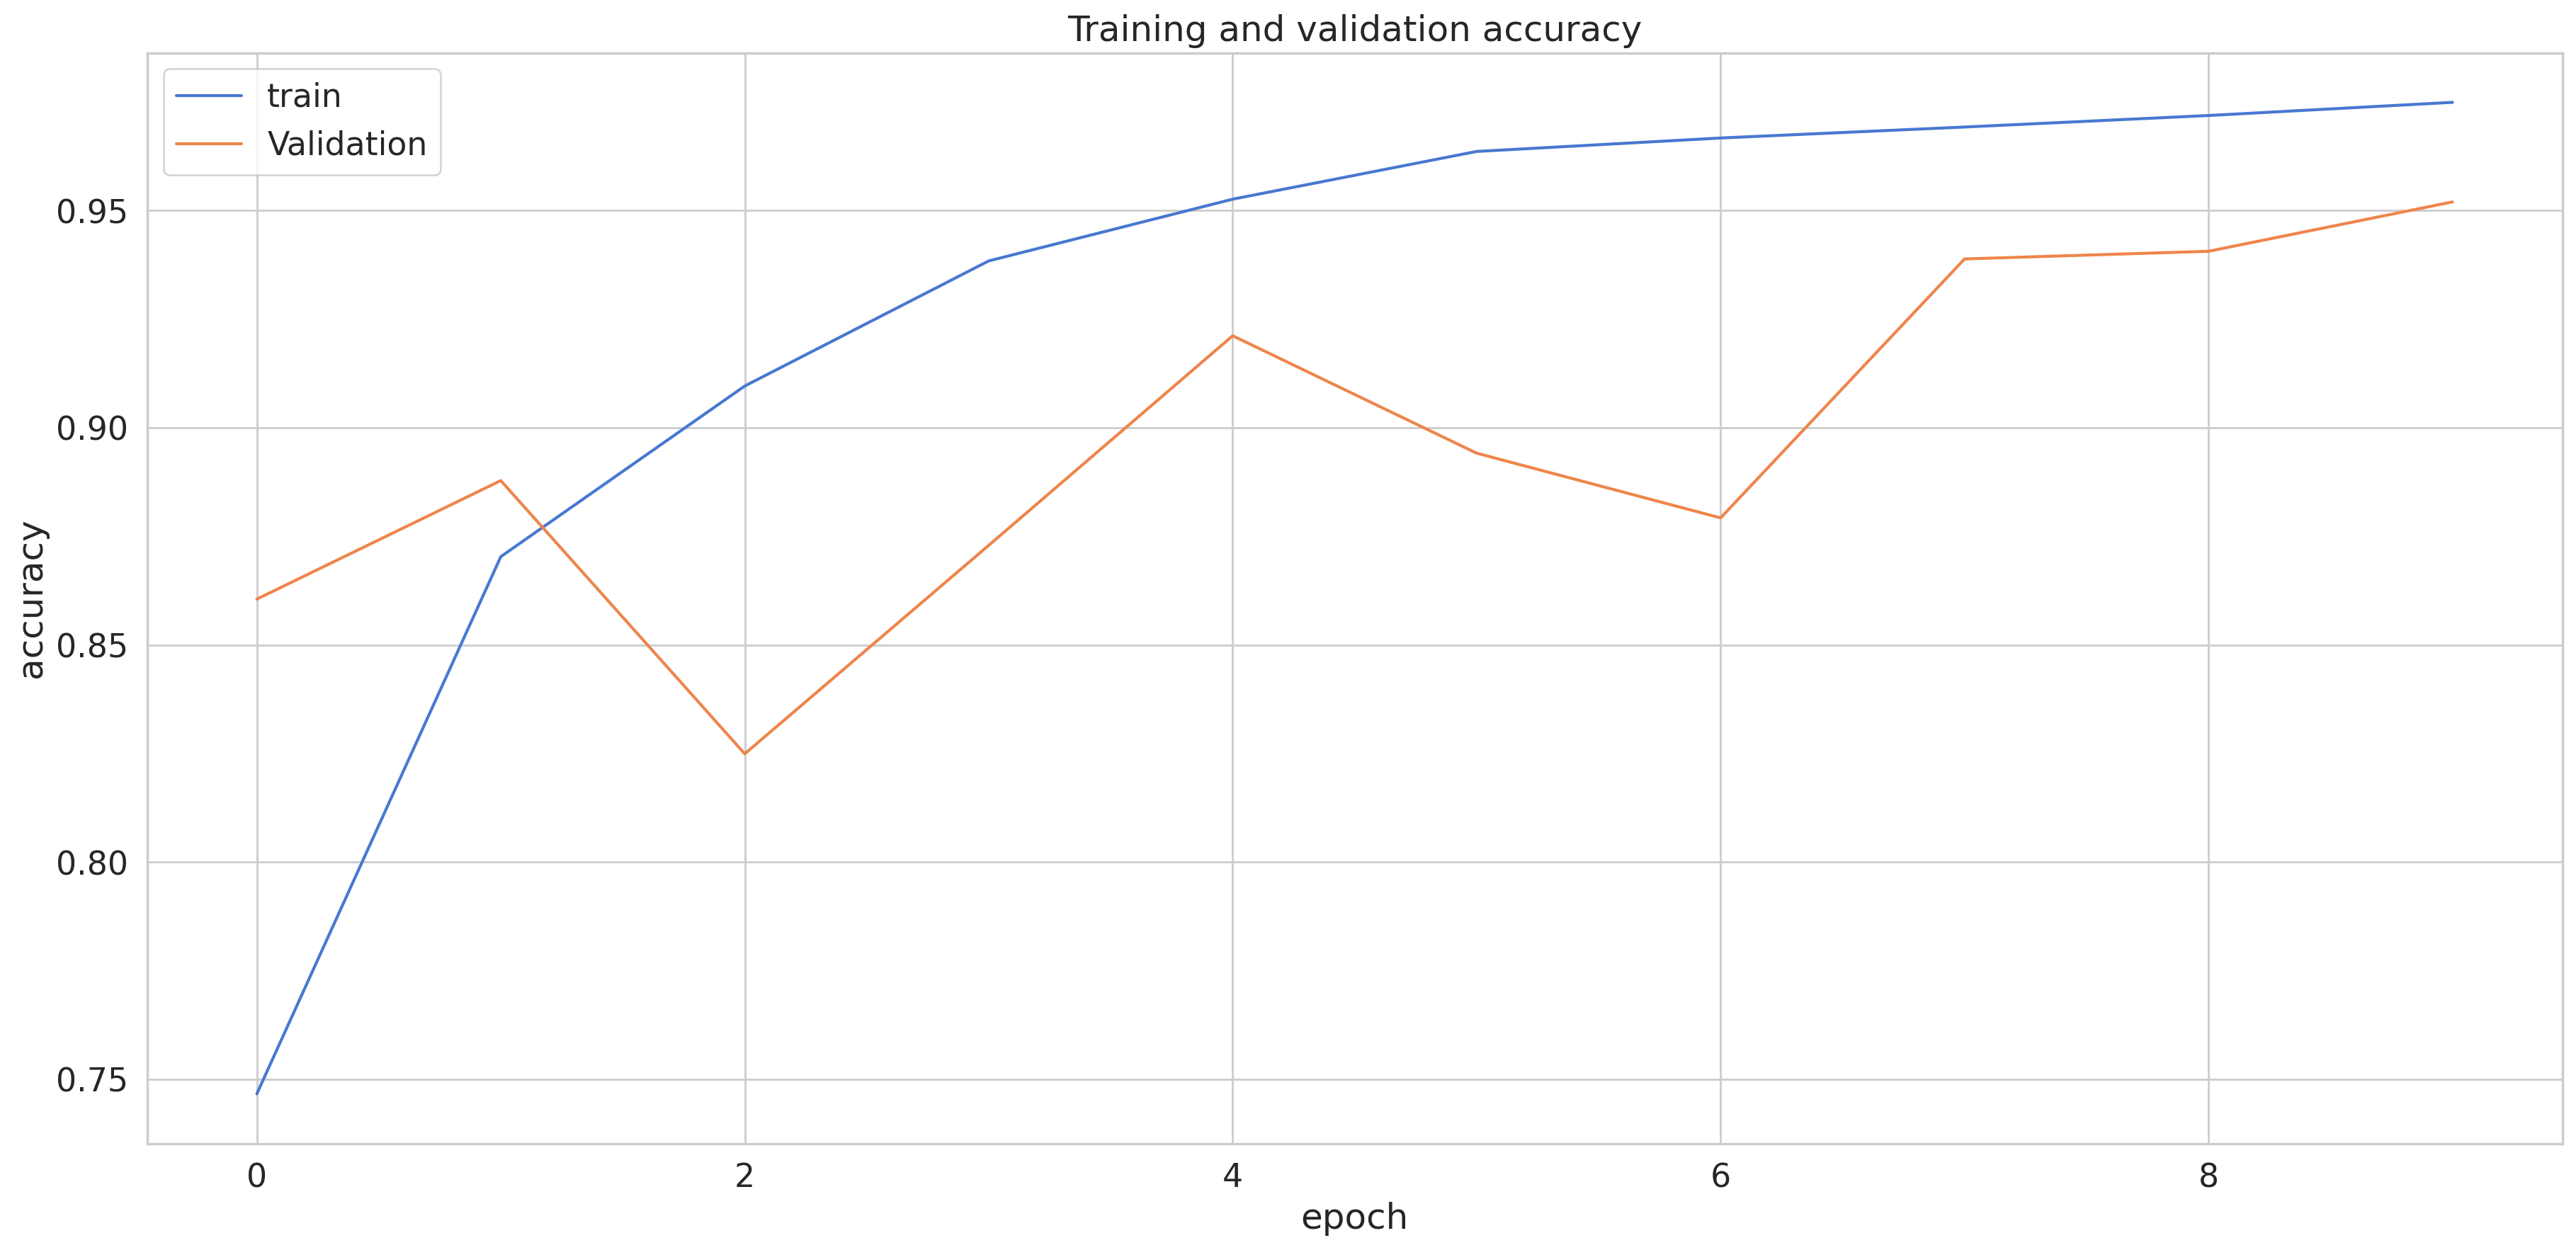

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 4s 19ms/step
f1_score =  0.9583682711232935
0.9571630632451
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2123
           1       1.00      0.94      0.97      1710
           2       0.81      0.92      0.86       615
           3       0.88      0.98      0.93       501

    accuracy                           0.96      4949
   macro avg       0.92      0.95      0.94      4949
weighted avg       0.96      0.96      0.96      4949



<Axes: >

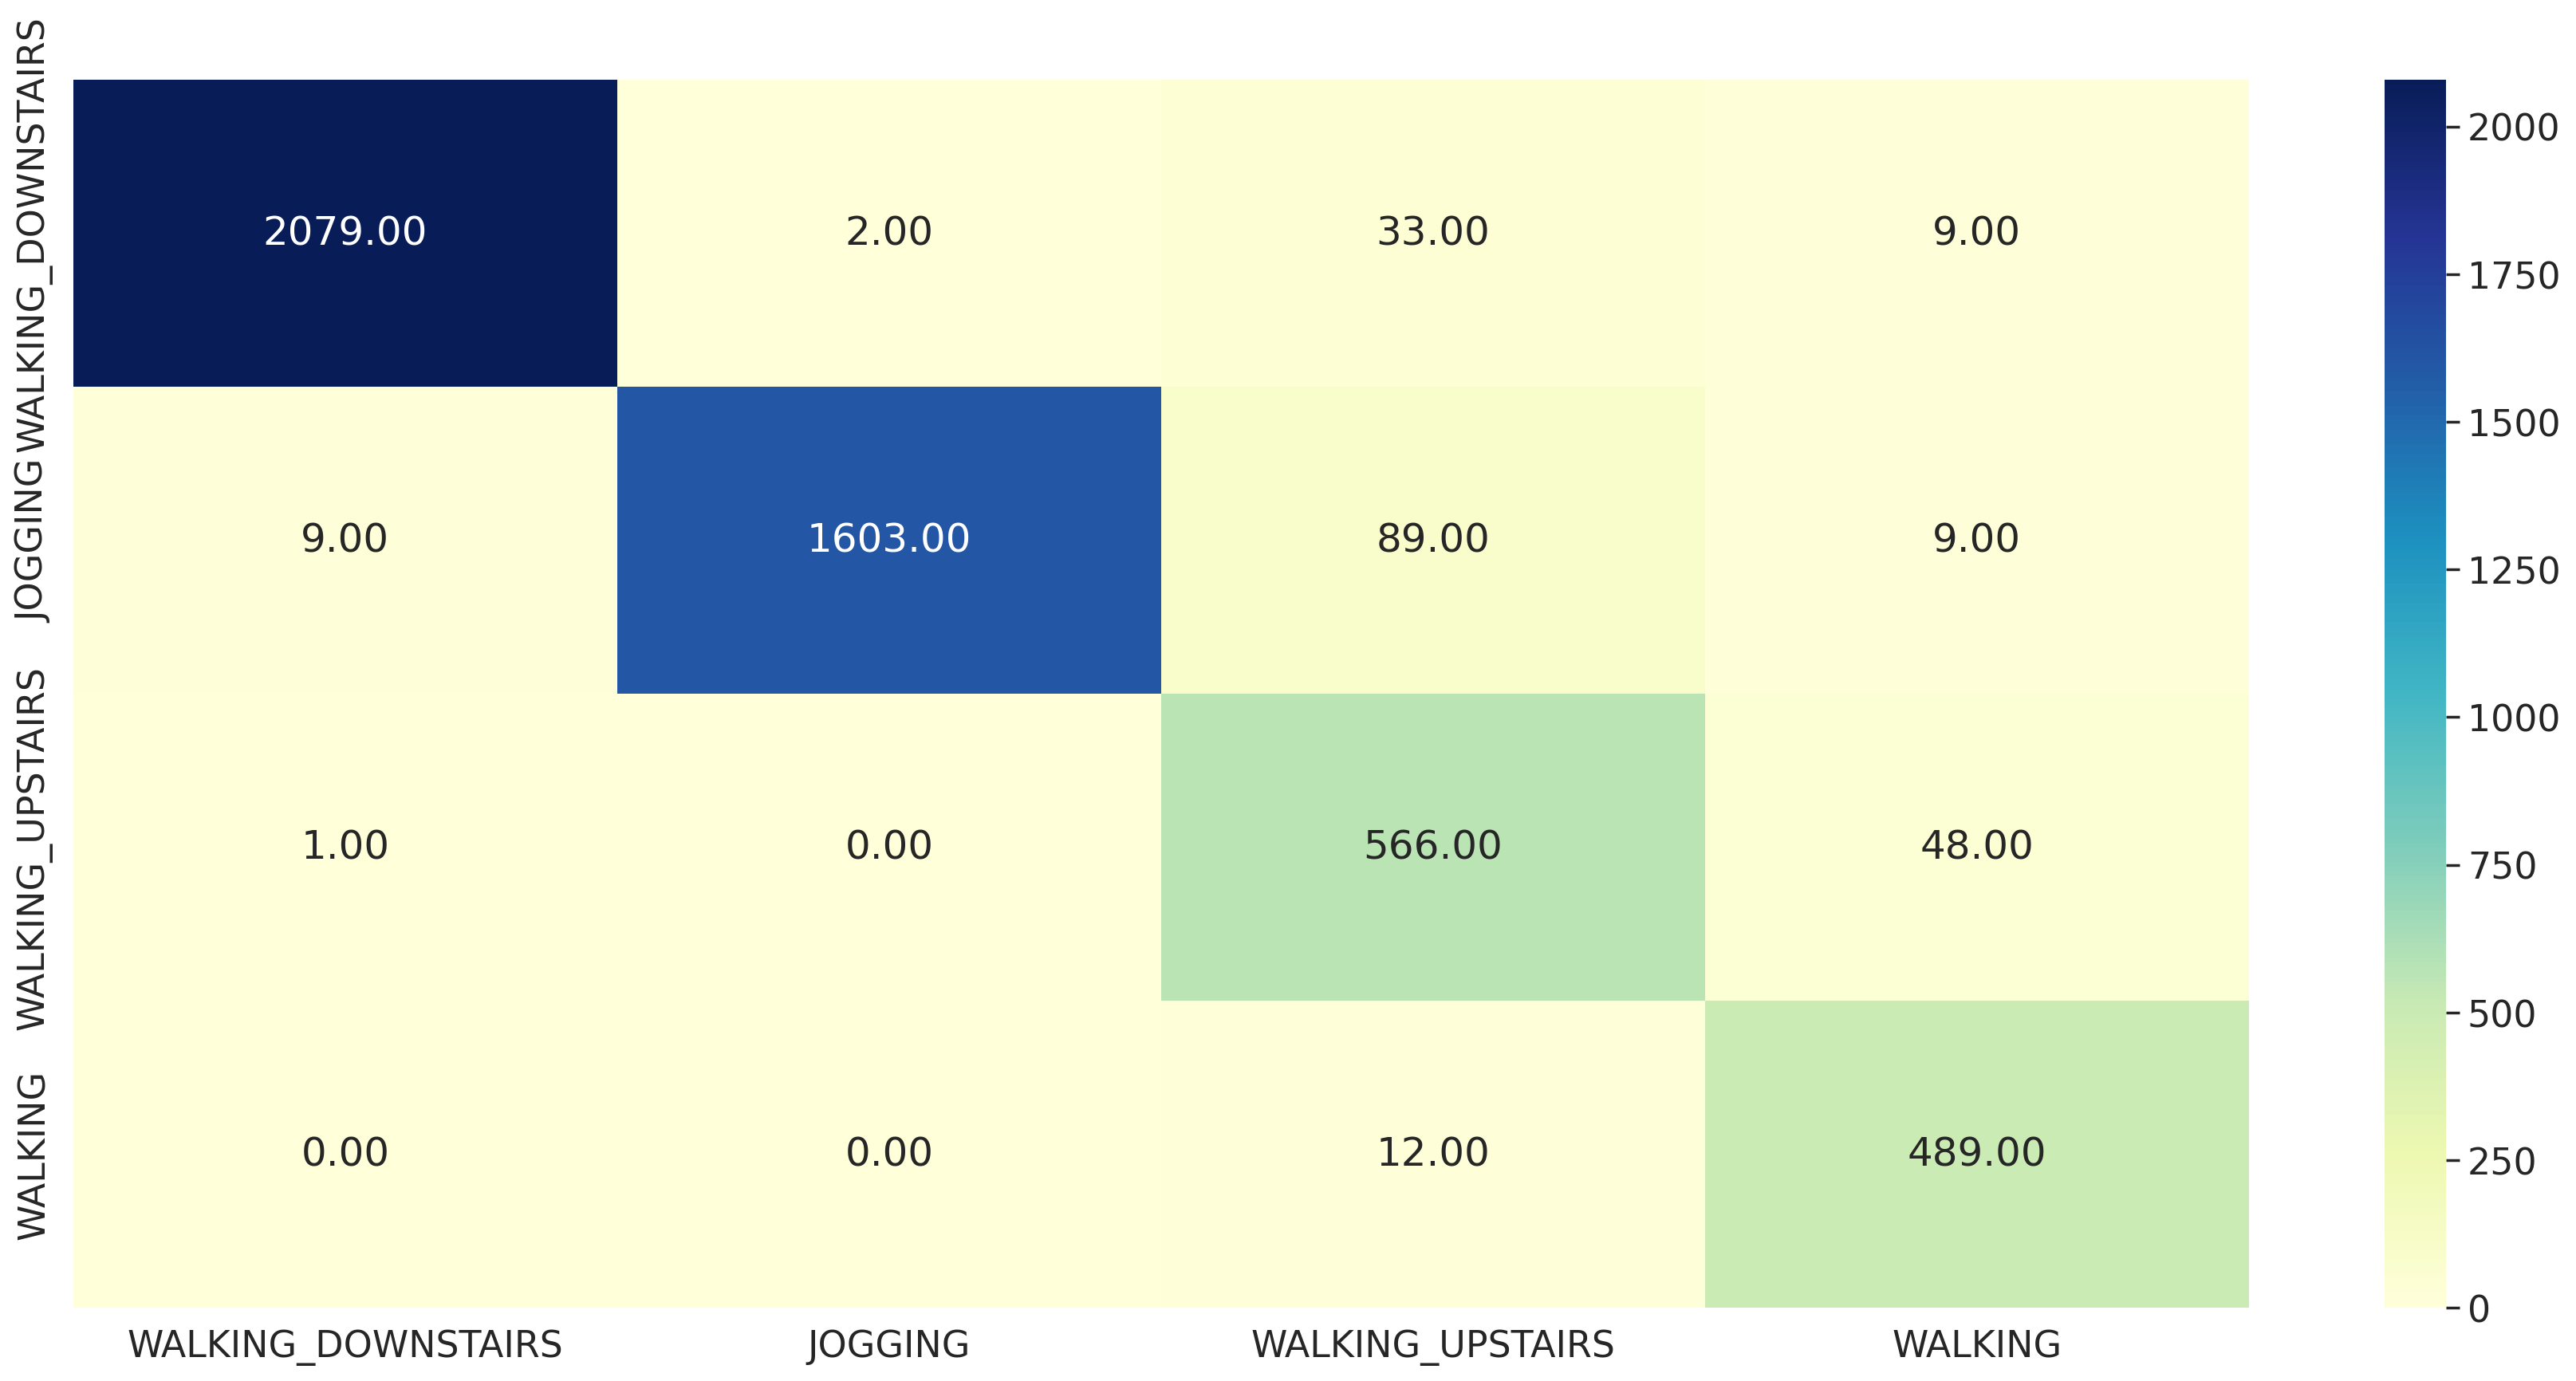

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# layer5

# CNN4 - LSTM1

In [30]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeD  (None, None, 48, 64)      640       
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, None, 46, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, None, 46, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, None, 23, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_21 (TimeD  (None, None, 21, 64)     

In [31]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 29s 204ms/step - loss: 0.6582 - accuracy: 0.7437 - val_loss: 0.4381 - val_accuracy: 0.8310
Epoch 2/10
124/124 [==============================] - 23s 185ms/step - loss: 0.3309 - accuracy: 0.8647 - val_loss: 0.3712 - val_accuracy: 0.8603
Epoch 3/10
124/124 [==============================] - 22s 180ms/step - loss: 0.2220 - accuracy: 0.9105 - val_loss: 0.3896 - val_accuracy: 0.8340
Epoch 4/10
124/124 [==============================] - 25s 199ms/step - loss: 0.1580 - accuracy: 0.9416 - val_loss: 0.4058 - val_accuracy: 0.8517
Epoch 5/10
124/124 [==============================] - 22s 179ms/step - loss: 0.1255 - accuracy: 0.9527 - val_loss: 0.6212 - val_accuracy: 0.7540
Epoch 6/10
124/124 [==============================] - 23s 183ms/step - loss: 0.1109 - accuracy: 0.9607 - val_loss: 0.3113 - val_accuracy: 0.8699
Epoch 7/10
124/124 [==============================] - 24s 196ms/step - loss: 0.0939 - accuracy: 0.9691 - val_loss: 0.2313 - val_ac

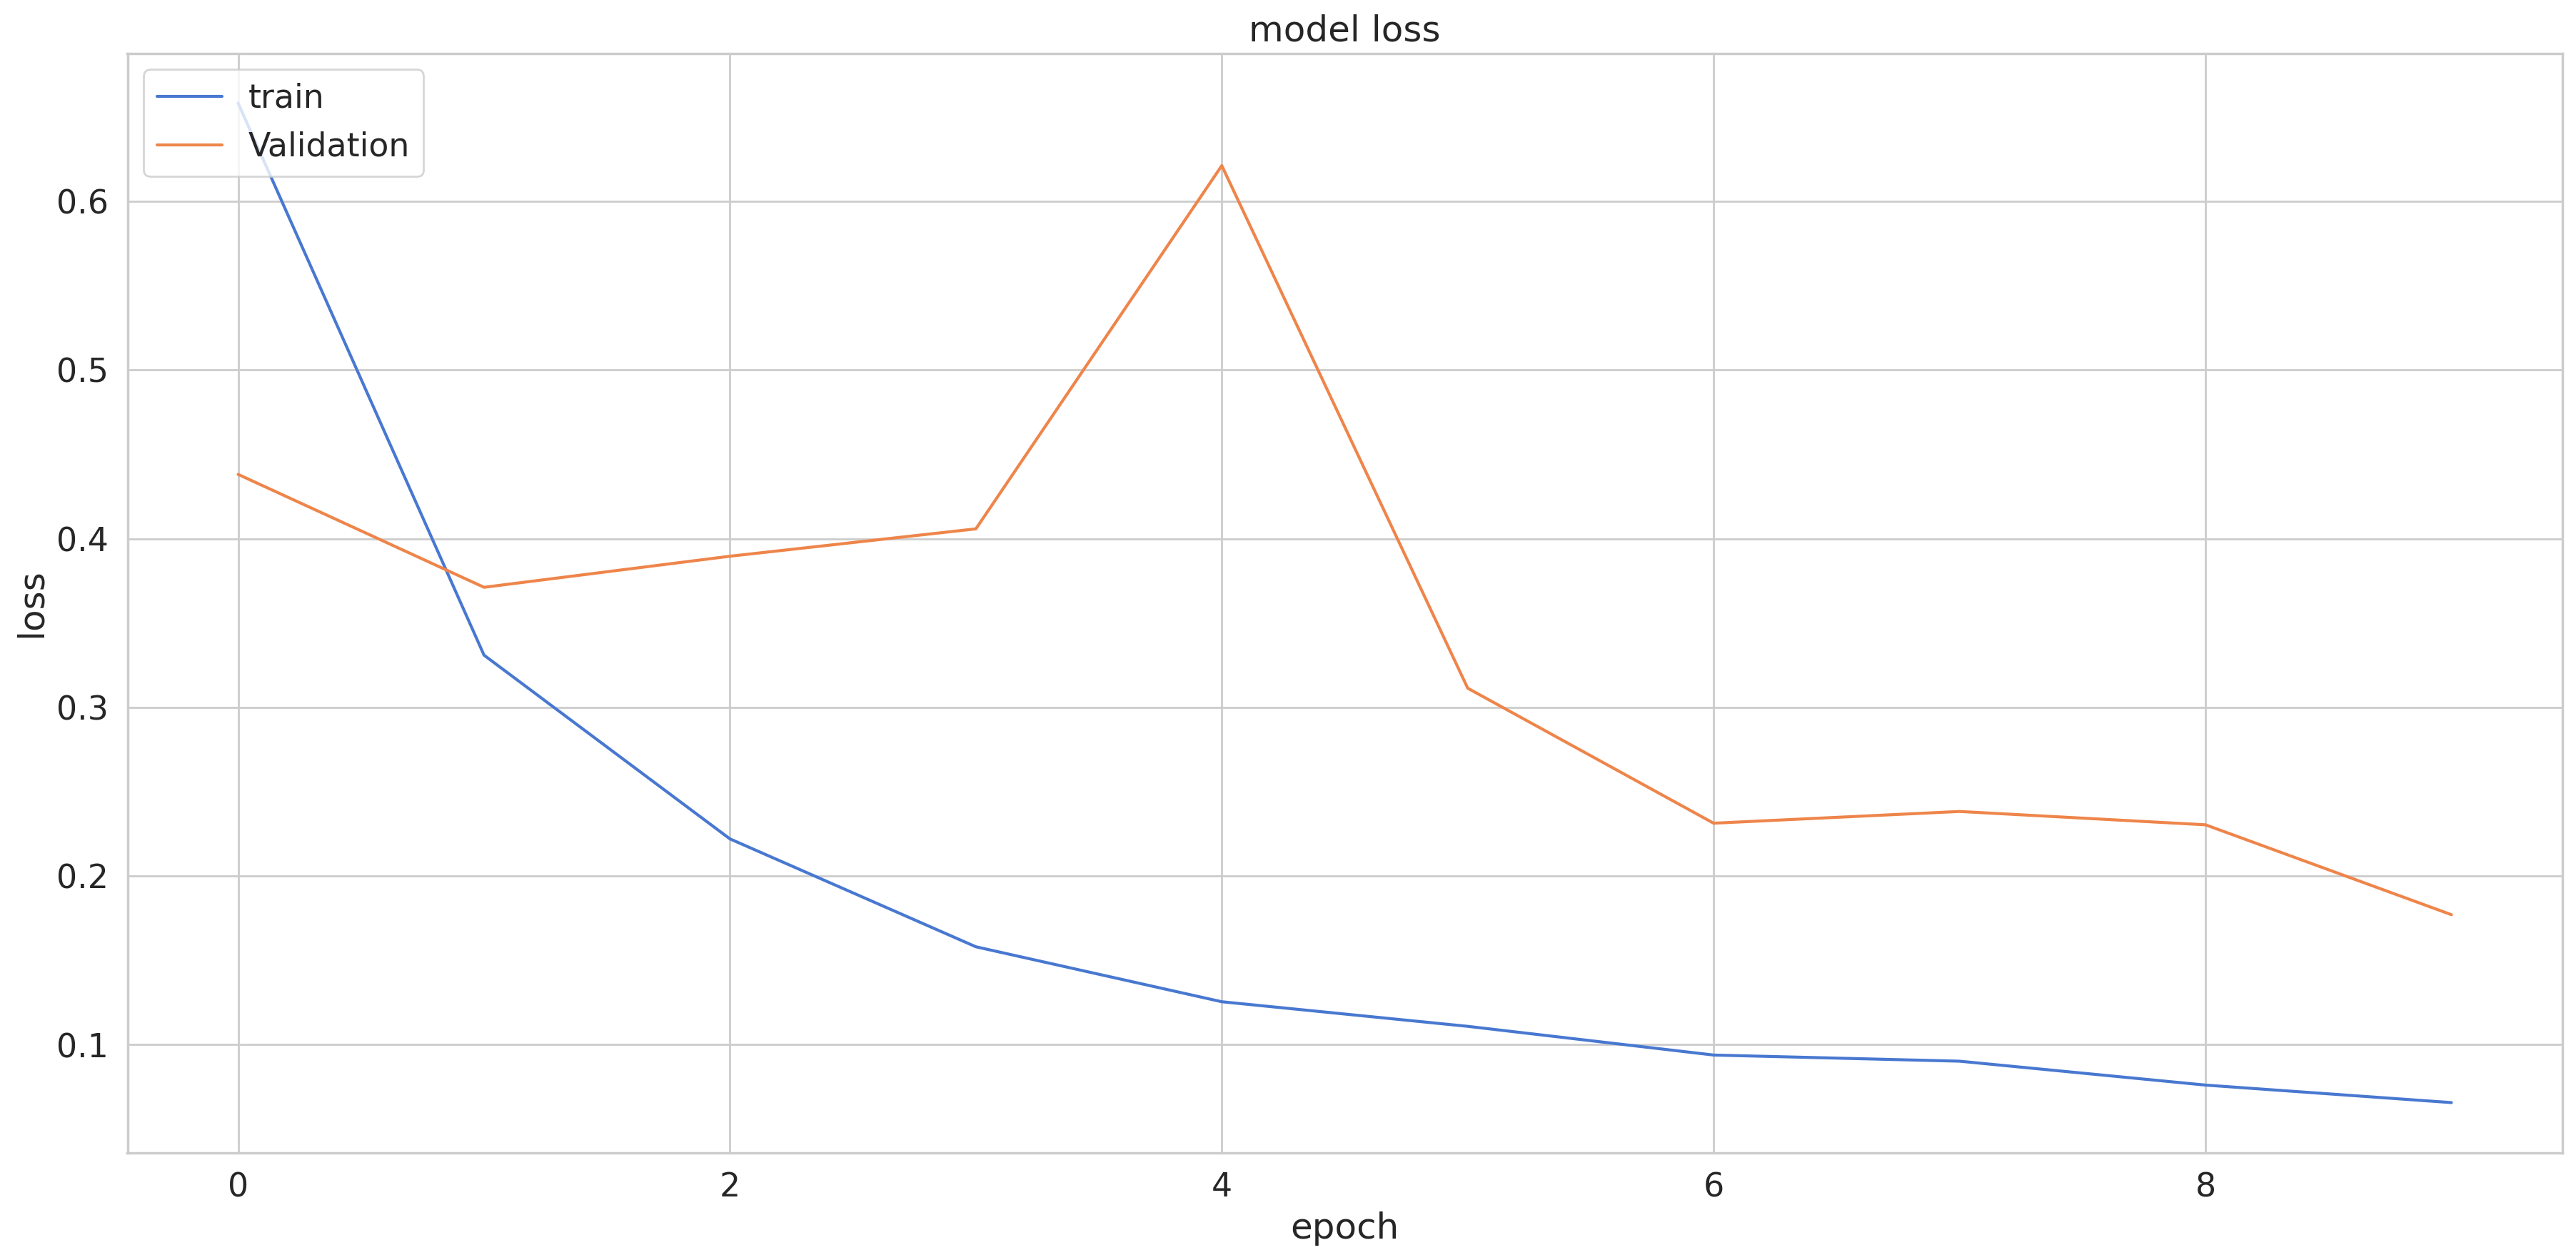

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

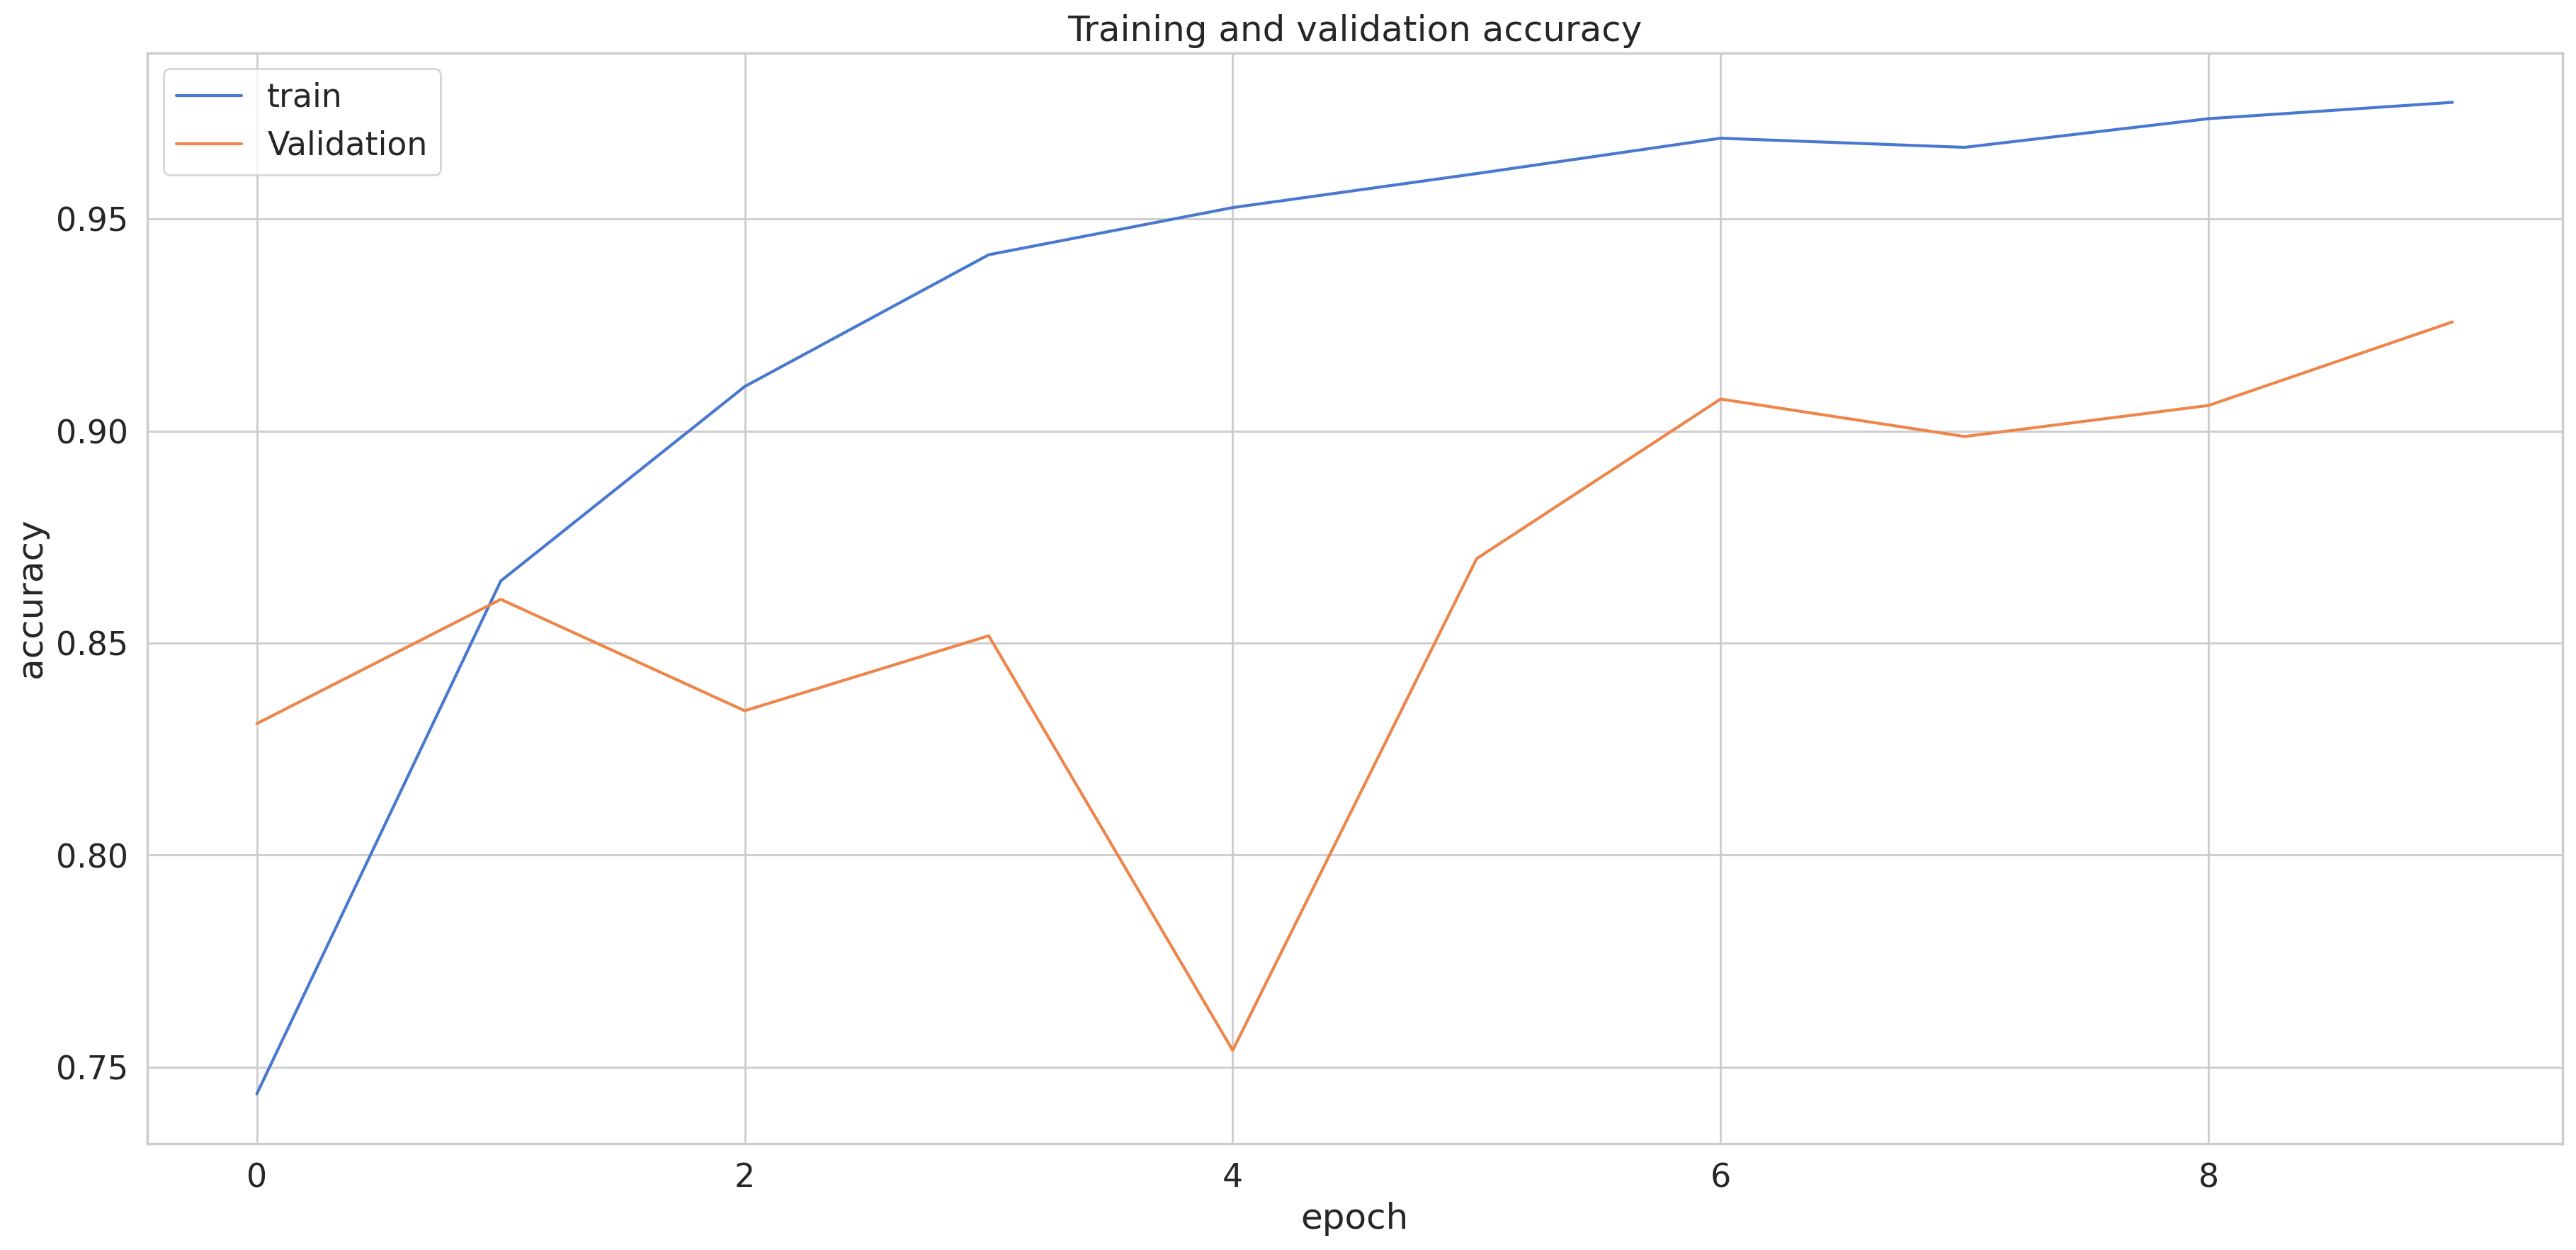

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 3s 13ms/step
f1_score =  0.9236443279920394
0.920590018185492
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2123
           1       1.00      0.86      0.93      1710
           2       0.69      0.79      0.74       615
           3       0.74      0.99      0.85       501

    accuracy                           0.92      4949
   macro avg       0.86      0.91      0.88      4949
weighted avg       0.93      0.92      0.92      4949



<Axes: >

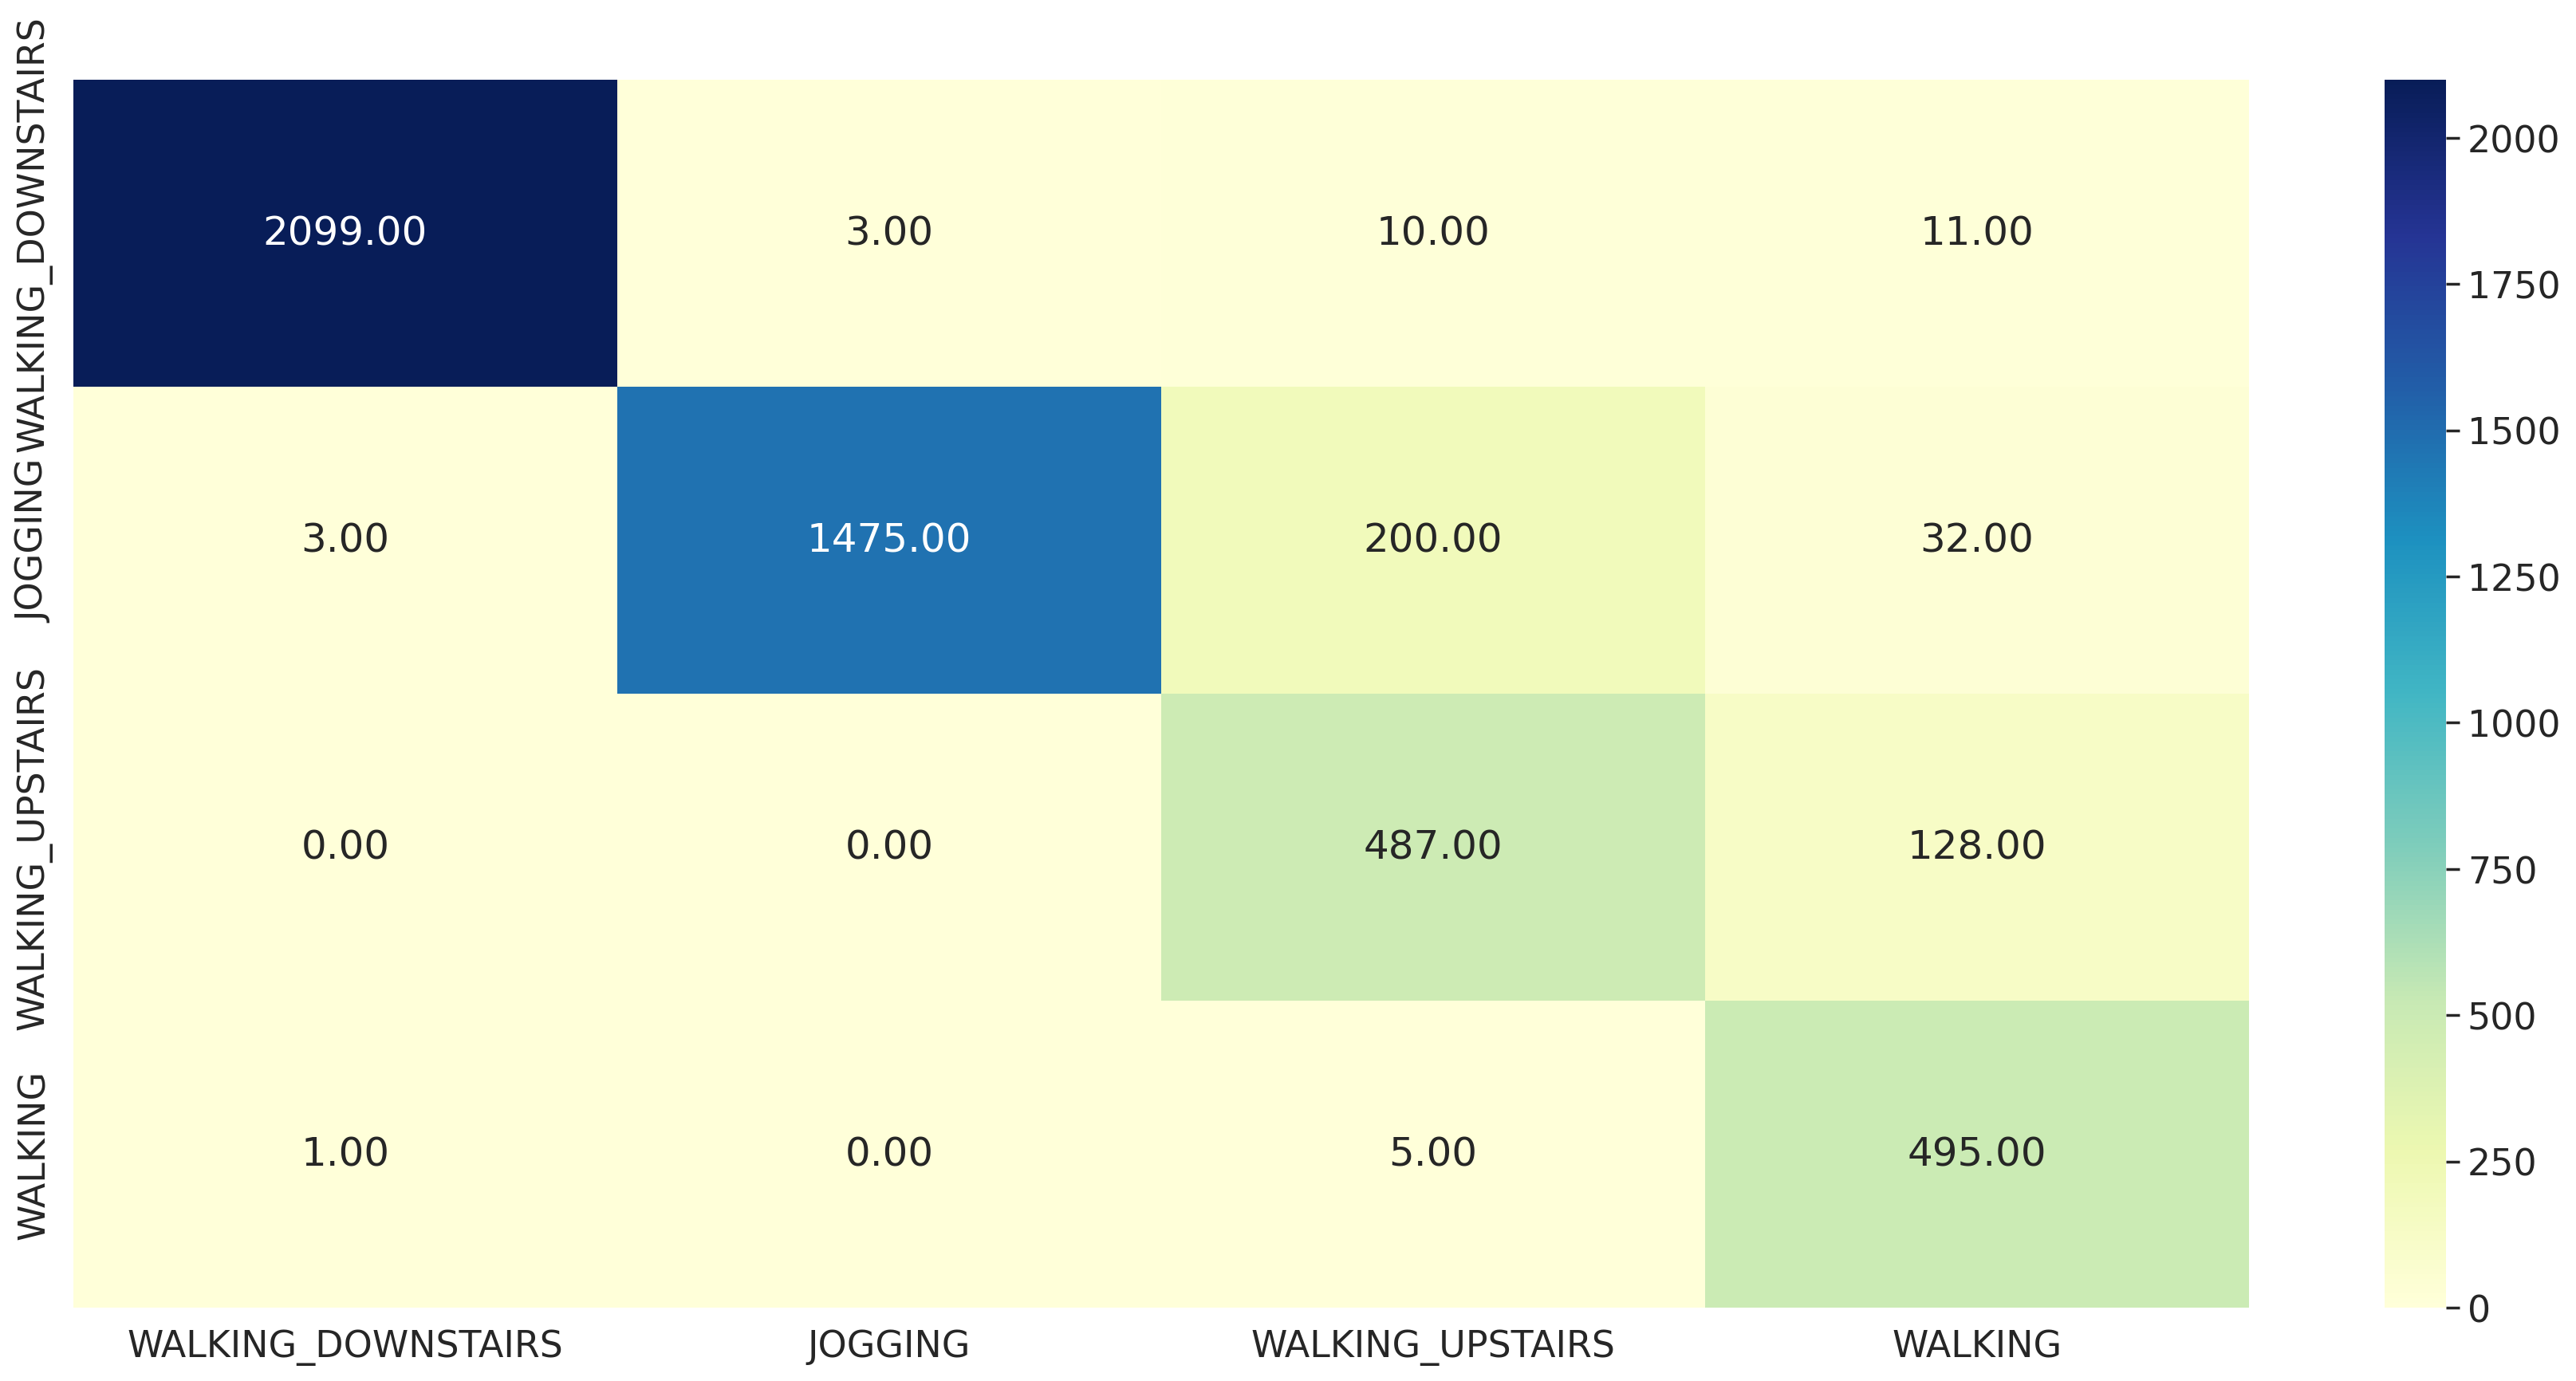

In [34]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN3 - LSTM2

In [15]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 48, 64)      640       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 46, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 46, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, None, 23, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, None, 21, 64)      1

In [16]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 50s 326ms/step - loss: 0.6556 - accuracy: 0.7412 - val_loss: 0.7085 - val_accuracy: 0.7105
Epoch 2/10
124/124 [==============================] - 39s 314ms/step - loss: 0.3203 - accuracy: 0.8669 - val_loss: 0.6569 - val_accuracy: 0.7532
Epoch 3/10
124/124 [==============================] - 29s 236ms/step - loss: 0.2379 - accuracy: 0.8996 - val_loss: 0.4886 - val_accuracy: 0.7972
Epoch 4/10
124/124 [==============================] - 24s 189ms/step - loss: 0.1902 - accuracy: 0.9259 - val_loss: 0.5679 - val_accuracy: 0.7739
Epoch 5/10
124/124 [==============================] - 22s 174ms/step - loss: 0.1463 - accuracy: 0.9474 - val_loss: 0.4107 - val_accuracy: 0.8644
Epoch 6/10
124/124 [==============================] - 21s 170ms/step - loss: 0.1253 - accuracy: 0.9556 - val_loss: 0.1731 - val_accuracy: 0.9417
Epoch 7/10
124/124 [==============================] - 25s 200ms/step - loss: 0.1114 - accuracy: 0.9616 - val_loss: 0.4553 - val_ac

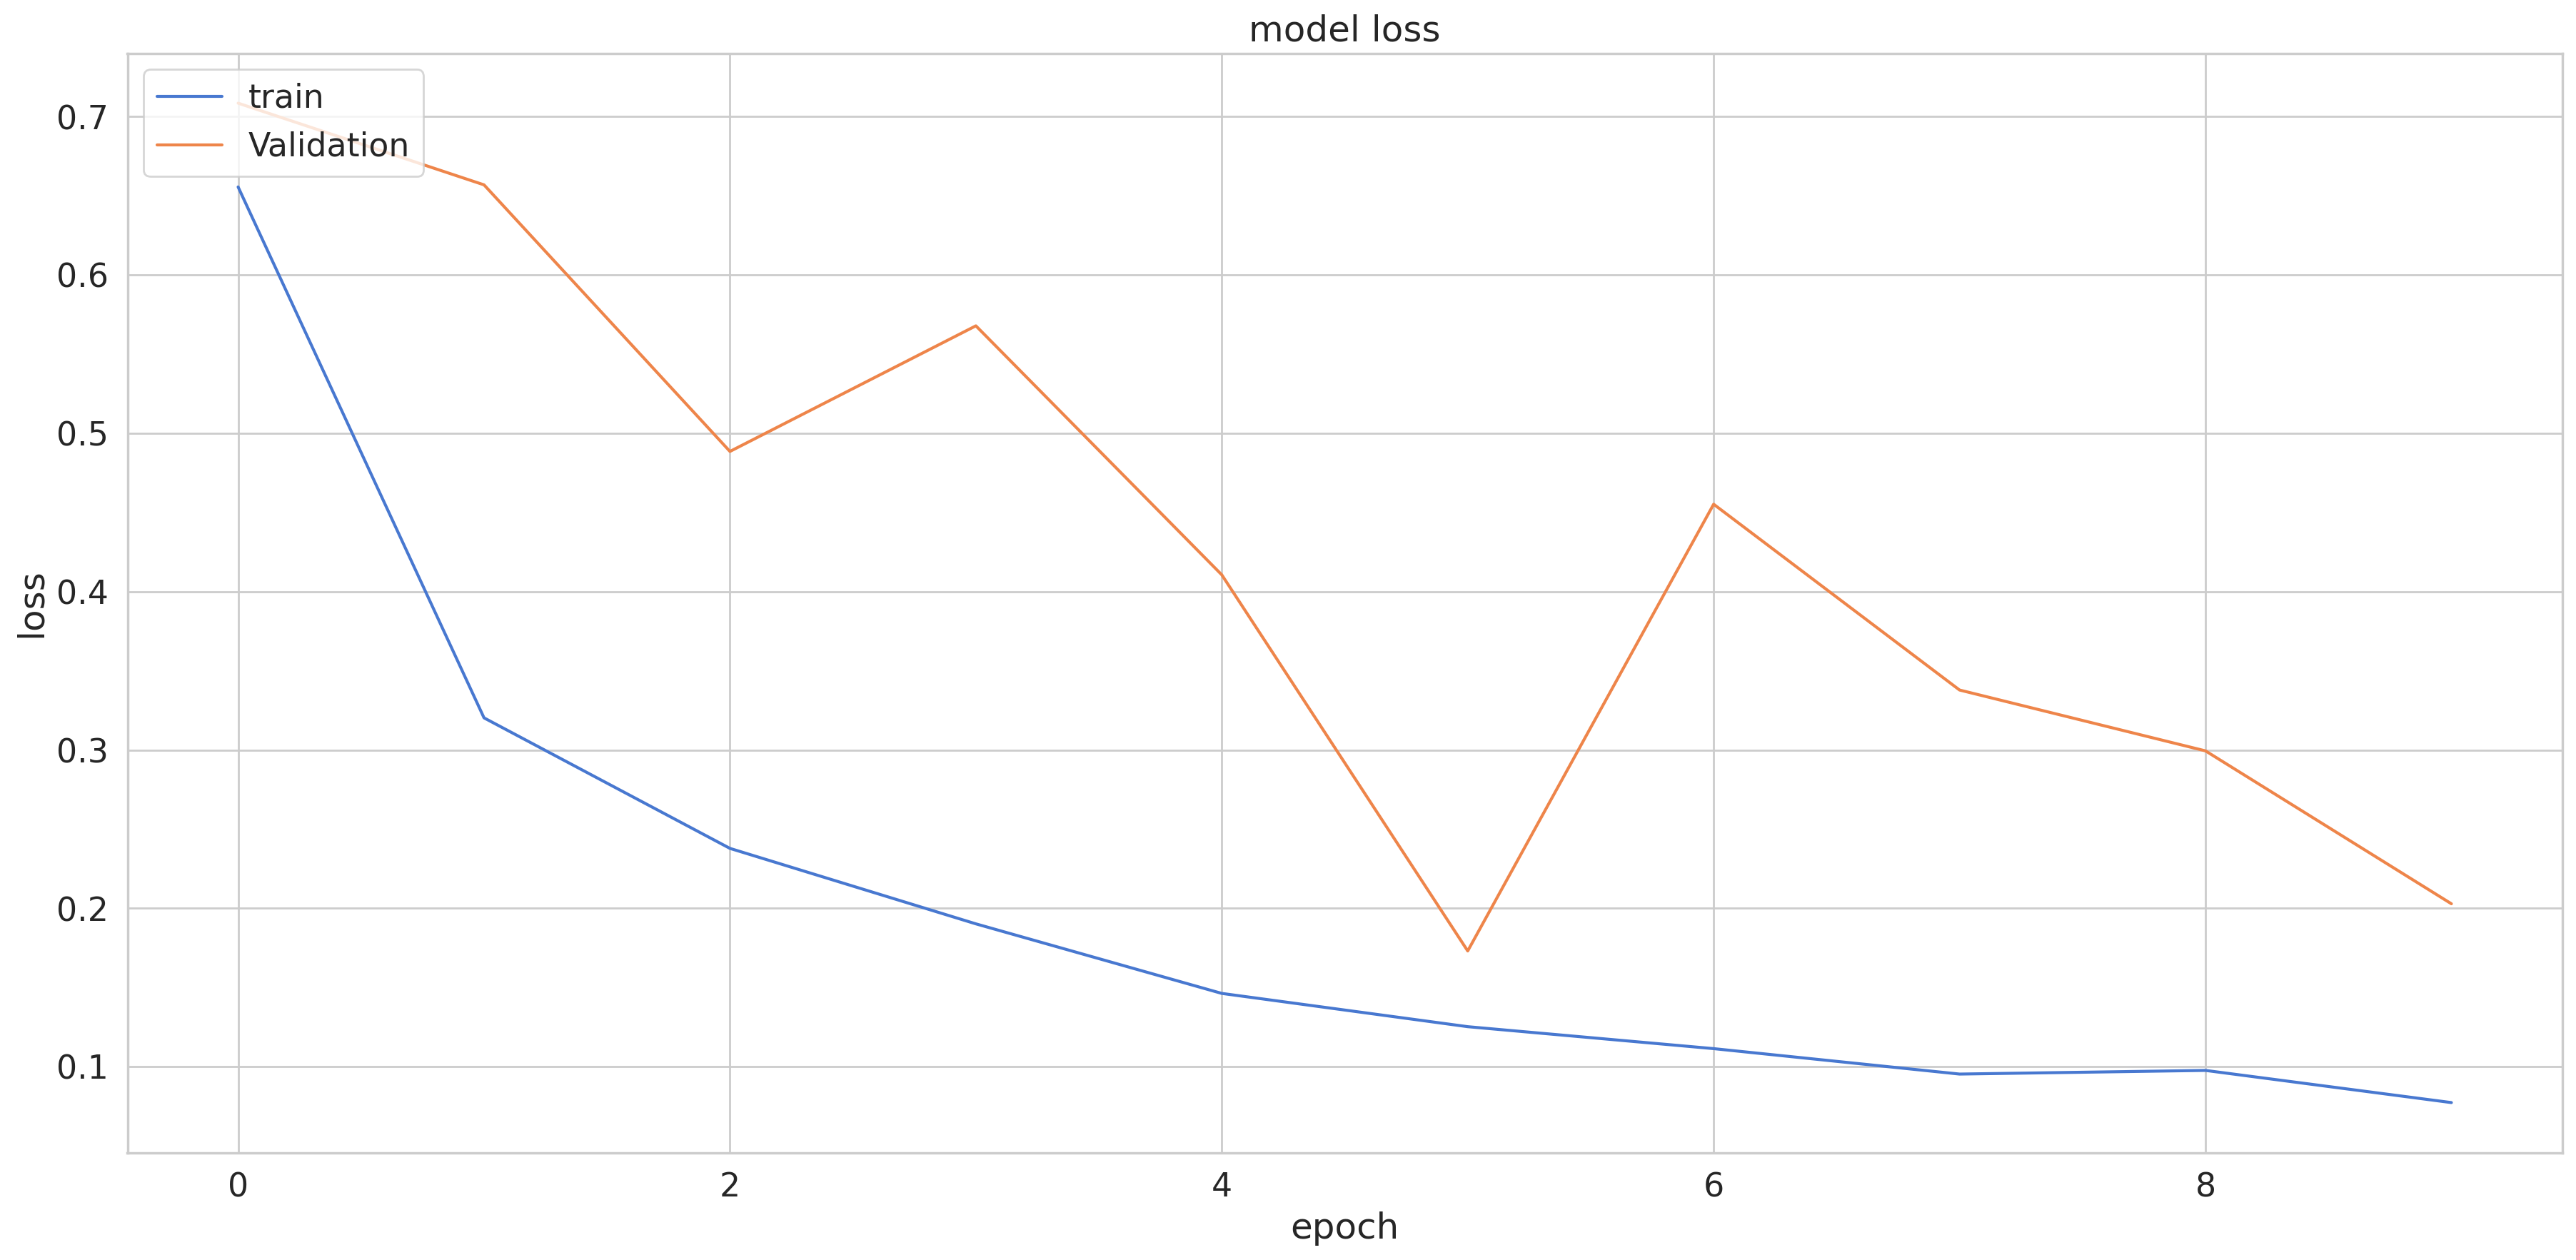

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

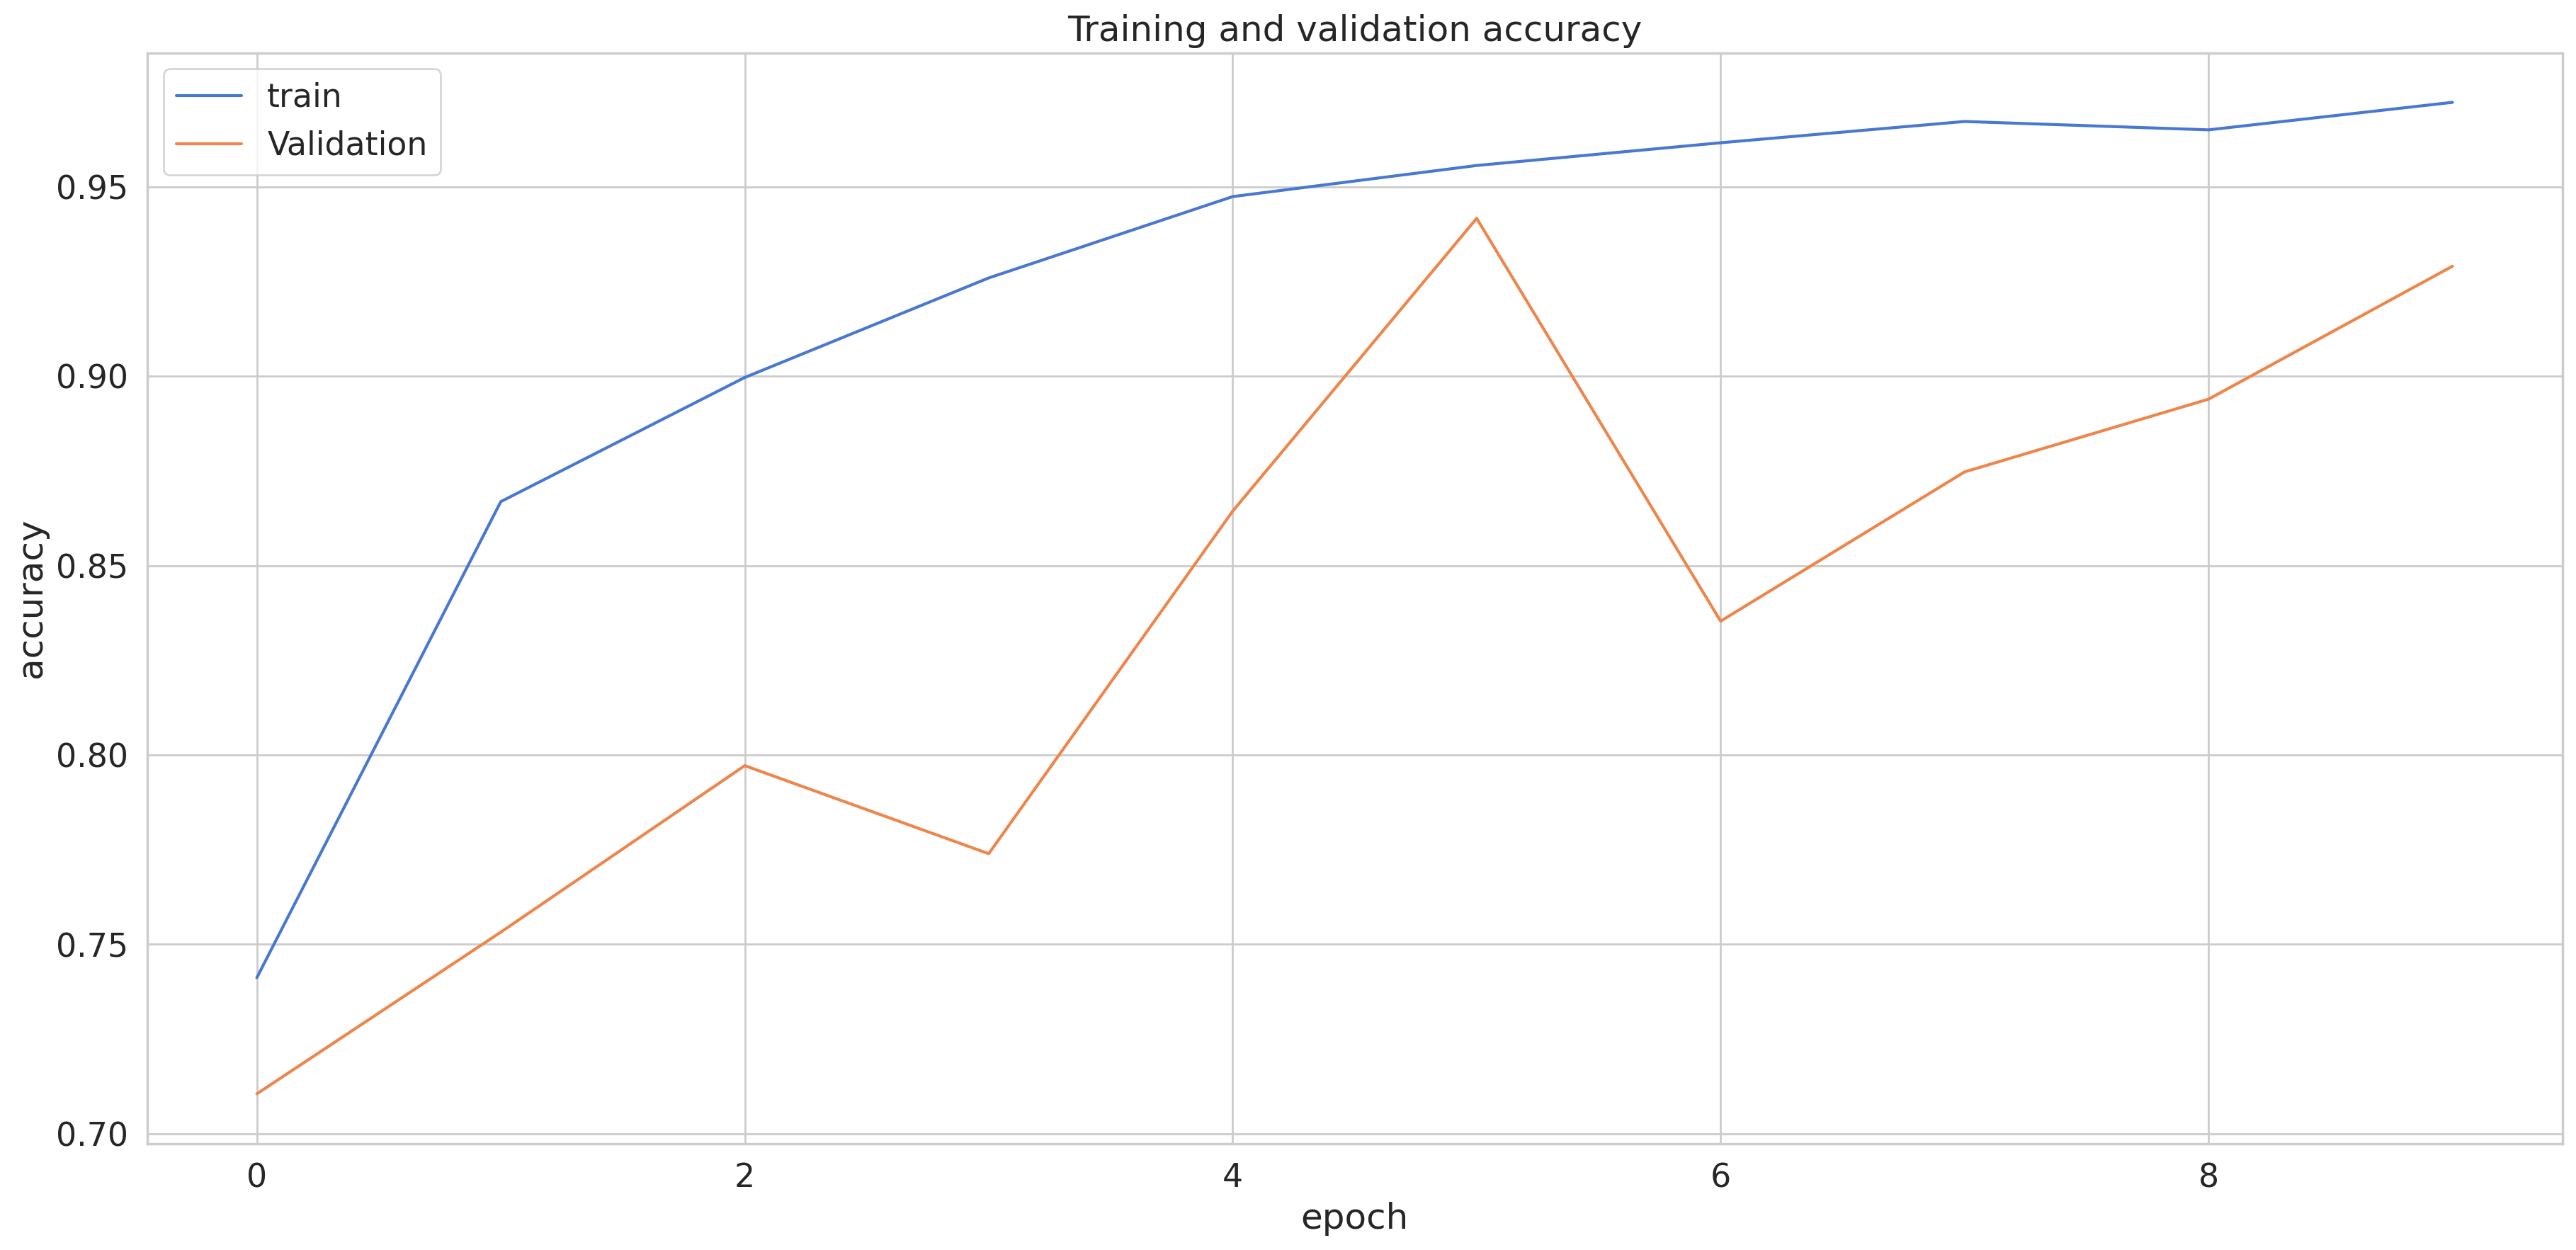

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 4s 17ms/step
f1_score =  0.925099619524795
0.9228126894322085
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2123
           1       1.00      0.91      0.95      1710
           2       0.76      0.70      0.73       615
           3       0.68      1.00      0.81       501

    accuracy                           0.92      4949
   macro avg       0.86      0.90      0.87      4949
weighted avg       0.94      0.92      0.93      4949



<Axes: >

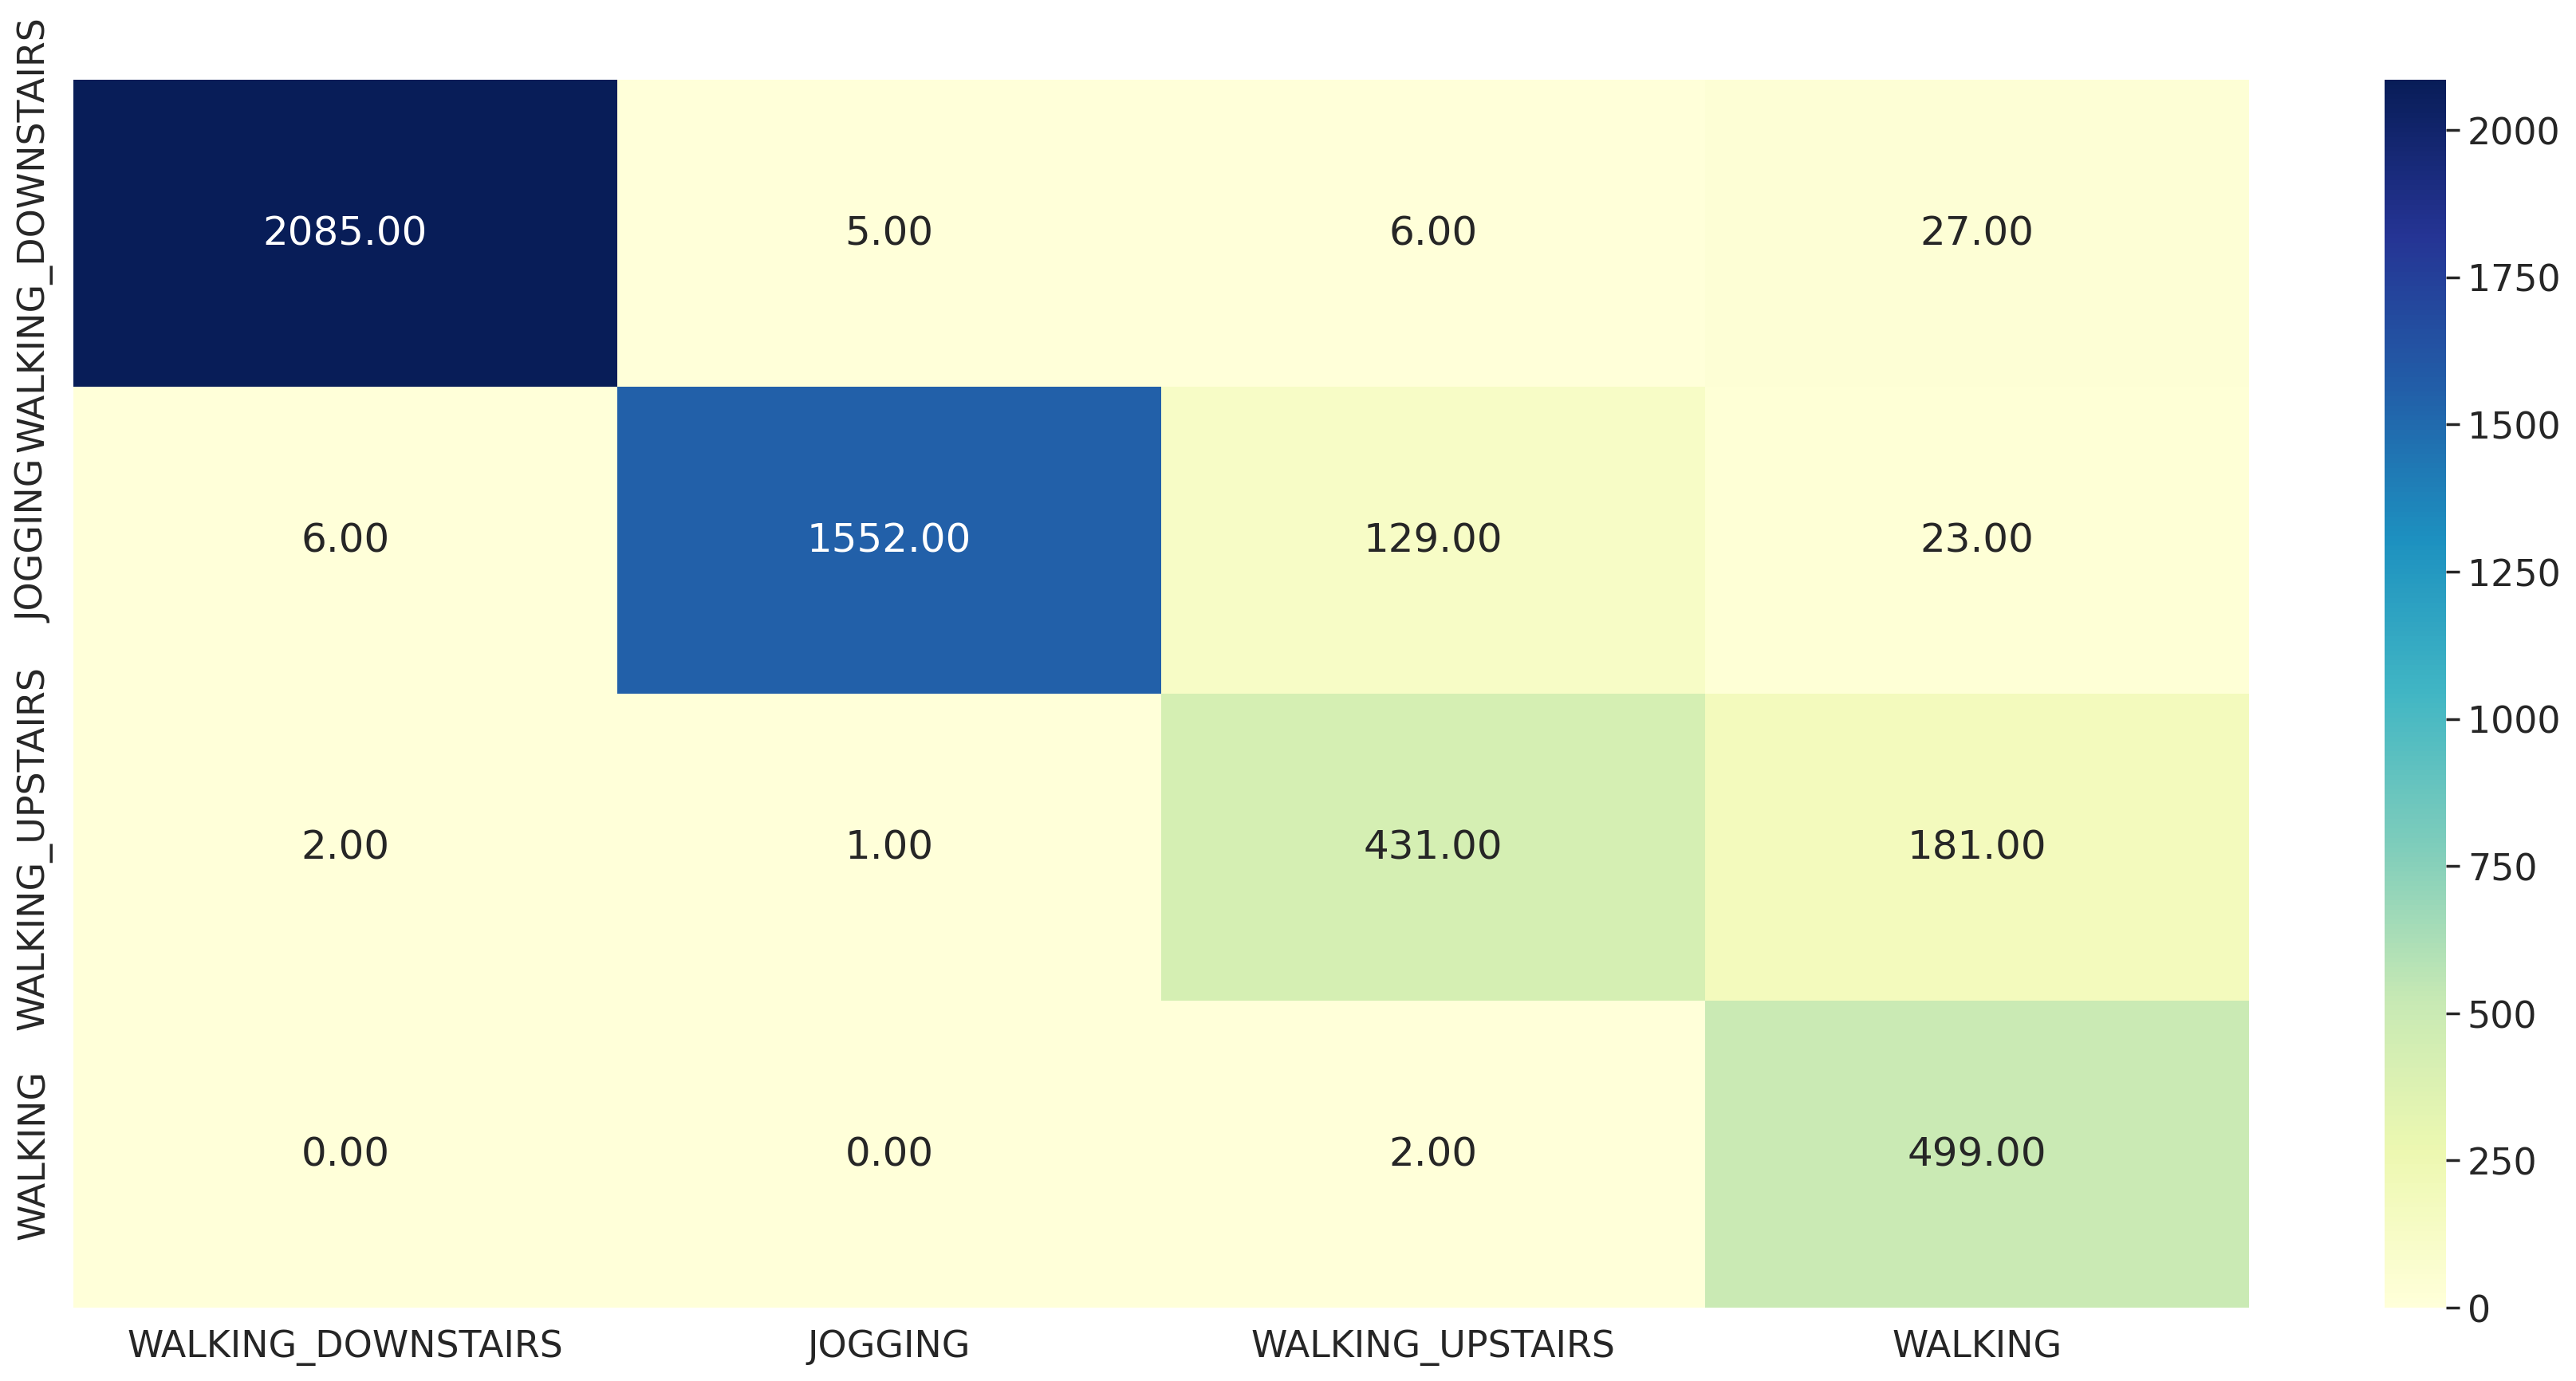

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM3

In [20]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))




model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, None, 48, 64)      640       
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, None, 46, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 46, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 23, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, None, 1472)       

In [21]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 34s 200ms/step - loss: 0.6655 - accuracy: 0.7495 - val_loss: 0.4247 - val_accuracy: 0.8191
Epoch 2/10
124/124 [==============================] - 23s 188ms/step - loss: 0.3479 - accuracy: 0.8606 - val_loss: 0.2437 - val_accuracy: 0.8954
Epoch 3/10
124/124 [==============================] - 23s 188ms/step - loss: 0.2519 - accuracy: 0.8975 - val_loss: 0.2186 - val_accuracy: 0.9025
Epoch 4/10
124/124 [==============================] - 22s 176ms/step - loss: 0.1959 - accuracy: 0.9262 - val_loss: 0.1774 - val_accuracy: 0.9313
Epoch 5/10
124/124 [==============================] - 23s 186ms/step - loss: 0.1524 - accuracy: 0.9445 - val_loss: 0.1179 - val_accuracy: 0.9619
Epoch 6/10
124/124 [==============================] - 24s 190ms/step - loss: 0.1236 - accuracy: 0.9535 - val_loss: 0.1417 - val_accuracy: 0.9427
Epoch 7/10
124/124 [==============================] - 22s 175ms/step - loss: 0.1044 - accuracy: 0.9635 - val_loss: 0.1586 - val_ac

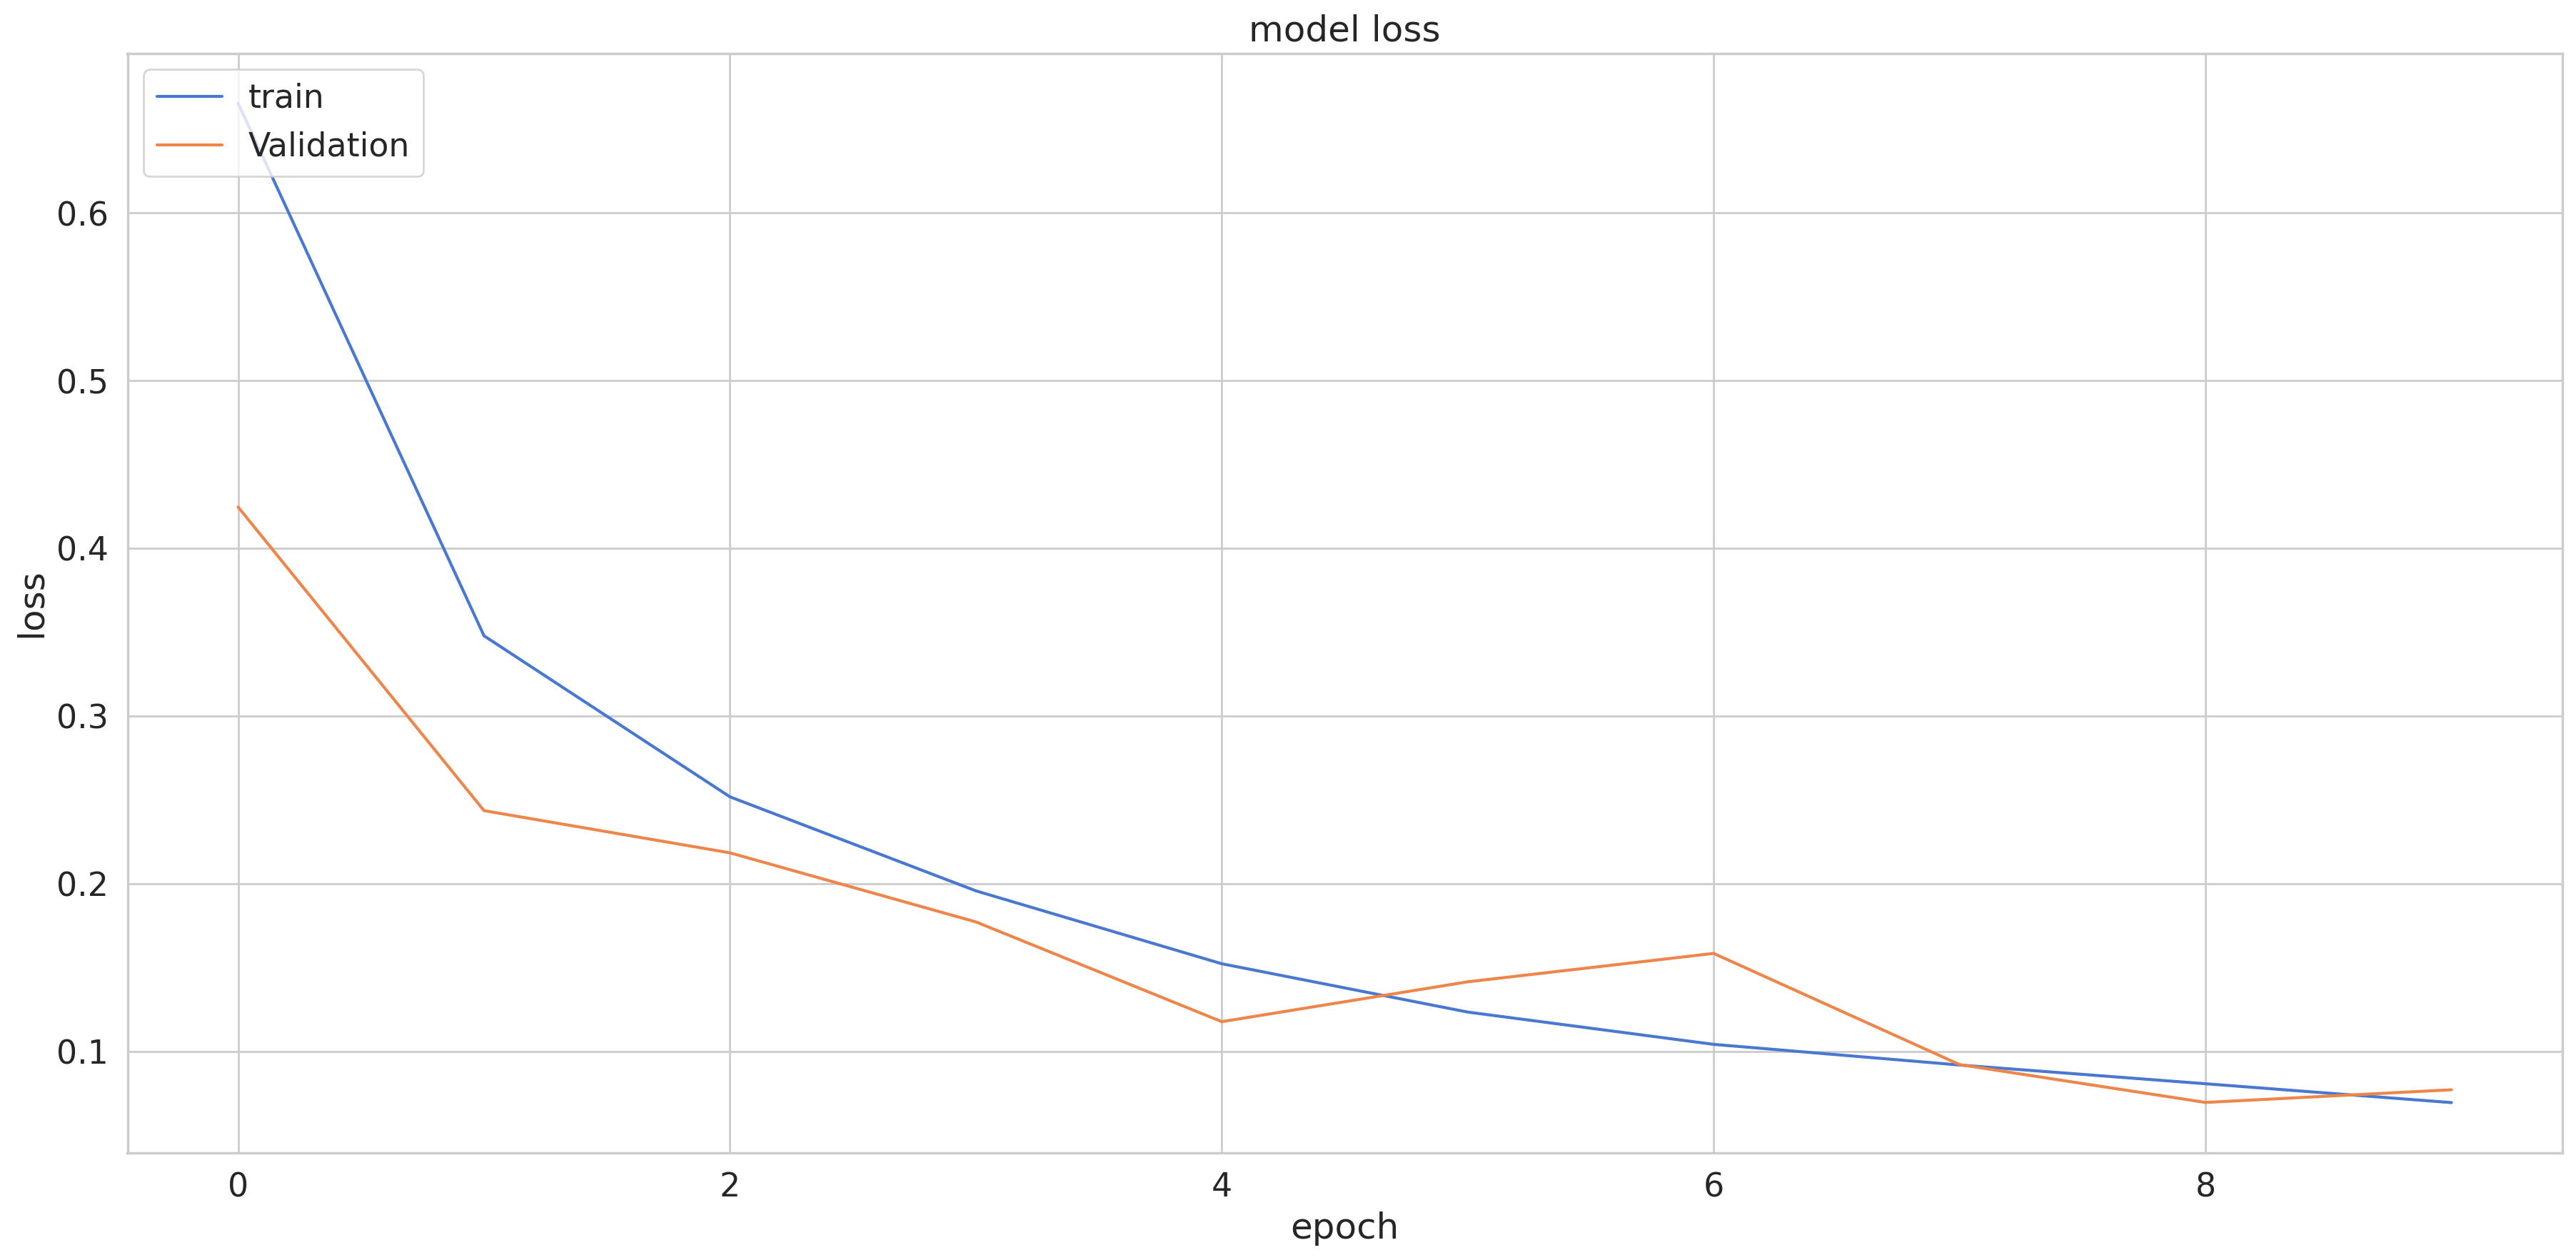

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

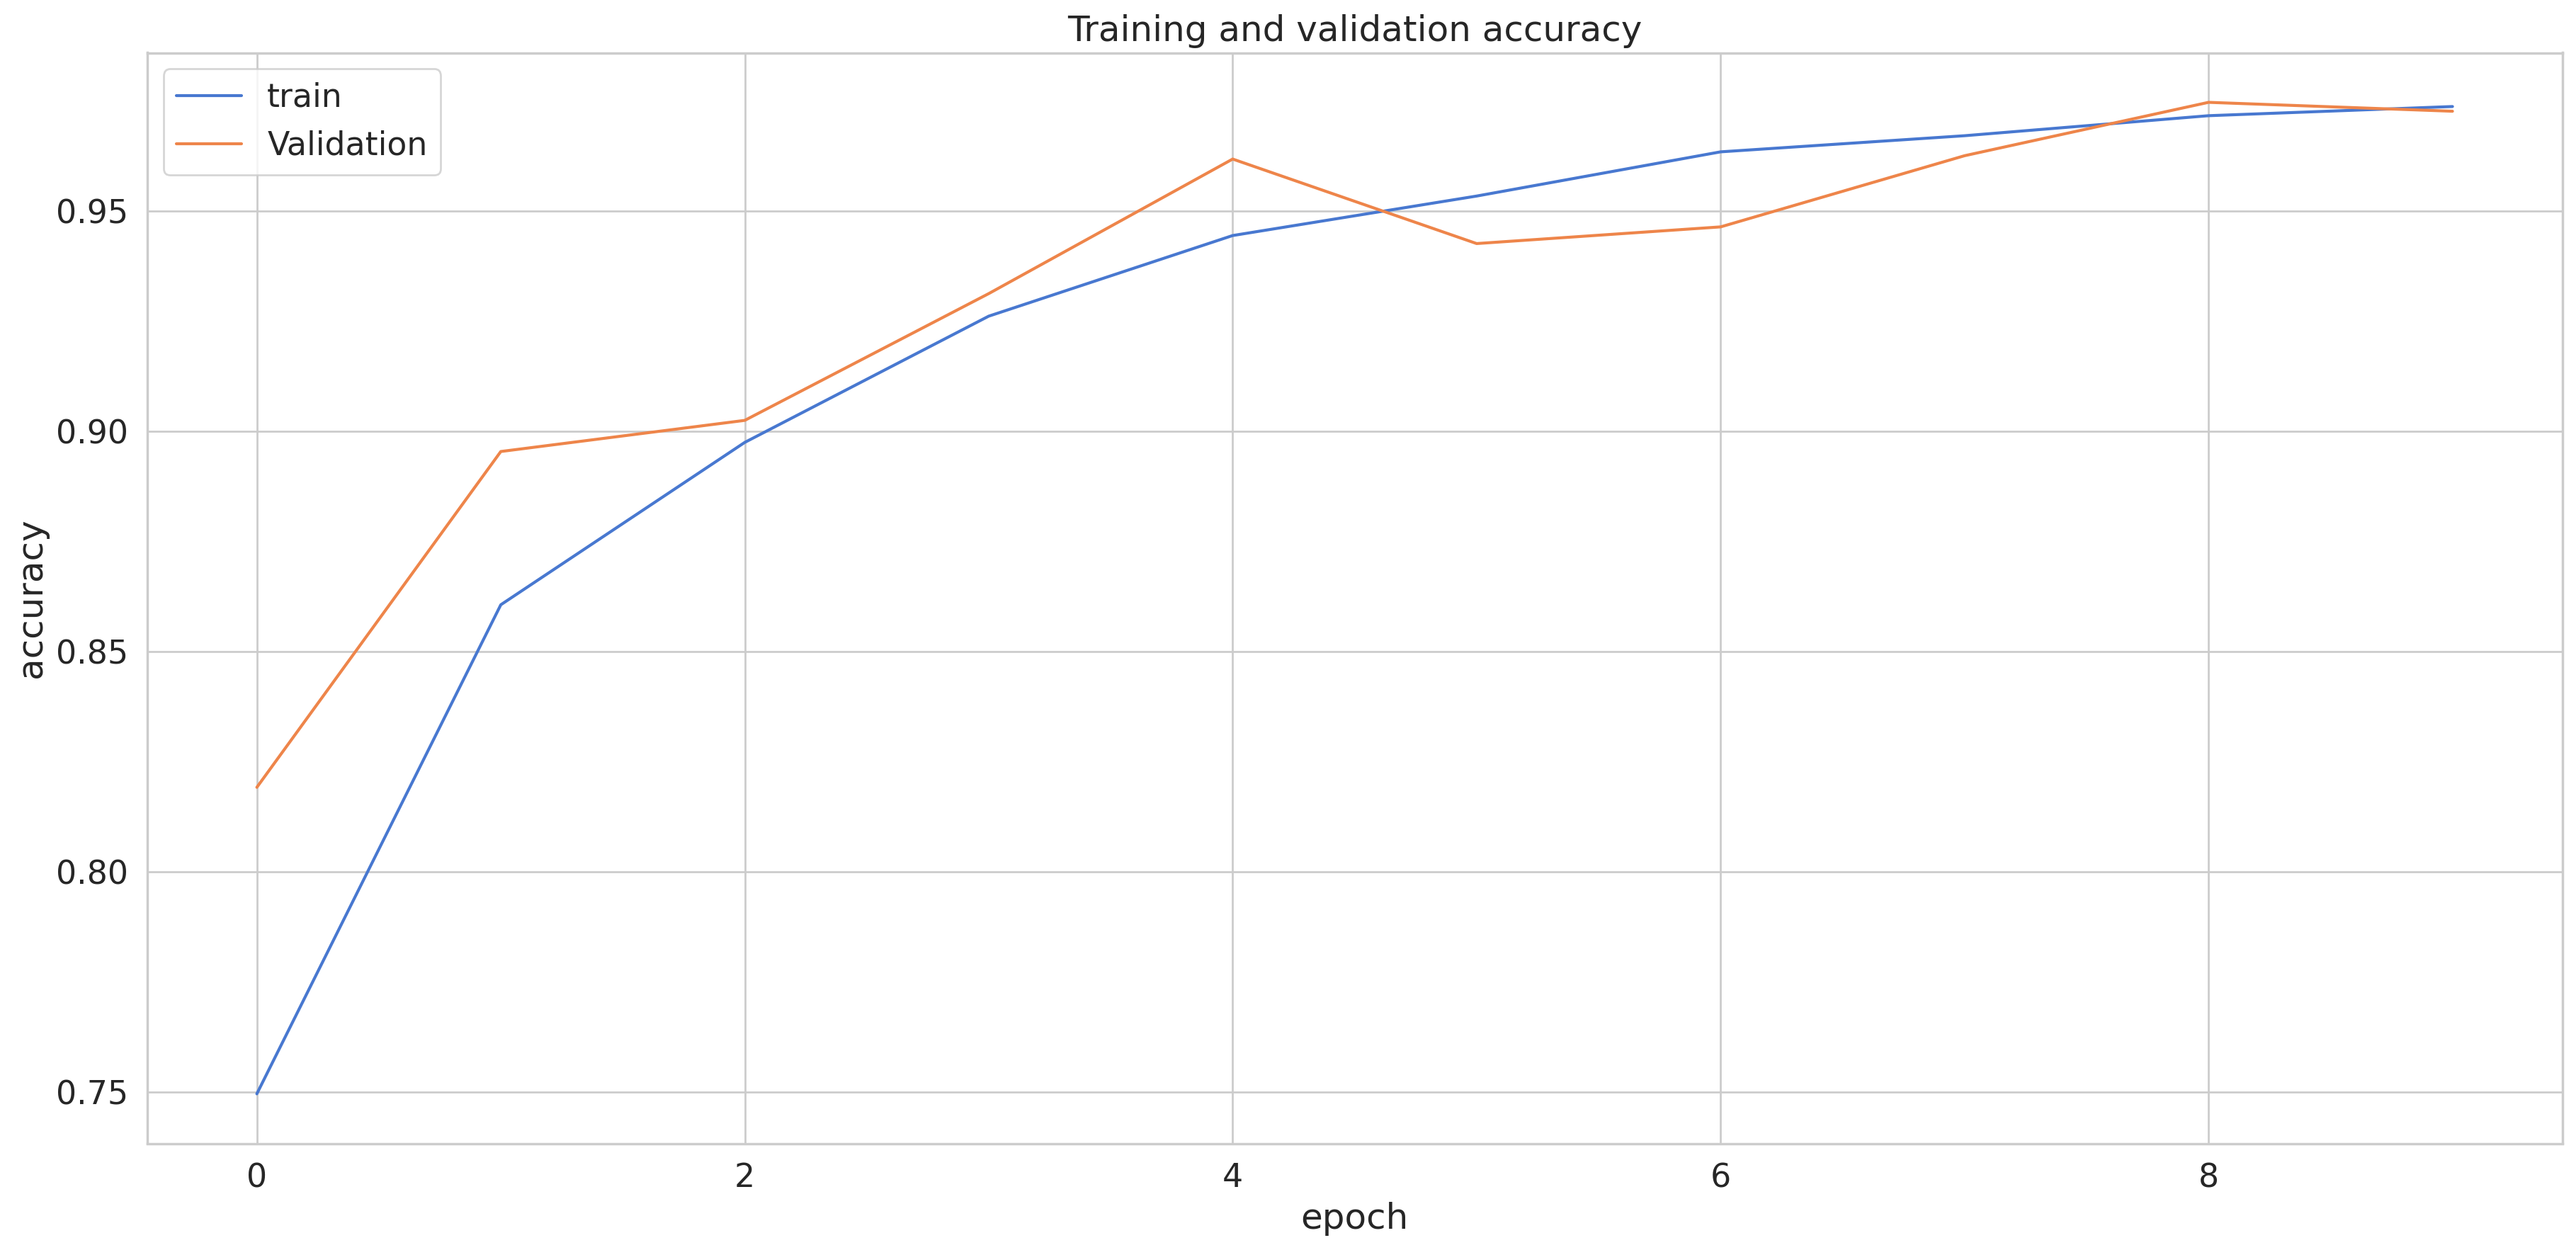

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 5s 22ms/step
f1_score =  0.9691301992026794
0.9690846635683976
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2123
           1       1.00      0.98      0.99      1710
           2       0.86      0.95      0.91       615
           3       0.94      0.85      0.89       501

    accuracy                           0.97      4949
   macro avg       0.95      0.94      0.94      4949
weighted avg       0.97      0.97      0.97      4949



<Axes: >

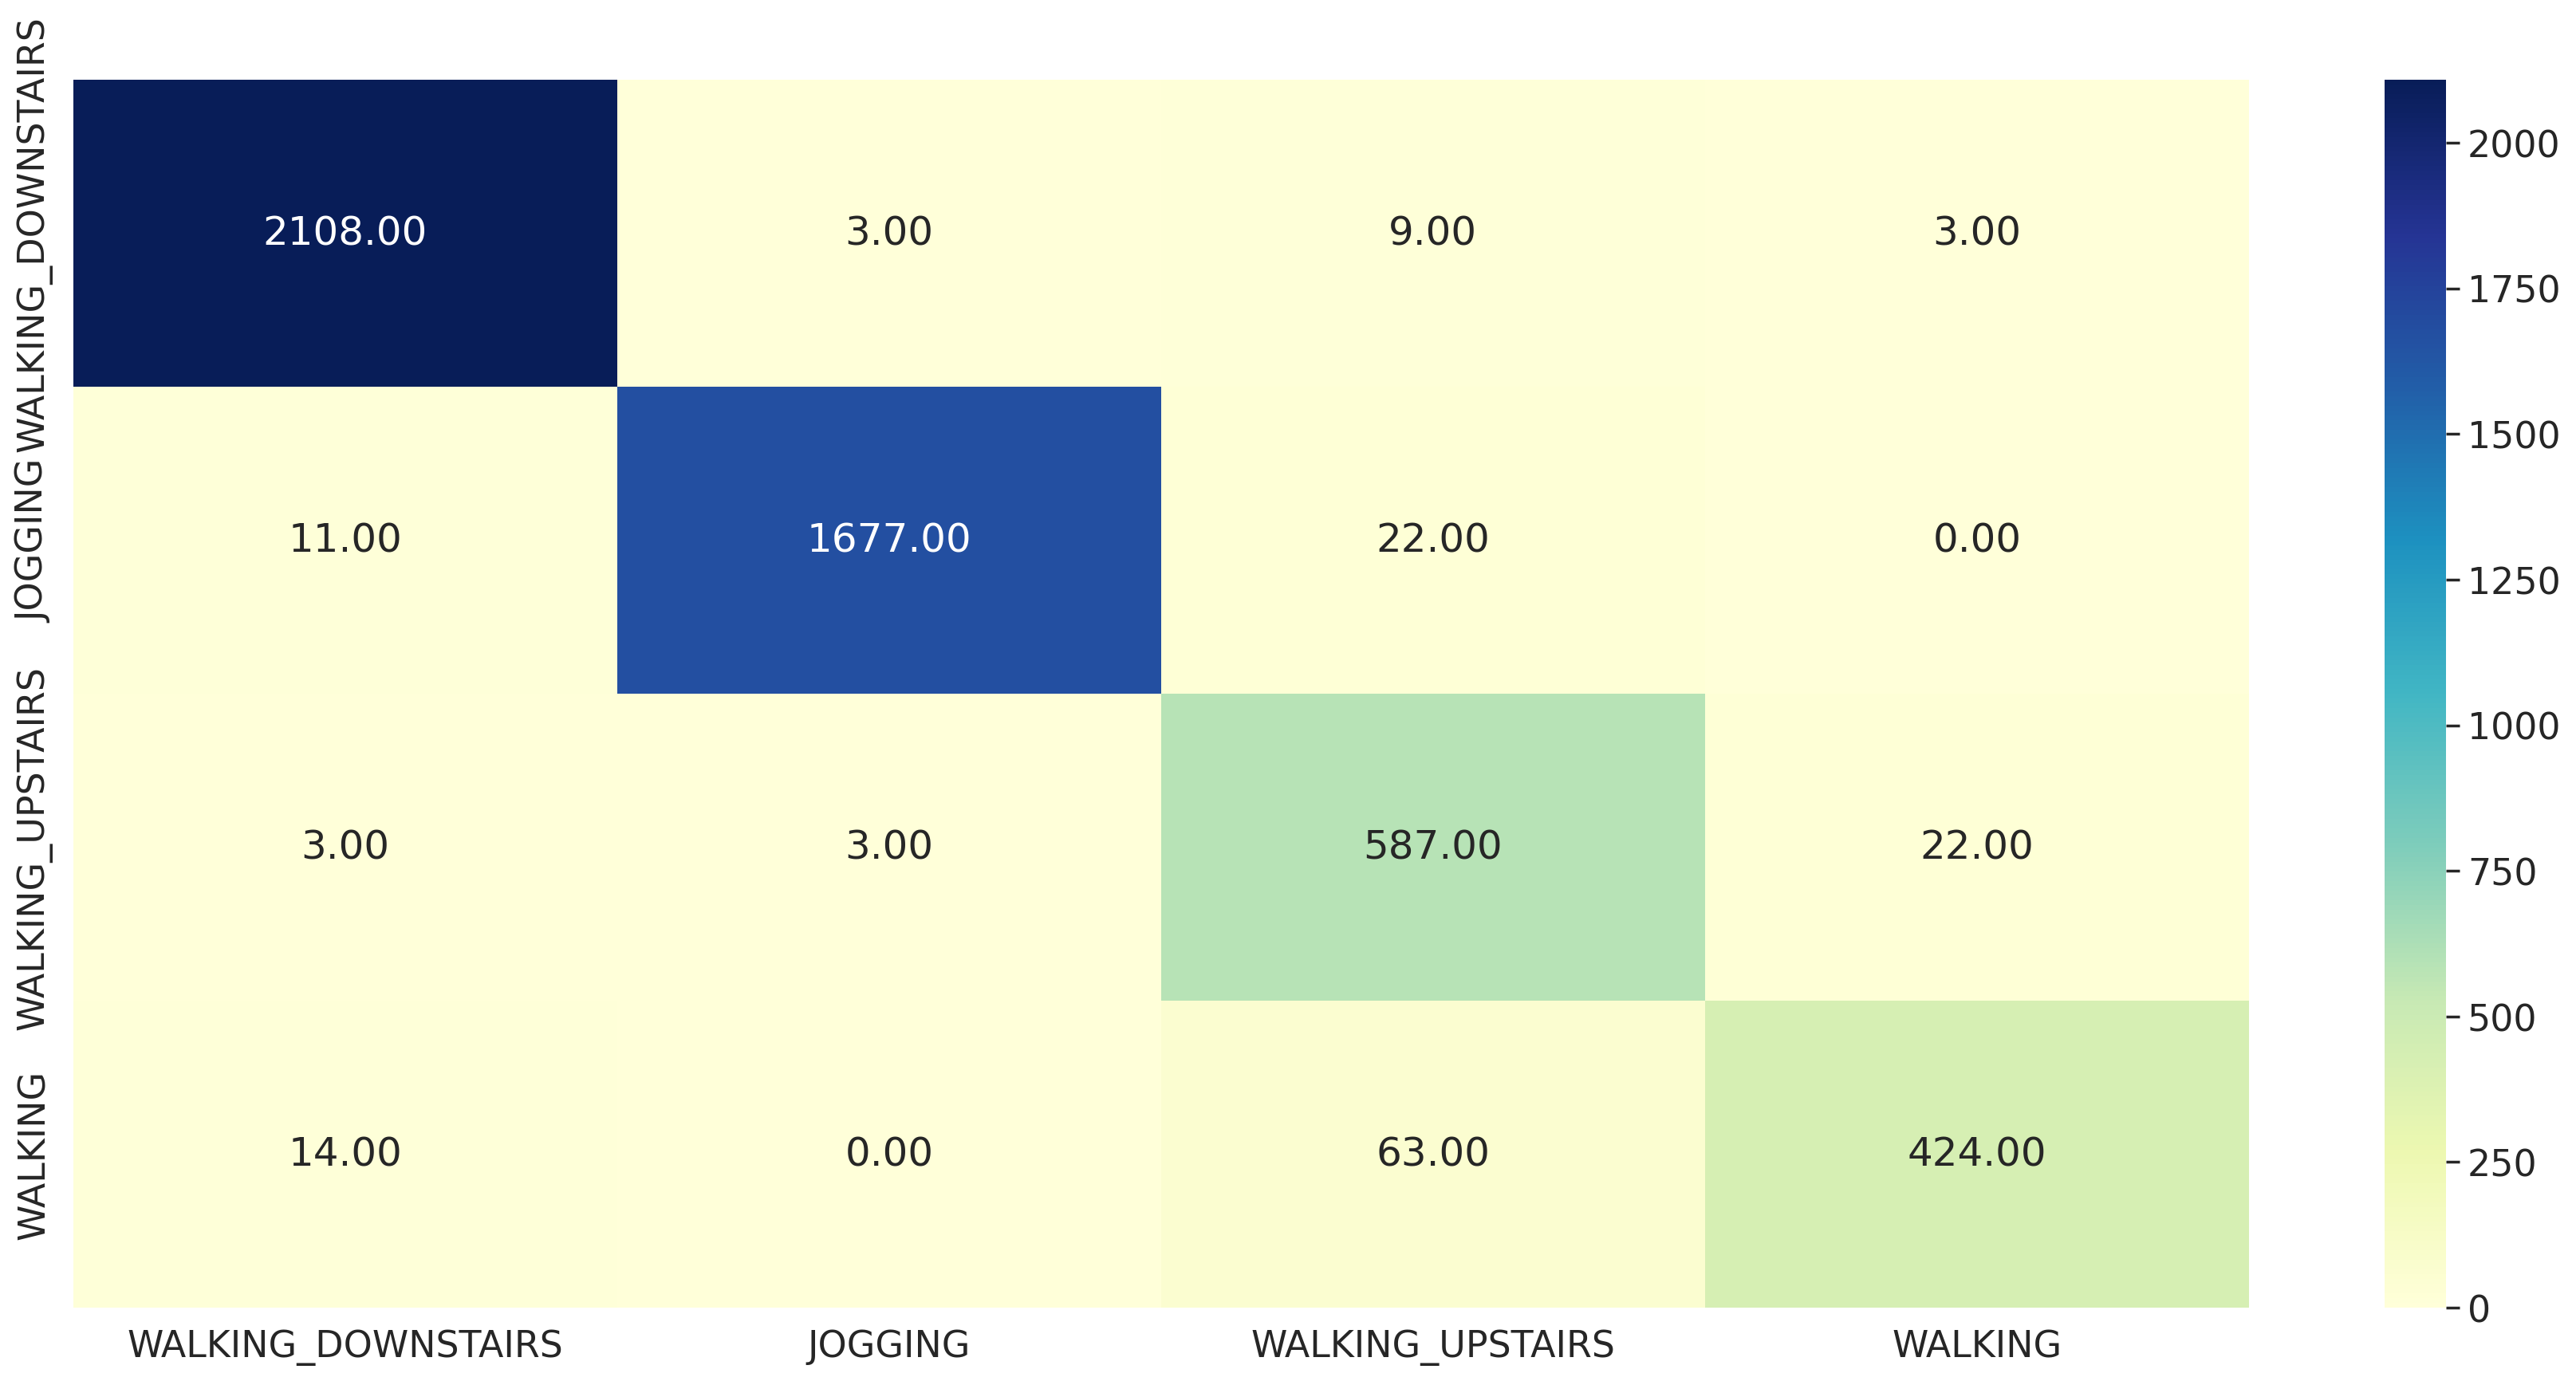

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

#CNN1 - LSTM4

In [25]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, None, 48, 64)      640       
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, None, 48, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, None, 24, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, None, 1536)        0         
 istributed)                                                     
                                                                 
 lstm_5 (LSTM)               (None, None, 100)        

In [26]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 32s 177ms/step - loss: 0.7463 - accuracy: 0.7199 - val_loss: 0.4719 - val_accuracy: 0.8093
Epoch 2/10
124/124 [==============================] - 19s 151ms/step - loss: 0.4483 - accuracy: 0.8237 - val_loss: 0.3457 - val_accuracy: 0.8555
Epoch 3/10
124/124 [==============================] - 19s 150ms/step - loss: 0.3400 - accuracy: 0.8597 - val_loss: 0.2677 - val_accuracy: 0.8841
Epoch 4/10
124/124 [==============================] - 18s 149ms/step - loss: 0.2823 - accuracy: 0.8823 - val_loss: 0.2371 - val_accuracy: 0.9035
Epoch 5/10
124/124 [==============================] - 18s 149ms/step - loss: 0.2456 - accuracy: 0.9018 - val_loss: 0.1885 - val_accuracy: 0.9209
Epoch 6/10
124/124 [==============================] - 19s 152ms/step - loss: 0.1965 - accuracy: 0.9260 - val_loss: 0.1929 - val_accuracy: 0.9252
Epoch 7/10
124/124 [==============================] - 19s 154ms/step - loss: 0.1662 - accuracy: 0.9384 - val_loss: 0.1745 - val_ac

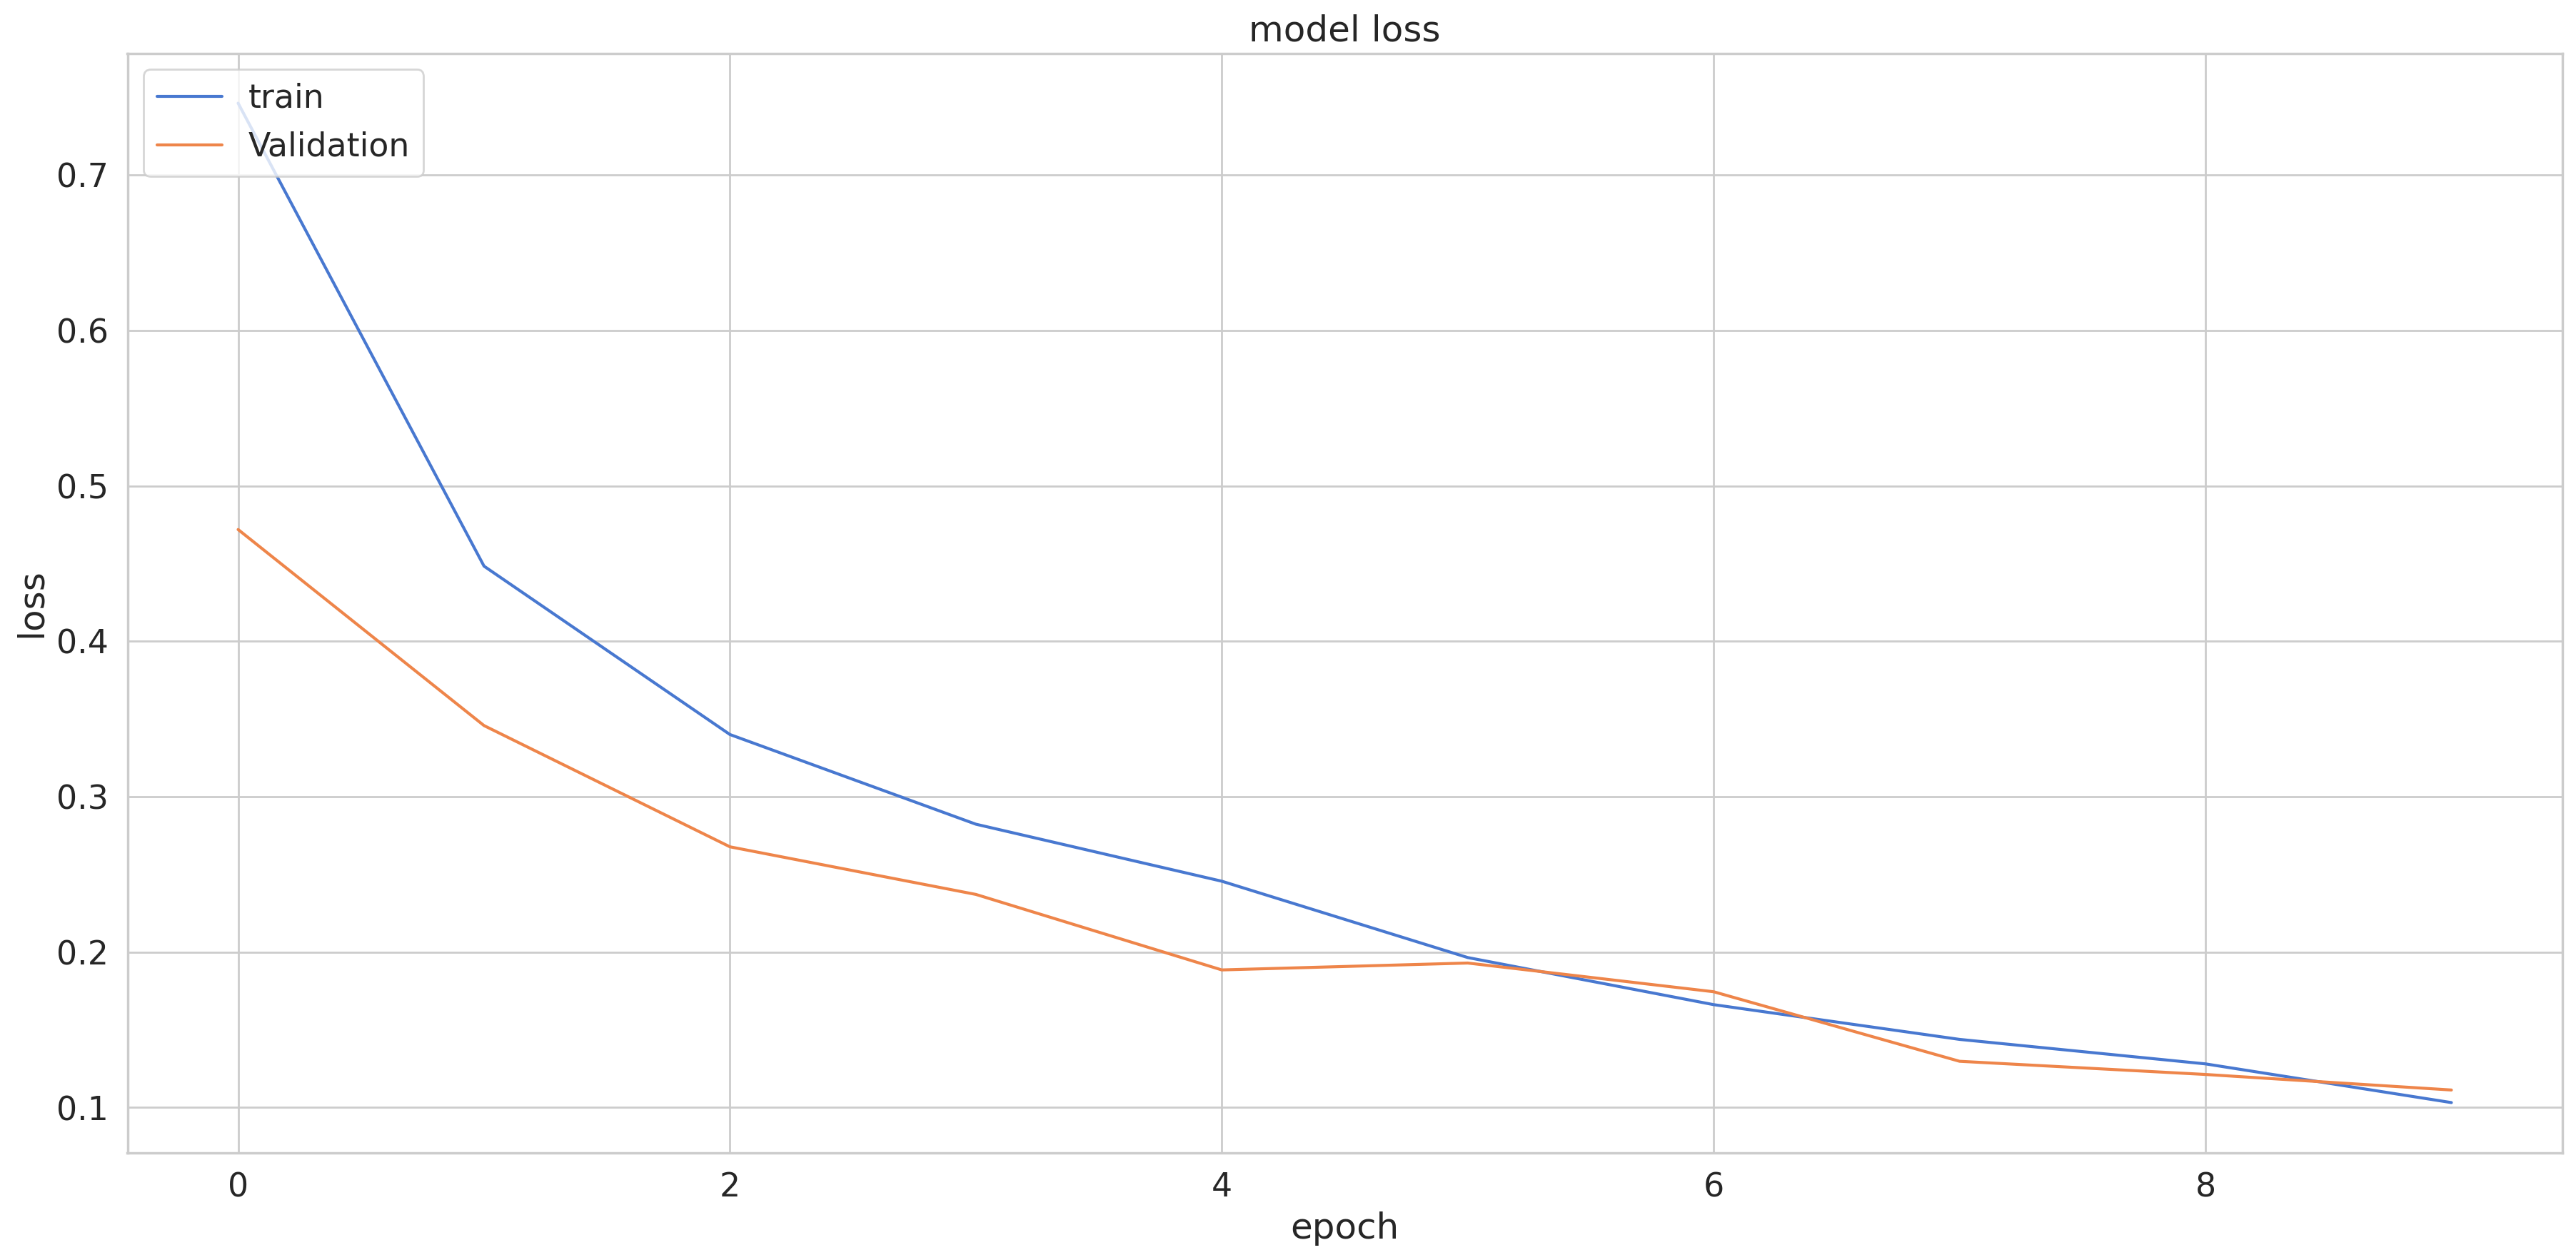

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

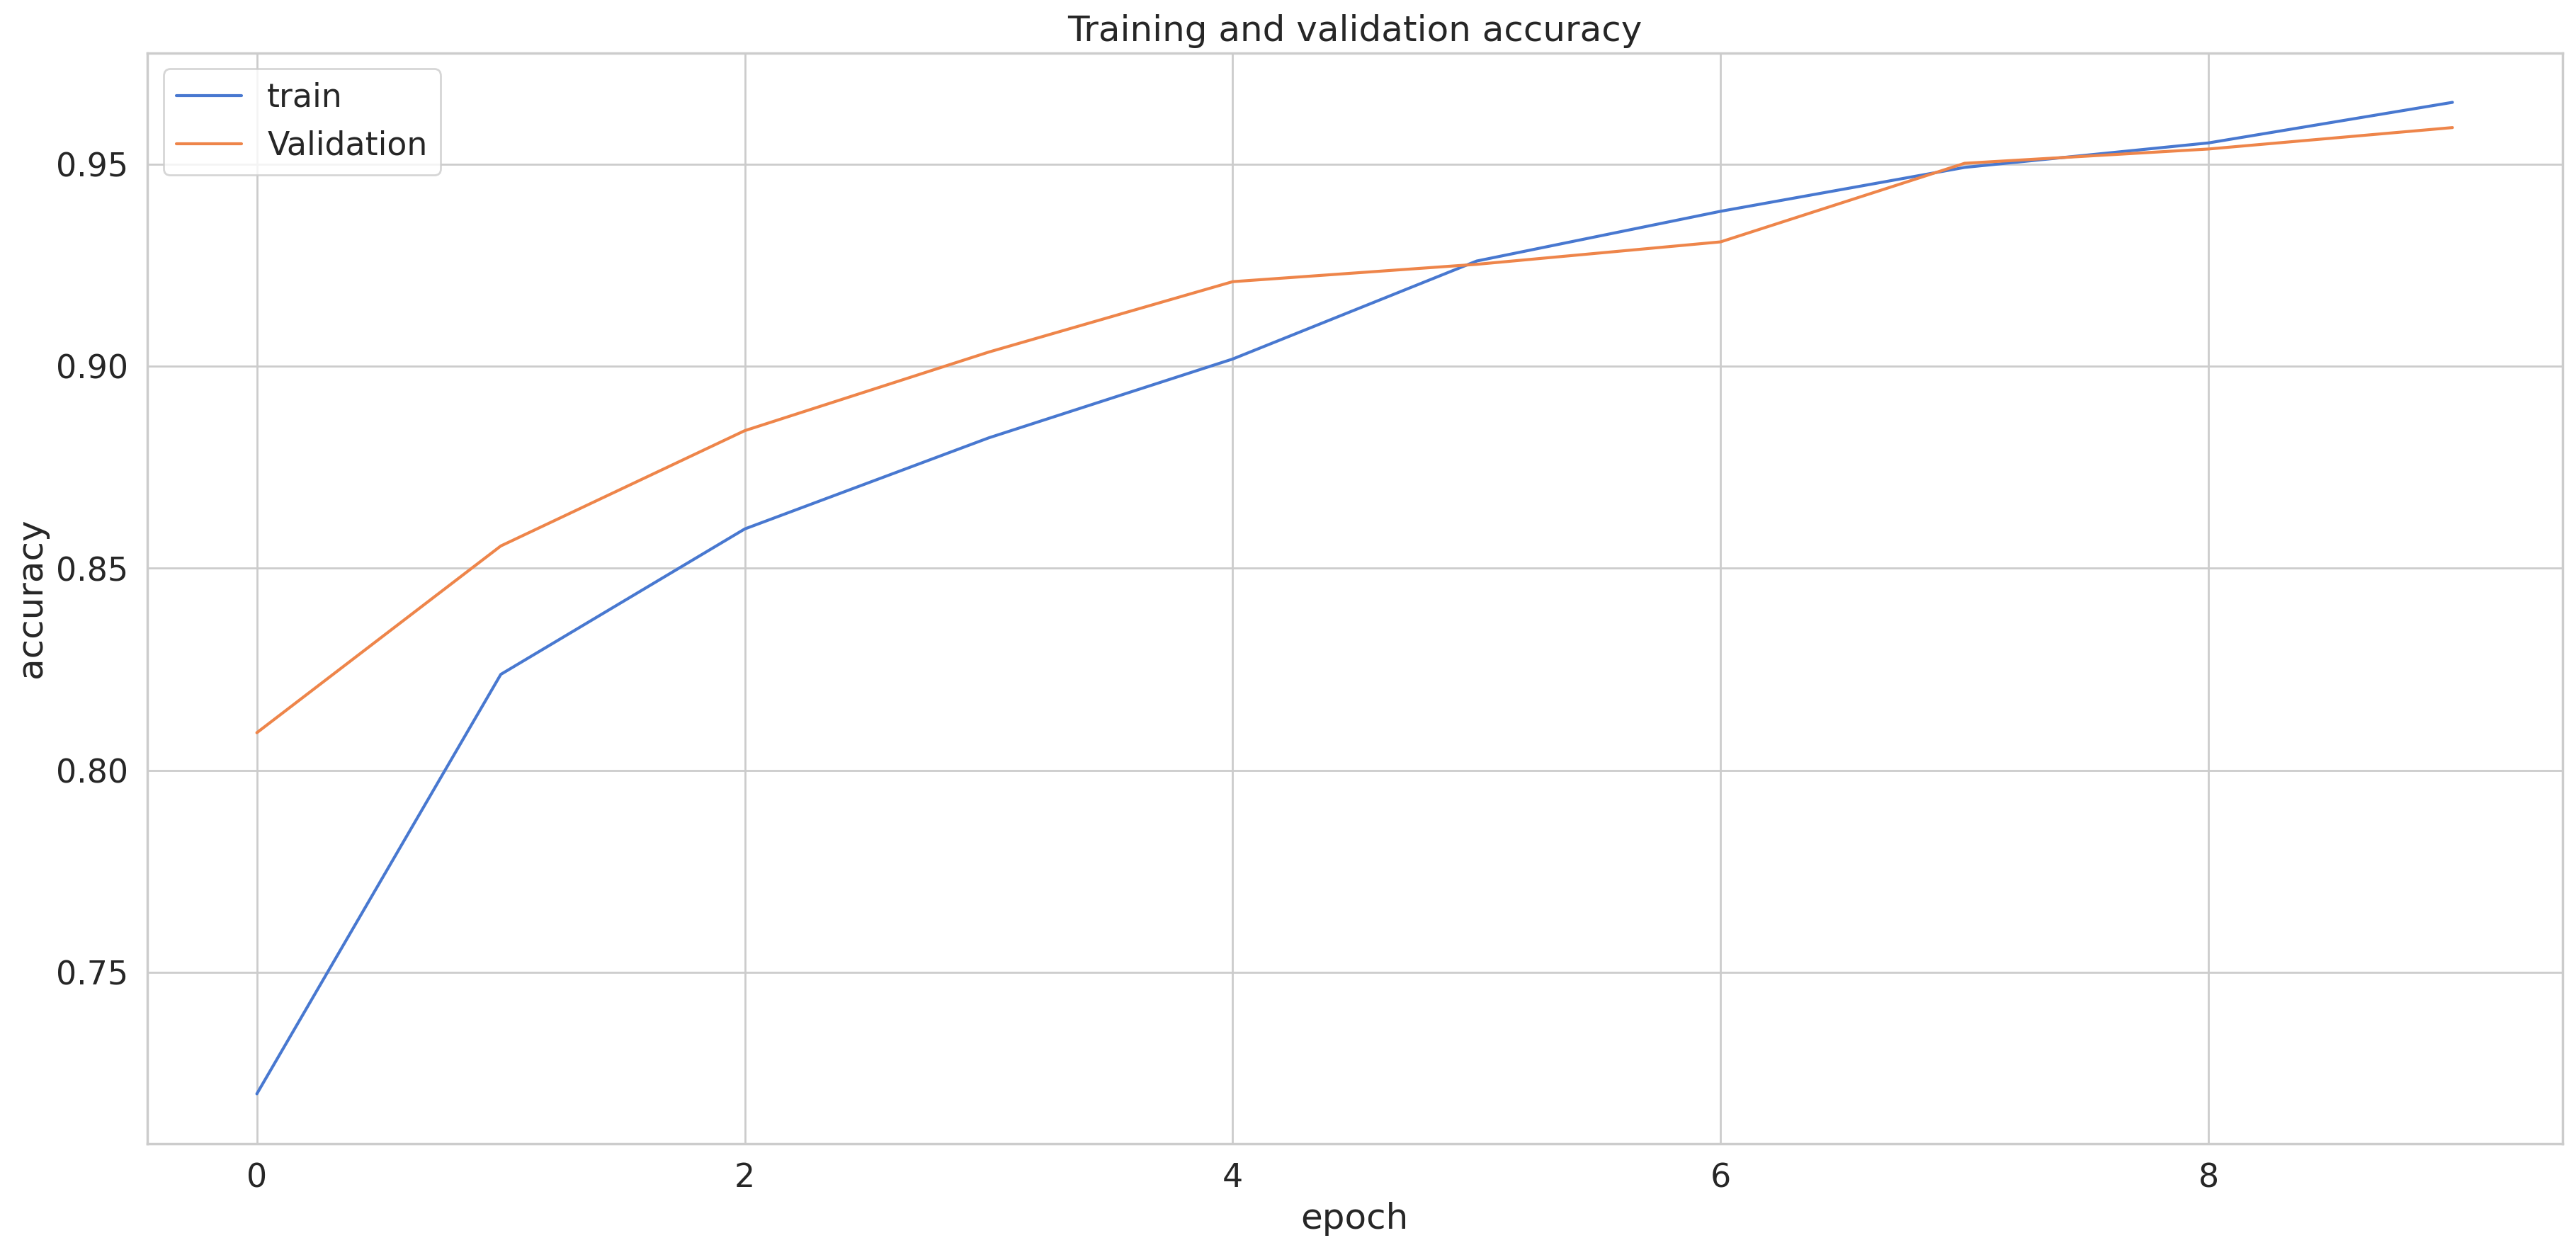

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 6s 20ms/step
f1_score =  0.9595478271372999
0.9595877955142453
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2123
           1       0.99      0.98      0.99      1710
           2       0.88      0.86      0.87       615
           3       0.87      0.90      0.88       501

    accuracy                           0.96      4949
   macro avg       0.93      0.93      0.93      4949
weighted avg       0.96      0.96      0.96      4949



<Axes: >

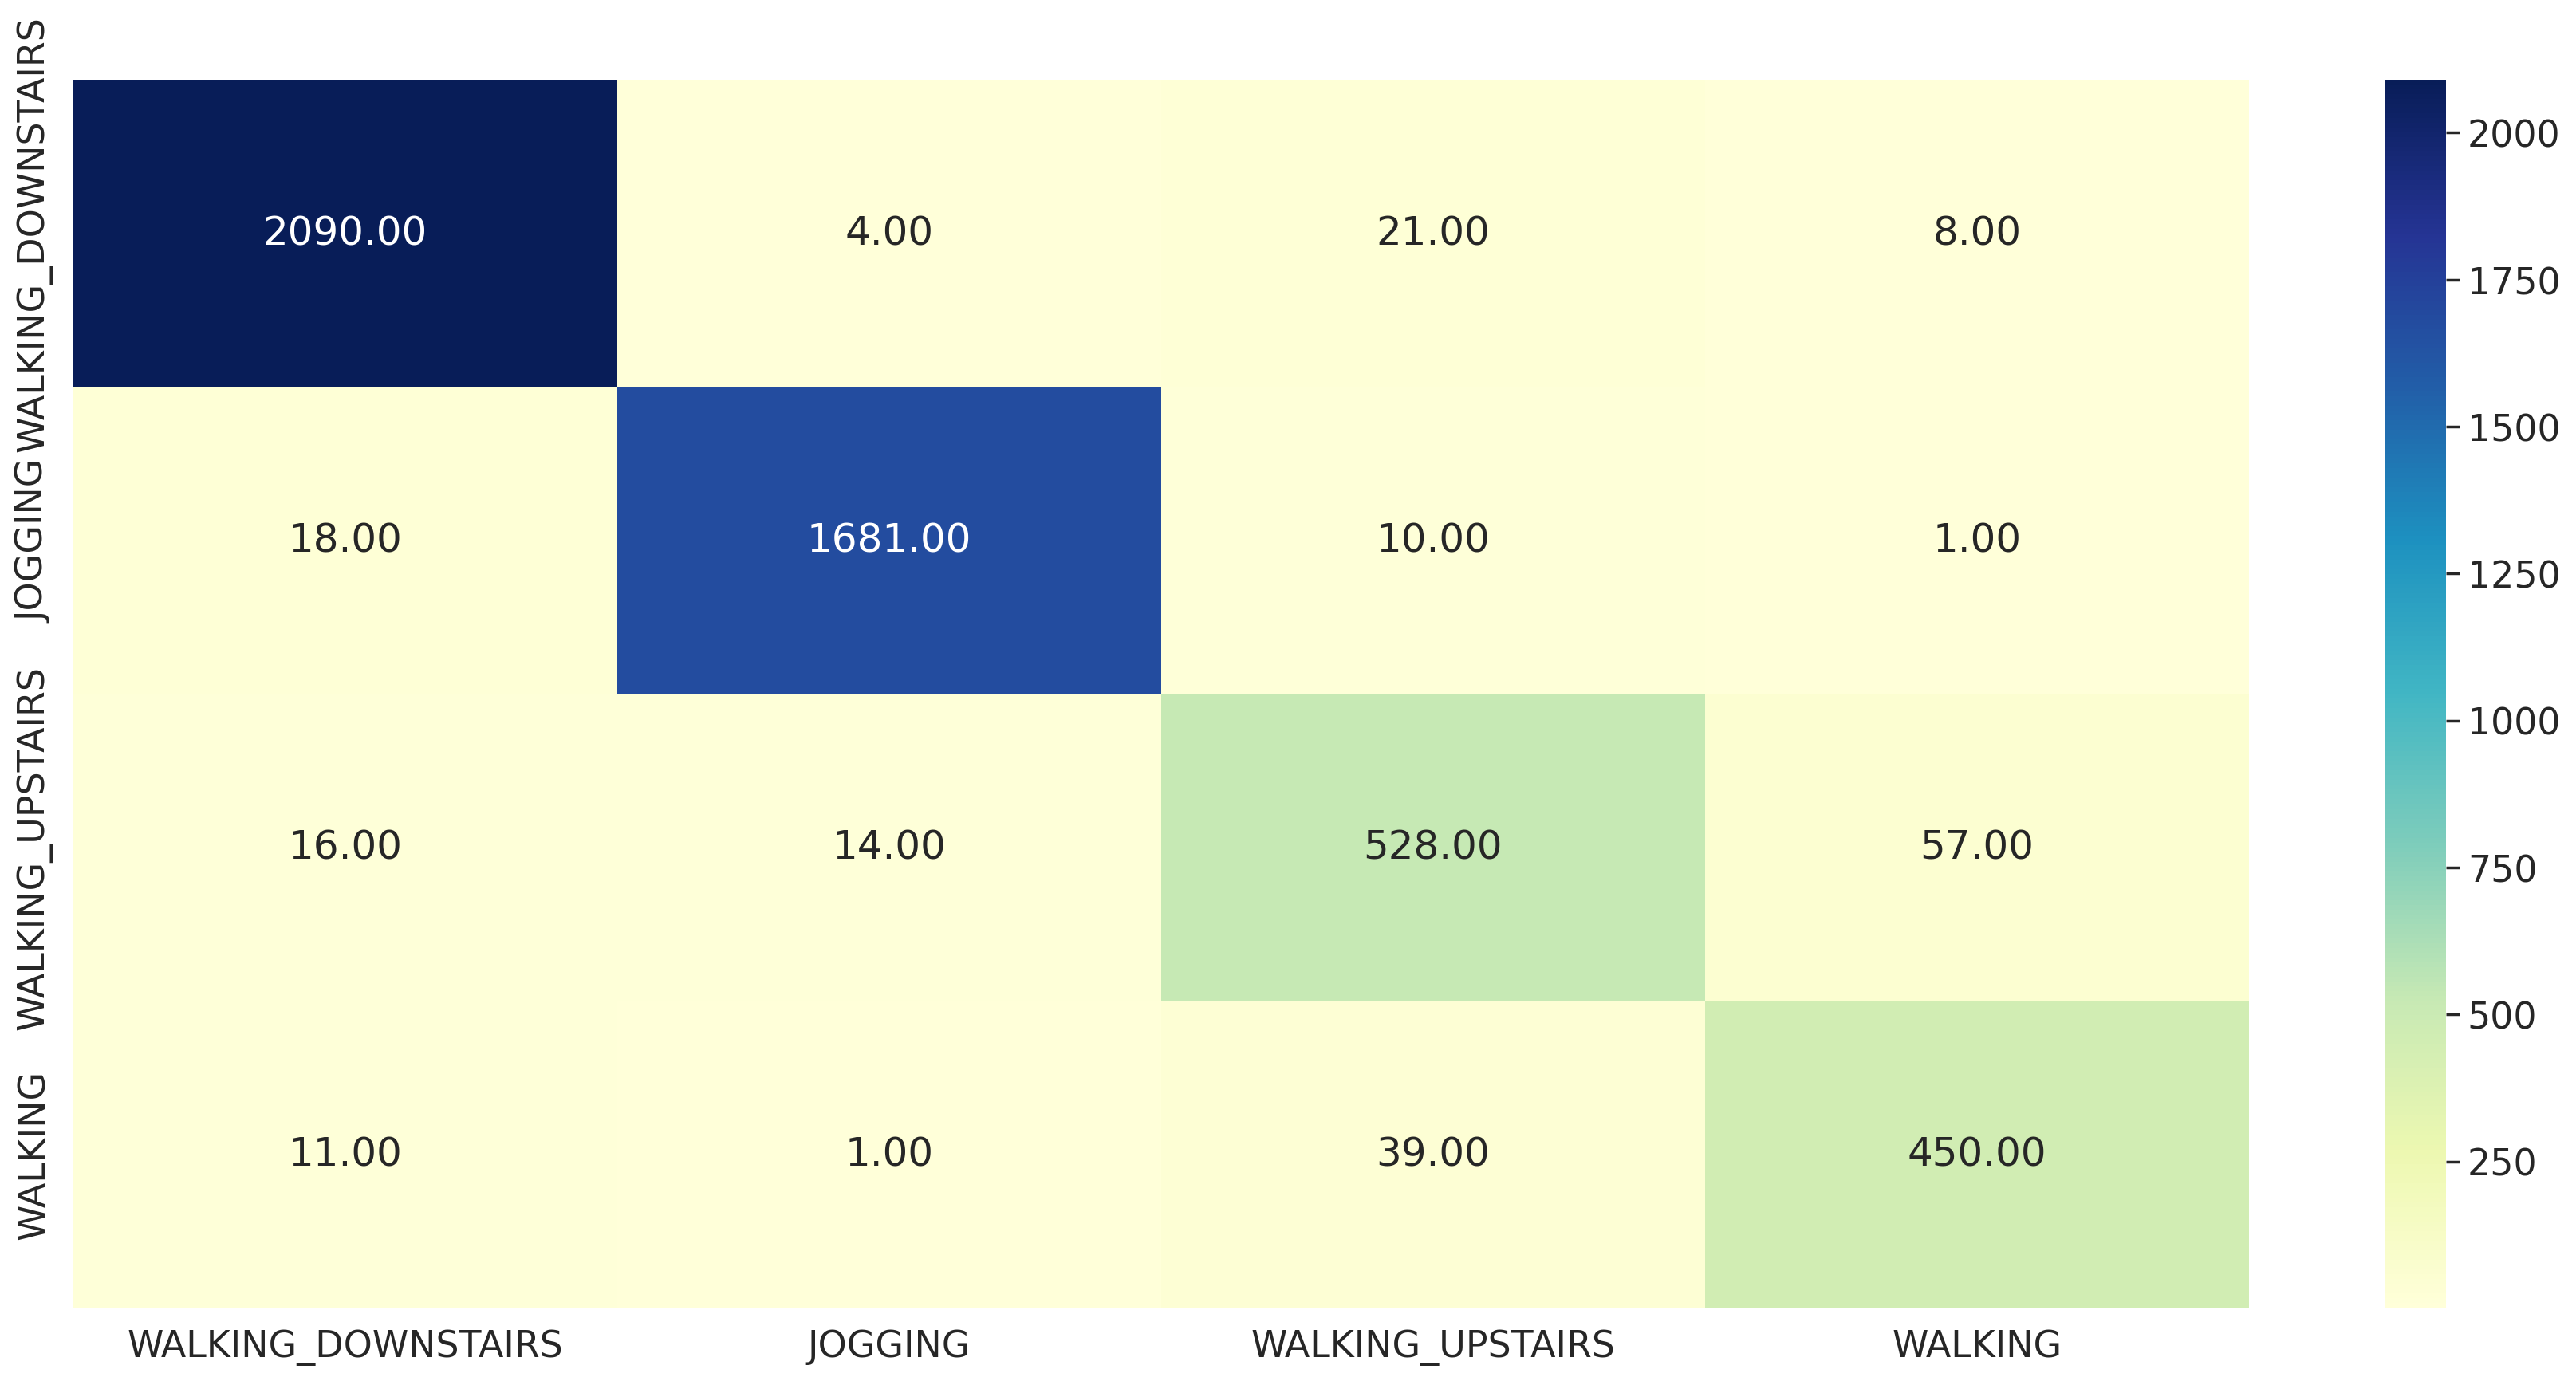

In [29]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')